# load measurements and prepare for the compression & LFI

Notebook divided into 2 parts. First part loads into memory the measurements - both in sims (Dirac / cosmogrid) and Data. Second part performs the compression

In [32]:
import sys
import numpy as np
import pickle
import matplotlib.pyplot as plt
import copy
import glob
import os 

def save_obj(name, obj):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, protocol=2)
        f.close()

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        mute =  pickle.load(f)
        f.close()
    return mute


# Read WPH -------------------------------------------
def load_data(mina,maxa,container,bins = ['0_0', '0_1', '0_2', '0_3', '1_0', '1_1', '1_2', '1_3', '2_0', '2_1', '2_2', '2_3', '3_0', '3_1', '3_2', '3_3'],mean=False,SC_=False):

    keys_ = list( container.keys())
    for k in container.keys():
 

        for b, binx in enumerate(bins):



            u = np.zeros(len(container[keys_[0]][0]['NK'][binx]))

            u[6:12] = container[k][0]['KK'][binx].real[6:12]#-container[k][0]['NN'][binx].real[6:12]
            u[:6] = container[k][0]['KK'][binx].real[:6]#-container[k][0]['NN'][binx].real[:6]
            if SC_:
                u[12:] = container[k][0]['KK'][binx].real[12:]-container[k][0]['NK'][binx].real[12:]
            else:
                u[12:] = container[k][0]['KK'][binx].real[12:]#-container[k][0]['NK'][binx].real[12:]

            try:
                bu = np.zeros(len(container[keys_[0]][0]['bNK'][binx]))

                bu[6:12] = container[k][0]['bKK'][binx].real[6:12]#-container[k][0]['bNN'][binx].real[6:12]
                bu[:6] = container[k][0]['bKK'][binx].real[:6]#-container[k][0]['bNN'][binx].real[:6]
                if SC_:
                    bu[12:] = container[k][0]['bKK'][binx].real[12:]-container[k][0]['bNK'][binx].real[12:] 
                else:
                    bu[12:] = container[k][0]['bKK'][binx].real[12:]#-container[k][0]['bNK'][binx].real[12:] 

            except:
                pass
            
               
                
            if b == 0:
                uu = u[mina:maxa]
                try:
                    buu = bu[mina:maxa]
                except:
                    pass
            else:
                uu = np.hstack([uu,u[mina:maxa]])
                try:
                    buu = np.hstack([buu,bu[mina:maxa]])
                except:
                    pass
        
            
            
            
            
            
            nu = np.zeros(len(container[keys_[0]][0]['NK'][binx]))

            nu[6:12] = container[k][0]['NN'][binx].real[6:12]#-container[k][0]['NN'][binx].real[6:12]
            nu[:6] = container[k][0]['NN'][binx].real[:6]#-container[k][0]['NN'][binx].real[:6]
            if SC_:
                nu[12:] =container[k][0]['NK'][binx].real[12:]
            else:
                nu[12:] = container[k][0]['NK'][binx].real[12:]#-container[k][0]['NK'][binx].real[12:]

            try:
                nbu = np.zeros(len(container[keys_[0]][0]['bNK'][binx]))

                nbu[6:12] = container[k][0]['bNN'][binx].real[6:12]#-container[k][0]['bNN'][binx].real[6:12]
                nbu[:6] = container[k][0]['bNN'][binx].real[:6]#-container[k][0]['bNN'][binx].real[:6]
                if SC_:
                    nbu[12:] = container[k][0]['bNK'][binx].real[12:] 
                else:
                    nbu[12:] = container[k][0]['bNK'][binx].real[12:]#-container[k][0]['bNK'][binx].real[12:] 

            except:
                pass
            
               
            if b == 0:
                nuu = nu[mina:maxa]
                try:
                    nbuu = nbu[mina:maxa]
                except:
                    pass
            else:
                nuu = np.hstack([nuu,nu[mina:maxa]])
                try:
                    nbuu = np.hstack([nbuu,nbu[mina:maxa]])
                except:
                    pass     
            
            
            
            
            
            
            
                

        if mean:
            try:
                d += uu
                nd += nuu
                c += 1
                try:
                    bd += buu
                    nbd += nbuu
                except:
                    pass
            except:
                    d = uu
                    nd = nuu
                    c = 1
                    try:
                        bd = buu
                        nbd = nbuu
                    except:
                        pass
                    try:
                        sr = container[k][1]
                    except:
                        pass
        else:
            
            try:
                    d.append(uu)
                    nd.append(nuu)
                    try:
                        bd.append(buu)
                        nbd.append(nbuu)
                    except:
                        pass
                    try:
                        sr.append(container[k][1])
                    except:
                        pass
            except:
                    d = [uu]
                    nd = [nuu]
                    try:
                        bd = [buu]
                        nbd = [nbuu]
                    except:
                        pass
                    try:
                        sr = [container[k][1]]
                    except:
                        pass
    if mean:               
        d /= c
        nd /= c
        try:
            bd /= c
            nbd /= c
            return d,bd,nd,nbd
        except:
            return d,nd
    else:
        try:
            try:
                return np.array(d),np.array(bd),np.array(nd),np.array(nbd),np.array(sr)
            except:
                return np.array(d),np.array(nd),np.array(sr)
        except:
            try:
                return np.array(d),np.array(bd),np.array(nd),np.array(nbd),0.
            except:
                return np.array(d),np.array(nd),0
            

            
        

def covariance_jck(TOTAL_PHI,jk_r,type_cov):
  if type_cov=='jackknife':
      fact=(jk_r-1.)/(jk_r)

  elif type_cov=='bootstrap':
      fact=1./(jk_r)
  #  Covariance estimation

  average=np.zeros(TOTAL_PHI.shape[0])
  cov_jck=np.zeros((TOTAL_PHI.shape[0],TOTAL_PHI.shape[0]))
  err_jck=np.zeros(TOTAL_PHI.shape[0])


  for kk in range(jk_r):
    average+=TOTAL_PHI[:,kk]
  average=average/(jk_r)

 # print average
  for ii in range(TOTAL_PHI.shape[0]):
     for jj in range(ii+1):
          for kk in range(jk_r):
            cov_jck[jj,ii]+=TOTAL_PHI[ii,kk]*TOTAL_PHI[jj,kk]

          cov_jck[jj,ii]=(-average[ii]*average[jj]*jk_r+cov_jck[jj,ii])*fact
          cov_jck[ii,jj]=cov_jck[jj,ii]

  for ii in range(TOTAL_PHI.shape[0]):
   err_jck[ii]=np.sqrt(cov_jck[ii,ii])
 # print err_jck

  #compute correlation
  corr=np.zeros((TOTAL_PHI.shape[0],TOTAL_PHI.shape[0]))
  for i in range(TOTAL_PHI.shape[0]):
      for j in range(TOTAL_PHI.shape[0]):
        corr[i,j]=cov_jck[i,j]/(np.sqrt(cov_jck[i,i]*cov_jck[j,j]))

  average=average*fact
  return {'cov' : cov_jck,
          'err' : err_jck,
          'corr':corr,
          'mean':average}


def get_labels(mina,maxa,filters = [0,1,2,3,4,5], bins = ['0_0', '0_1', '0_2', '0_3', '1_0', '1_1', '1_2', '1_3', '2_0', '2_1', '2_2', '2_3', '3_0', '3_1', '3_2', '3_3']):
    data_labels = []

    # define dv indexes:
  
    dv_index = []
    bins_index = []
    for f_ in filters:
        dv_index.append([str(np.int(f_))+'_'+str(np.int(f_))+'_'+'S00'])

    for f_ in filters:
        dv_index.append([str(np.int(f_))+'_'+str(np.int(f_))+'_'+'S11'])

    for f_ in filters:
        dv_index.append([str(np.int(f_))+'_'+str(np.int(f_))+'_'+'S01'])

    for f_ in filters:
        for f_1 in filters:
            if f_<f_1:
                dv_index.append([str(np.int(f_))+'_'+str(np.int(f_1))+'_'+'C01_dl0'])
                dv_index.append([str(np.int(f_))+'_'+str(np.int(f_1))+'_'+'C01_dl1'])

    for f_ in filters:
        for f_1 in filters:
            if f_<f_1:
                dv_index.append([str(np.int(f_))+'_'+str(np.int(f_1))+'_'+'Cphase'])



    for b, binx in enumerate(bins):
        for dd in dv_index[mina:maxa]:
            data_labels.append('bin_'+binx+'_'+dd[0])
            bins_index.append('bin_'+binx+'_')
    
    return data_labels,bins_index


# read moments ----------------------------
# read moments ----------------------------
def read_m(u,SC_=False):
    bins_2 = ['0_0', '0_1', '0_2', '0_3', '1_1', '1_2', '1_3', '2_2', '2_3', '3_3']
    bins_3 = np.unique(['0_0_0', '0_0_1', '0_0_2', '0_0_3', '0_1_1', '0_1_2', '0_1_3', '0_2_2', '0_2_3', '0_3_3', '1_1_1', '1_1_2', '1_1_3', '1_2_2', '1_2_3', '1_3_3', '2_2_2', '2_2_3', '2_3_3', '3_3_3', '0_1_0', '0_2_0', '0_2_1', '0_3_0', '0_3_1', '0_3_2', '1_0_0', '1_0_1', '1_0_2', '1_0_3', '1_1_0', '1_2_0', '1_2_1', '1_3_0', '1_3_1', '1_3_2', '2_0_0', '2_0_1', '2_0_2', '2_0_3', '2_1_0', '2_1_1', '2_1_2', '2_1_3', '2_2_0', '2_2_1', '2_3_0', '2_3_1', '2_3_2', '3_0_0', '3_0_1', '3_0_2', '3_0_3', '3_1_0', '3_1_1', '3_1_2', '3_1_3', '3_2_0', '3_2_1', '3_2_2', '3_2_3', '3_3_0', '3_3_1', '3_3_2'])
    count = 0
    for b in bins_2:
        if count ==0:
            dv2 = u[0].moments['KK'][b] #- u[0].moments['NN'][b]
        else:
            dv2 = np.hstack([dv2,u[0].moments['KK'][b]]) #- u[0].moments['NN'][b]])
        count +=1

    count = 0
    for b in bins_2:
        if count ==0:
            dv2b = u[0].moments['bKK'][b]# - u[0].moments['bNN'][b]
        else:
            dv2b = np.hstack([dv2b,u[0].moments['bKK'][b]])# - u[0].moments['bNN'][b]])
        count +=1

        
    count = 0
    for b in bins_2:
        if count ==0:
            dv2n = u[0].moments['NN'][b]
        else:
            dv2n = np.hstack([dv2n,u[0].moments['NN'][b]])
        count +=1

    count = 0
    for b in bins_2:
        if count ==0:
            dv2bn =  u[0].moments['bNN'][b]
        else:
            dv2bn = np.hstack([dv2bn,u[0].moments['bNN'][b]])
        count +=1
        
        
    count = 0
    for b in bins_3:
        #try:
            if count ==0:
                
                if SC_:
                    
                    m, j,k = b.split('_')
                    b1 = '{0}_{1}_{2}'.format(m, j, k)
                    b2 = '{0}_{1}_{2}'.format(k, j, j)
                    b3 = '{0}_{1}_{2}'.format(j, m, k)
                    de = -u[0].moments['NK'][b1]-u[0].moments['NK'][b2]-u[0].moments['NK'][b3]
                    dv3 = u[0].moments['KK'][b] + de
                    
                else:
                    dv3 = u[0].moments['KK'][b]#-u[0].moments['NK'][b]
            else:
                try:
                    if SC_:
                        m, j,k = b.split('_')
                        b1 = '{0}_{1}_{2}'.format(m, j, k)
                        b2 = '{0}_{1}_{2}'.format(k, j, j)
                        b3 = '{0}_{1}_{2}'.format(j, m, k)
                        de = -u[0].moments['NK'][b1]-u[0].moments['NK'][b2]-u[0].moments['NK'][b3]
                        dv3 = np.hstack([dv3,u[0].moments['KK'][b]]) + de
                    else:
                        dv3 = np.hstack([dv3,u[0].moments['KK'][b]])#-u[0].moments['NK'][b]])
                except:
                    pass
        #except:
        #    pass
            count +=1



    count = 0
    for b in bins_3:
        #try:
            if count ==0:
                

                    dv3n = u[0].moments['NN'][b]#-u[0].moments['NK'][b]
            else:

                    dv3n = np.hstack([dv3n,u[0].moments['NN'][b]])#-u[0].moments['NK'][b]])
 
        #except:
        #    pass
            count +=1
            
            
    count = 0
    for b in bins_3:
        #try:
            if count ==0:
                
               
                    
                    m, j,k = b.split('_')
                    b1 = '{0}_{1}_{2}'.format(m, j, k)
                    b2 = '{0}_{1}_{2}'.format(k, j, j)
                    b3 = '{0}_{1}_{2}'.format(j, m, k)
                    de = u[0].moments['KN'][b1]+u[0].moments['KN'][b2]+u[0].moments['KN'][b3]
                    
                    
         
            else:
                                    
                    m, j,k = b.split('_')
                    b1 = '{0}_{1}_{2}'.format(m, j, k)
                    b2 = '{0}_{1}_{2}'.format(k, j, j)
                    b3 = '{0}_{1}_{2}'.format(j, m, k)
                    try:
                        de_ = u[0].moments['KN'][b1]+u[0].moments['KN'][b2]+u[0].moments['KN'][b3]
                    except:
                        de_ = np.zeros(len(u[0].moments['KK'][b1]))
                    de = np.hstack([de,de_])#-u[0].moments['NK'][b]])
    
        #except:
        #    pass
            count +=1
            
    count = 0
    for b in bins_3:
        try:
            if count ==0:
                
                if SC_:
                    
                    m, j,k = b.split('_')
                    b1 = '{0}_{1}_{2}'.format(m, j, k)
                    b2 = '{0}_{1}_{2}'.format(k, j, j)
                    b3 = '{0}_{1}_{2}'.format(j, m, k)
                    de = -u[0].moments['bNK'][b1]-u[0].moments['bNK'][b2]-u[0].moments['bNK'][b3]
                    dv3b = u[0].moments['bKK'][b] + de
                    
                else:
                    dv3b = u[0].moments['bKK'][b]#-u[0].moments['NK'][b]
            else:
                try:
                    if SC_:
                        m, j,k = b.split('_')
                        b1 = '{0}_{1}_{2}'.format(m, j, k)
                        b2 = '{0}_{1}_{2}'.format(k, j, j)
                        b3 = '{0}_{1}_{2}'.format(j, m, k)
                        de = -u[0].moments['bNK'][b1]-u[0].moments['bNK'][b2]-u[0].moments['bNK'][b3]
                        dv3b = np.hstack([dv3b,u[0].moments['bKK'][b]]) + de
                    else:
                        dv3b = np.hstack([dv3b,u[0].moments['bKK'][b]])#-u[0].moments['NK'][b]])
                except:
                    pass

        except:
            pass
        count +=1

    return dv2,dv3,dv2b,dv3b,dv2n,dv2bn,de,dv3n

# read ST ---------------------------------------------
def make_dv_s2_noise(m_):

    for o,i in enumerate(m_[0].moments_ST['K'].keys()):
        if i >9:
            ex = 'x_'
        else:
            ex = 'auto_'
        len_S1 = len(m_[0].moments_ST['K'][i]['S1'])
        len_S2 = len(m_[0].moments_ST['K'][i]['S2'])
        
        if o == 0:
            dv = np.hstack([m_[0].moments_ST['K'][i]['S0'],m_[0].moments_ST['K'][i]['S1'],m_[0].moments_ST['K'][i]['S2']])
            dvn = np.hstack([m_[0].moments_ST['KN'][i]['S0'],m_[0].moments_ST['KN'][i]['S1'],m_[0].moments_ST['KN'][i]['S2']])
            labels = np.hstack([ex+'S0_bin{0}'.format(i), np.array([ex+'S1_bin{0}'.format(i)]*len_S1), np.array([ex+'S2_bin{0}'.format(i)]*len_S2)])
        else:
            dv_ = np.hstack([m_[0].moments_ST['K'][i]['S0'],m_[0].moments_ST['K'][i]['S1'],m_[0].moments_ST['K'][i]['S2']])
            dvn_ = np.hstack([m_[0].moments_ST['KN'][i]['S0'],m_[0].moments_ST['KN'][i]['S1'],m_[0].moments_ST['KN'][i]['S2']])
            labels_ = np.hstack([ex+'S0_bin{0}'.format(i), np.array([ex+'S1_bin{0}'.format(i)]*len_S1), np.array([ex+'S2_bin{0}'.format(i)]*len_S2)])
            labels = np.hstack([labels,labels_])
            dv = np.hstack([dv,dv_])
            dvn = np.hstack([dvn,dvn_])
            
    return dv,dvn,labels

# read peaks -------------

def read_peaks(m_):
    count = 0
    for t in m_.peaks['k_sm_kE'].keys():
        for sc in m_.peaks['k_sm_kE'][t].keys():
            if count == 0:
                dv = (m_.peaks['k_sm_kE'][t][sc]-m_.peaks['kn_sm_kE'][t][sc]) 
                tomo    = t*np.ones(len(m_.peaks['k_sm_kE'][t][sc]))
                filters = sc*np.ones(len(m_.peaks['k_sm_kE'][t][sc]))
                scales = m_.peaks['k_sm_kE'][t][sc]
                
            else:
                dv = np.hstack([dv,(m_.peaks['k_sm_kE'][t][sc]-m_.peaks['kn_sm_kE'][t][sc]) ])
                tomo_    = t*np.ones(len(m_.peaks['k_sm_kE'][t][sc]))
                filters_ = sc*np.ones(len(m_.peaks['k_sm_kE'][t][sc]))

                tomo = np.hstack([tomo,tomo_])
                filters = np.hstack([filters,filters_])

                scales = np.hstack([scales,m_.peaks['k_sm_kE'][t][sc]])
            count +=1
    return dv,filters,scales,tomo



import glob
import pickle
def save_obj(name, obj):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, protocol=2)
        f.close()

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        mute =  pickle.load(f)
        f.close()
    return mute

f = glob.glob('/global/cfs/cdirs/des/mgatti/LFI_CDFs/chains/*')
results = dict()
for f_ in f:
    k = f_.split('compression_')[1].split('.pkl')[0]
    try:
        results[k]
    except:
        results[k] = dict()
        
        
    
    m = load_obj(f_.split('.pkl')[0])
    if '2_params_' in f_:
        results[k]['S8'] = m[:,:,1].std()
        results[k]['om'] = m[:,:,0].std()
        results[k]['om_c'] = m[:,:,0]
        results[k]['S8_c'] = m[:,:,1]
    elif '2_s8w_params' in f_:
        results[k]['S8_w'] = m[:,:,0].std()
        results[k]['w'] = m[:,:,1].std()
        results[k]['S8_w_c'] = m[:,:,0]
        results[k]['w_c'] = m[:,:,1]
    else:
        results[k]['S8_A'] = m[:,:,0].std()
        results[k]['A'] = m[:,:,1].std()
        results[k]['S8_A_c'] = m[:,:,0]
        results[k]['A_c'] = m[:,:,1]
    #print (k,'{0:2.3f} {1:2.3f}'.format(m[:,:,1].std(),m[:,:,0].std()))
    
f = glob.glob('/global/cfs/cdirs/des/mgatti/LFI/chains/*')
results0 = dict()
for f_ in f:
    k = f_.split('compression_')[1].split('.pkl')[0]
    try:
        results0[k]
    except:
        results0[k] = dict()
        
        
    
    m = load_obj(f_.split('.pkl')[0])
    if '2_params_' in f_:
        results0[k]['S8'] = m[:,:,1].std()
        results0[k]['om'] = m[:,:,0].std()
        results0[k]['om_c'] = m[:,:,0]
        results0[k]['S8_c'] = m[:,:,1]
    elif '2_s8w_params' in f_:
        results0[k]['S8_w'] = m[:,:,0].std()
        results0[k]['w'] = m[:,:,1].std()
        results0[k]['S8_w_c'] = m[:,:,0]
        results0[k]['w_c'] = m[:,:,1]
    else:
        results0[k]['S8_A'] = m[:,:,0].std()
        results0[k]['A'] = m[:,:,1].std()
        results0[k]['S8_A_c'] = m[:,:,0]
        results0[k]['A_c'] = m[:,:,1]
        
        
        
        
f = glob.glob('/global/cfs/cdirs/des/mgatti/LFI_0/chains/*')
results1 = dict()
for f_ in f:
    k = f_.split('compression_')[1].split('.pkl')[0]
    try:
        results1[k]
    except:
        results1[k] = dict()
        
        
    
    m = load_obj(f_.split('.pkl')[0])
    if '2_params_' in f_:
        results1[k]['S8'] = m[:,:,1].std()
        results1[k]['om'] = m[:,:,0].std()
        results1[k]['om_c'] = m[:,:,0]
        results1[k]['S8_c'] = m[:,:,1]
    elif '2_s8w_params' in f_:
        results1[k]['S8_w'] = m[:,:,0].std()
        results1[k]['w'] = m[:,:,1].std()
        results1[k]['S8_w_c'] = m[:,:,0]
        results1[k]['w_c'] = m[:,:,1]
    else:
        results1[k]['S8_A'] = m[:,:,0].std()
        results1[k]['A'] = m[:,:,1].std()
        results1[k]['S8_A_c'] = m[:,:,0]
        results1[k]['A_c'] = m[:,:,1]
        
   


def do_scale_cut(chain1,chain2,p1='$\Omega_m$',p2='$S_8$'):
    from getdist.paramnames import escapeLatex, makeList, mergeRenames

    su = [chain1,chain2]
    # labels and limits for the plot ************
    param1 = p1
    #param1 = 'ns'
    param2 = p2
    xlims = [0.15,0.40]
    #xlims = [0.85,1.05]
    ylims = [0.65,1.]
    xlab= p1

    ylab = p2


    # truth values (irrelevant almost) ******
    param1_truth = 0.28
    #param1_truth = 0.97
    param2_truth = 0.79

    # qui disegna un ellisse di 0.3 sigma ******
    uncc = 0.3
    unc1 = 0.3

    # plotting script

    Samples = su
    roots = makeList(Samples)

    g = plots.getSinglePlotter(ratio = 5./3., width_inch= 5. )




    dx = np.absolute(xlims[1] - xlims[0])
    dy = np.absolute(ylims[1] - ylims[0])

    param2_cont, param1_cont = get_max_2dpost(g, roots[1],param1=param1, param2=param2)
    param2_base, param1_base = get_max_2dpost(g, roots[0],param1=param1, param2=param2)

    param_pair = g.get_param_array(roots[0], None or [param1, param2])
    density = g.sample_analyser.get_density_grid(roots[0], param_pair[0], param_pair[1],
                                                                conts=g.settings.num_plot_contours,
                                                                likes=g.settings.shade_meanlikes)

    g = plots.getSinglePlotter()
    density_cont = g.sample_analyser.get_density_grid(roots[1], param_pair[0], param_pair[1],
                                                                conts=g.settings.num_plot_contours,
                                                                likes=g.settings.shade_meanlikes)


    # Get the 2D distance in terms of sigma. In case you get some weird getdist error, change the starting guess value (here 0.01)
    res_truth_base = min_find(0.005,g, density, param1_truth, param2_truth)
    #print(res_truth_base)
    res_cont_base = min_find(0.005,g, density_cont, param1_base, param2_base)
    print(res_cont_base)
    res_base_cont = min_find(0.005,g, density, param1_cont, param2_cont)
    print(res_base_cont)
    res_truth_cont = min_find(0.005,g, density_cont, param1_truth, param2_truth)
    #print(res_truth_cont)

    line = get_contour_line(uncc,g, density)
    line_cont = get_contour_line(uncc,g, density_cont)


    line1 = get_contour_line(unc1,g, density)
    line_cont1 = get_contour_line(unc1,g, density_cont)
    '''
    fig, ax = pl.subplots(1, figsize=(3,2.5))
    #ax.axvline(param1_truth,ls='--',alpha=0.3,color='k')
    #ax.axhline(param2_truth,ls='--',alpha=0.3,color='k')

    #ax.set_xlim(xlims[0],xlims[1])
    #ax.set_ylim(ylims[0],ylims[1])
    ax.plot([param1_cont],[param2_cont], linestyle='', marker='s', color=c_23,label='baseline')
    ax.plot([param1_base],[param2_base], linestyle='', marker='o', color=c_2,label='contaminated')
    ax.plot(line[0][:,0],line[0][:,1], linestyle='--', marker='',lw=1, color=c_2,label=r'${0:2.1f} \sigma$ contaminated'.format(uncc))
    #ax.plot(line_cont[0][:,0],line_cont[0][:,1], linestyle='--', marker='',lw=1, color=c_23,label=r'${0:2.1f} \sigma$ baseline'.format(uncc))
    ax.set_xlabel(xlab)

    ax.set_ylabel(ylab)
    #ax.annotate('', xy=(param1_truth, param2_truth), xytext=(param1_base, param2_base),
    #            arrowprops={'arrowstyle': '->'}, va='center')
    #ax.annotate('', xy=(param1_truth, param2_truth), xytext=(param1_cont, param2_cont),
    #            arrowprops={'arrowstyle': '->'}, va='center')
    ax.annotate('', xy=(param1_base, param2_base), xytext=(param1_cont, param2_cont),
                arrowprops={'arrowstyle': '->'}, va='center')
    # ax.annotate('', xy=(param1_cont, param2_cont), xytext=(param1_base, param2_base),
    #             arrowprops={'arrowstyle': '->'}, va='center')


    #ax.legend(fontsize=13,loc='lower right')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
    ax.tick_params(axis='both', which='major')
    ax.tick_params(axis='both', which='minor')

    fracx, fracy, angle = get_frac_angle(np.array([param1_cont, param2_cont]),np.array([param1_base,param2_base]),xlims, ylims)
    #plt.savefig('/global/homes/m/mgatti/Mass_Mapping/Moments_analysis/mcmc/figures/contaminated_nss8_final.pdf',bbox_inches='tight')
    #
    '''
    return  res_cont_base,res_base_cont


import matplotlib
from getdist import plots, MCSamples
import numpy as np
import matplotlib.pyplot as pl
import matplotlib
import pdb
import scipy.optimize as op
import scipy.special as spsp
from getdist.paramnames import escapeLatex, makeList, mergeRenames
#matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode'] = True
import getdist


def get_nsample(filename):
    with open(filename,"r") as fi:
        for ln in fi:
            if ln.startswith("#nsample="):
                nsamples = int(ln[9:])
    return nsamples

def get_evidence(filename):
    with open(filename,"r") as fi:
        for ln in fi:
            if ln.startswith("#log_z="):
                logz = float(ln[7:])
    return logz


def get_param_names(filename):
    with open(filename,"r") as fi:
        param_names = np.array((fi.readline()[1:].split()))
    return param_names


def get_S8(data, names, Omega_m_name = 'cosmological_parameters--omega_m', sigma_8_name = 'COSMOLOGICAL_PARAMETERS--SIGMA_8', alpha=0.5):
    output_names = []
    ind_data = []
    for ii in range(len(names)):
        if (names[ii] in [Omega_m_name]):
            Omega_m_ind = ii
        if (names[ii] in [sigma_8_name]):
            sig8_ind = ii
    sigma_8 = data[:,sig8_ind]
    omega_m = data[:,Omega_m_ind]
    s8 = sigma_8 * (omega_m/0.3)**alpha
    return s8

def get_Obh2(data, names, Omega_b_name = 'cosmological_parameters--omega_b', h_name = 'cosmological_parameters--h0'):
    output_names = []
    ind_data = []
    for ii in range(len(names)):
        if (names[ii] in [Omega_b_name]):
            Omega_b_ind = ii
        if (names[ii] in [h_name]):
            h_ind = ii
    h0 = data[:,h_ind]
    omega_b = data[:,Omega_b_ind]
    return omega_b * (h0**2)

def get_Omh3(data, names, Omega_m_name = 'cosmological_parameters--omega_m', h_name = 'cosmological_parameters--h0'):
    output_names = []
    ind_data = []
    for ii in range(len(names)):
        if (names[ii] in [Omega_m_name]):
            Omega_m_ind = ii
        if (names[ii] in [h_name]):
            h_ind = ii
    h0 = data[:,h_ind]
    omega_m = data[:,Omega_m_ind]
    return omega_m * (h0**3)

def get_max_2dpost(g, root, param1='cosmological_parameters--omega_m', param2='cosmological_parameters--s8',param_pair = None):
    param_pair = g.get_param_array(root, param_pair or [param1, param2])
    
    density = g.sample_analyser.get_density_grid(root, param_pair[0], param_pair[1],
                                                                conts=g.settings.num_plot_contours,
                                                                likes=g.settings.shade_meanlikes)
    xyind = np.where(density.P == np.amax(density.P))
    return density.y[xyind[0][0]],density.x[xyind[1][0]]
    
def get_contour_line(sigma_contour,g, density):

    contours = spsp.erf(sigma_contour/np.sqrt(2))
    density.contours = density.getContourLevels([contours])
    contour_levels = density.contours
    fig1, ax1 = pl.subplots(1)
    cs = pl.contour(density.x, density.y, density.P, sorted(contour_levels))
    lines = []
    for line in cs.collections[0].get_paths():
        lines.append(line.vertices)
    pl.close()
    return lines

def get_dmin(line, xref, yref):
    linex = line[0][:,0]
    liney = line[0][:,1]
    d_all = np.sqrt((linex - xref)**2 + (liney - yref)**2)
    dmin = np.amin(d_all)
    return dmin

def lefthand(sigma_contour, g, density, xref, yref): 
    line = get_contour_line(sigma_contour,g, density)
    result = get_dmin(line, xref, yref)  
    return result

lefthand = np.vectorize(lefthand)
   
def diff(sigma_contour, g, density, xref, yref):
    result = lefthand(sigma_contour, g, density, xref, yref)
    return result

def root_find(init_x,g, density, xref, yref): 
    nll = lambda *args: diff(*args)
    args = (g, density, xref, yref)
    result = op.root(nll,np.array([init_x]),args=args,options={'maxfev':50})
    return result

def min_find(init_x,g, density, xref, yref): 
    nll = lambda *args: diff(*args)
    args = (g, density, xref, yref)
    result = op.fmin(nll,np.array([init_x]),args=args)
    return result#-0.003
 
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))   

def get_frac_angle(start_coord, end_coord,xlims, ylims):
    xmean12 = (0.5*(start_coord[0] + end_coord[0]))
    ymean12 = (0.5*(start_coord[1] + end_coord[1]))
    dx = xlims[1] - xlims[0]
    dy = ylims[1] - ylims[0]
    dxp = xmean12 - end_coord[0]
    dyp = ymean12 - end_coord[1]
    angle_deg = 180.+ np.arctan2((end_coord[1]-start_coord[1])/dy,( end_coord[0]-start_coord[0])/dx)*(180./np.pi)
    return xmean12-dxp/2, ymean12+dyp/3, angle_deg

def replace_fancy(names, fancy_dic):
    output_names = []
    ind_data = []
    for ii in range(len(names)):
        if (names[ii] in fancy_dic):
            output_names.append(fancy_dic[names[ii]])
            ind_data.append(ii)
    return np.array(output_names), np.array(ind_data)


# dict_keysb = ['2_3tomocross_kEkE_Baryons_20', '3tomocross_kEkE_Baryons_24', '2tomocross_kEkE_Baryons_24', '2_3tomocross_kEkE_Baryons_20', '3tomocross_kEkE_Baryons_20', '2tomocross_kEkE_Baryons_20', '2_3tomocross_kEkE_Baryons_28', '3tomocross_kEkE_Baryons_28', '2tomocross_kEkE_Baryons_28'])
#dict_keys =  ['2_3tomocross_kEkE_Theory_20', '3tomocross_kEkE_Theory_24', '2tomocross_kEkE_Theory_24', '2_3tomocross_kEkE_Theory_20', '3tomocross_kEkE_Theory_20', '2tomocross_kEkE_Theory_20', '2_3tomocross_kEkE_Theory_28', '3tomocross_kEkE_Theory_28', '2tomocross_kEkE_Theory_28'])
#dict_keysb = ['2tomocross_kEkE_Baryons_20', '3tomocross_kEkE_Baryons_24', '2tomocross_kEkE_Baryons_24', '2_3tomocross_kEkE_Baryons_20', '3tomocross_kEkE_Baryons_20', '2tomocross_kEkE_Baryons_20', '2_3tomocross_kEkE_Baryons_28', '3tomocross_kEkE_Baryons_28', '2tomocross_kEkE_Baryons_28'])
#dict_keys =  ['2tomocross_kEkE_Theory_20', '3tomocross_kEkE_Theory_24', '2tomocross_kEkE_Theory_24', '2_3tomocross_kEkE_Theory_20', '3tomocross_kEkE_Theory_20', '2tomocross_kEkE_Theory_20', '2_3tomocross_kEkE_Theory_28', '3tomocross_kEkE_Theory_28', '2tomocross_kEkE_Theory_28'])
#

        
        



In [2]:
1

1

# some settings

In [2]:
'''
cl  moments  peaks  ST  WPH
'''
do_moments = True
do_ST = True
do_WPH = True
do_cl = True
do_peaks = True

# Load Dirac sims

In [79]:
'''
DON'T RE-RUN THIS FIRST BLOCK IF YOU ALREADY RUN IT!
It just loads all the measurements and save them into a nice numpy file. It takes a while.
'''

"\nDON'T RE-RUN THIS FIRST BLOCK IF YOU ALREADY RUN IT!\nIt just loads all the measurements and save them into a nice numpy file. It takes a while.\n"

In [ ]:

base = '/global/cfs/cdirs/des/mgatti/Dirac/LFI_dv/'

moments_reg = dict()
files = glob.glob(base+'/moments/*')
params_ = []

                  
dv2 = []
dv3 = []
dv2b_n = []
dv3d = []
dv3dn = []
dv3nn = []
dv2b = []
dv2_n = []
dv3b = []
dvS = []
dvSb  = []
sr_dv = []
dv2_S2 = []
dv2_S2n = []

cl_dv_all = []
dhaya = []
count = 0
cl_dv_all = []
cl_dv_all_n = []

cl_dv_all1 = []
cl_dv_all_n1 = []
f = 0
special_ = []
noise_ = []
rot_ =[]
folder_ =[]

dv_peaks = []


import frogress
for i in frogress.bar(range(len(files[:]))):
    
    
    file = files[i]
    

    name_ = file.split(base+'/moments/')[1]
    lu = name_.split('nside')[0]     
    runname = name_.split('_')[3]
    folder_run = name_.split('_')[2]
    cutout = np.int(name_.split('rel')[2].split('.')[0])
    noise = (name_.split('rel')[1].split('_')[0])
    lab = folder_run.split('runs')[1]+noise



    rot_.append(cutout)

    name_2 = base+'/ST/'+name_
    name_P = base+'/WPH/'+name_
    name_cl = base+'/cl/'+name_
    name_peaks = base+'/peaks_th/'+name_

    if do_peaks:
        m = load_obj(name_peaks.split('.pkl')[0])
        dv_peaks_,filters_peaks,scales_peaks,tomo_peaks = read_peaks(m[0])
        
    if do_moments:
        # moments ---------------------------------------
        m = load_obj(file.split('.pkl')[0])
        dv2_,dv3_,dv2b_,dv3b_,dv2n_,dv2nb_,dv3n_,dv3nn_ = read_m(m)

    if do_ST:

        ## ST --------------------------------------------
        m = load_obj(name_2.split('.pkl')[0])
        dv_S2 ,dv_S2n, labels_S2 = (make_dv_s2_noise(m))

  
    if do_WPH:
        m = load_obj(name_P.split('.pkl')[0])
        moments_reg[i] = [m[0].moments_pywph,0]
        params = [m[1]['om'], m[1]['s8']*np.sqrt(m[1]['om']/0.3), m[1]['w'], m[1]['h'],m[1]['ob'],m[1]['ns'],m[1]['A_IA'],m[1]['E_IA'],m[1]['m'][0],m[1]['m'][1],m[1]['m'][2],m[1]['m'][3],m[1]['hyperrank_rel']]
        #params_.append(params)
        
    if do_cl:
                   
        name_cl = base+'/cl/'+name_.split('.pkl')[0]+'.npy'
        cl = np.load(name_cl,allow_pickle=True).item()


        for ii,kk in enumerate(cl.keys()):
            if ii == 0:
                mask = (cl[kk][2]>30) & (cl[kk][2]<950)
                cl_dv = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])
                cl_dvn = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])
                cl_scales = np.hstack([(cl[kk][2][mask]),(cl[kk][2][mask])])
                cl_tomo = np.array([kk]*len( np.hstack([(cl[kk][2][mask]),(cl[kk][2][mask])])))

            else:
                u = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])
                cl_dv = np.hstack([u,cl_dv])
                u = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])
                cl_dvn = np.hstack([u,cl_dvn])
                cl_scales_ = np.hstack([(cl[kk][2][mask]),(cl[kk][2][mask])])
                cl_scales = np.hstack([cl_scales ,cl_scales_ ])
                cl_tomo_ = np.array([kk]*len( np.hstack([(cl[kk][2][mask]),(cl[kk][2][mask])])))
                cl_tomo = np.hstack([cl_tomo,cl_tomo_])


        name_cl = base+'/cl_now/'+name_.split('.pkl')[0]+'.npy'
        cl = np.load(name_cl,allow_pickle=True).item()


        for ii,kk in enumerate(cl.keys()):
            if ii == 0:
                mask = (cl[kk][2]>30) & (cl[kk][2]<950)
                cl_dv1 = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])
                cl_dvn1 = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])
                

            else:
                u = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])
                cl_dv1 = np.hstack([u,cl_dv1])
                u = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])
                cl_dvn1 = np.hstack([u,cl_dvn1])
                
    # Params -----------------------
    
    xx = file.split('/')[-1].split('.npy')[0]
    fold = xx.split('runs')[1].split('_')[0]
    run_= np.int(xx.split('run')[2].split('_')[0])

    xu = xx.split('_rel')[0]
    rel = xx.split('_rel')[1].split('.pkl')[0]
    m = np.load('/global/cfs/cdirs/des/mgatti/Dirac_mocks/'+xu+'.npy',allow_pickle=True).item()


    f = open(('/global/homes/m/mgatti/Mass_Mapping/peaks/params_run_1_Niall_{0}.txt'.format(fold)),'r')
    om_ = []
    s8_ = []
    w = []
    ob = []
    h = []
    ns= []

    for i,f_ in enumerate(f):

        if i>0:
            om_.append(float(f_.split(',')[0]))
            s8_.append(float(f_.split(',')[1]))
            w.append(float(f_.split(',')[2]))
            ob.append(float(f_.split(',')[3]))
            h.append(float(f_.split(',')[4]))
            ns.append(float(f_.split(',')[5]))
    om_ = om_[run_-1]
    s8_ = s8_[run_-1]
    w = w[run_-1]
    ob_ = ob[run_-1]
    h_ = h[run_-1]
    ns_ = ns[run_-1]
   # params = [om_, s8_*np.sqrt(om_/0.3), w, h_,ob_,ns_,m[np.int(rel)]['config']['A_IA'],m[np.int(rel)]['config']['eta_IA'],m[np.int(rel)]['config']['m_sources'][0],m[np.int(rel)]['config']['m_sources'][1],m[np.int(rel)]['config']['m_sources'][2],m[np.int(rel)]['config']['m_sources'][3],m[np.int(rel)]['config']['rel'][3]]
    params_.append(params)                                              

    noise_.append(int(noise))
    if do_moments:
        dv2.append(dv2_)
        dv2_n.append(dv2n_)
        dv2b.append(dv2b_)
        dv2b_n.append(dv2nb_)
        dv3.append(dv3_)
        dv3b.append(dv3b_)
        dv3dn.append(dv3n_)
        dv3nn.append(dv3nn_)
    if do_ST:
        dv2_S2.append(dv_S2)
        dv2_S2n.append(dv_S2n)
        
    if do_cl:
        cl_dv_all.append(cl_dv)
        cl_dv_all_n.append(cl_dvn)
        cl_dv_all1.append(cl_dv1)
        cl_dv_all_n1.append(cl_dvn1)
    if do_peaks:
        dv_peaks.append(dv_peaks_)
        
    #cl_dv_all.append(cl_dv)
    #cl_dv_all_n.append(cl_dvn)

    folder_.append(lu)

    count += 1



if do_WPH:
    data_labels,bins_index = get_labels(0,70,filters = [0,1,2,3,4,5])
    dv1,dv1b,dv1n,dv1bn,sr1 = load_data(0,70,moments_reg,SC_=False)

#dv1,dv1b,dv1n,dv1bn,sr1 = load_data(0,70,moments_reg,size=5,SC_=True)
#try:
#    dv1b,_,_ = load_data(0,70,moments_reg,size=5,SC_=True)
#
#except:
#    dv1,sr1 = load_data(0,70,moments_reg,size=5,SC_=True)
#    #dv1b,_ = load_data(0,70,moments_reg1,size=5,SC_=True)
#
#
params_ = np.array(params_)
import glob
count
#[params_,dv1,sr1,data_labels,masks] = load_obj('/global/cfs/cdirs/des/mgatti/Dirac/_21km_new')
#save_obj('/global/cfs/cdirs/des/mgatti/Dirac/_8km_new',[params_,dv1,data_labels])
#from momentnetworks import demo
#np.save('/global/cfs/cdirs/des/mgatti/Dirac/_datavector_Cc1_ll',[params_,[dv1,dv1b,special_],sr1,data_labels,_,np.array(cl_dv_all),[dv2,dv3,dv2b,dv3b,dvS,dvSb,special_],np.array(dv2_S2),labels_S2,rot_])


dd = dict()

dd['params'] = params_
if do_moments:
    dd['dv2'] = np.array(dv2)
    dd['dv2_n'] = np.array(dv2_n)
    dd['dv2b'] = np.array(dv2b)
    dd['dv2b_n'] = np.array(dv2b_n)
    dd['dv3'] = np.array(dv3)
    dd['dv3n'] = np.array(dv3dn)
    dd['dv3nn'] = np.array(dv3nn)
    
    
    
if do_WPH:
    dd['dv1'] = dv1
    dd['dv1b'] = dv1b
    dd['dv1n'] = dv1n
    dd['dv1bn'] = dv1bn

#dd['sr1'] = sr1
#dd['cl_dv_all'] =np.array(cl_dv_all)
#dd['cl_dv_all_n'] =np.array(cl_dv_all_n)
if do_ST:
    dd['labels_S2'] = labels_S2
    dd['dv_S2'] = np.array(dv2_S2)
    dd['dv2_S2n'] = np.array(dv2_S2n)

if do_cl:
    dd['cl1'] = np.array(cl_dv_all1)
    dd['cl_n1'] = np.array(cl_dv_all_n1)
    dd['cl'] = np.array(cl_dv_all)
    dd['cl_n'] = np.array(cl_dv_all_n)
    dd['cl_scales'] = np.array(cl_scales)
    dd['cl_tomo'] = np.array(cl_tomo)
    
if do_peaks:
    dd['peaks'] = dv_peaks
    dd['scales_peaks'] = scales_peaks
    dd['filters_peaks'] = filters_peaks
    dd['tomo_peaks'] = tomo_peaks
    
    
dd['noise_'] = np.array(noise_)
dd['folder_'] = np.array(folder_)
    
np.save('/global/cfs/cdirs/des/mgatti/Dirac/LFI_dv/Dirac_dvs',dd)


  0.0% | [..........] | Progress: 1 / 12352 | Time: 0.0s | ETA: 2.8s

/global/homes/m/mgatti/.conda/envs/bfd_env3/lib/python3.6/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


missing pys2let
missing pywph
  0.0% | [..........] | Progress: 5 / 12352 | Time: 4.0s | ETA: 2h46min6ss

A few comments:
 - we will take the average noise and subtract it off second moments, S00, PHW Gaussian, ST1 and ST2
 - we won't do it for third moments or S01

In [3]:
[_,_,_,_,masks, _] = load_obj('/global/cfs/cdirs/des/mgatti/Dirac/_24km_new')
dv_final = dict()
data_labels,bins_index = get_labels(0,70,filters = [0,1,2,3,4,5])
# SECOND MOMENTS **********
dd = np.load('/global/cfs/cdirs/des/mgatti/Dirac/LFI_dv/Dirac_dvs.npy',allow_pickle=True).item()
if do_moments:
    dv2 = dd['dv2'] - dd['dv2_n']
    dv2b = dd['dv2b']  - dd['dv2b_n']
    final_dv = np.hstack([dv2,dv2b])
    dv_final['2nd_moments'] = final_dv

    # THIRD MOMENTS **********
    dv_final['3rd_moments'] = dd['dv3'] -dd['dv3n'] 

# ST ********************
if do_ST:
    labels_S2 = dd['labels_S2']
    dv2_S2 = dd['dv_S2'] 
    dv2_S2n = dd['dv2_S2n'] 
    m_ = np.array(['S2' in s for s in labels_S2 ])
    dv_final['ST_S2'] = dv2_S2[:,m_] - (dv2_S2n[:,m_])
    m_ = np.array(['S1' in s for s in labels_S2])
    dv_final['ST_S1'] = dv2_S2[:,m_] - (dv2_S2n[:,m_])
    m_ = np.array(['S0' in s for s in labels_S2])
    dv_final['ST_S0'] = dv2_S2[:,m_] - (dv2_S2n[:,m_])


if do_WPH:
    # PWH Gaussian *******************
    [_,_,_,_,masks, _] = load_obj('/global/cfs/cdirs/des/mgatti/Dirac/_24km_new')
    masks['S00'] = [(('S00' in np.array(data_labels)[i])) for i in range(len(data_labels))]
    masks['S01'] = [(('S01' in np.array(data_labels)[i]) )for i in range(len(data_labels))]
    masks['C01'] = [(('C01' in np.array(data_labels)[i]) or ('S01' in data_labels[i])  )for i in range(len(data_labels))]


    mask =masks['G_allscales']
    dv2 =  (dd['dv1'].T[mask].T - (dd['dv1n']).T[mask].T)
    dv2b = (dd['dv1b'].T[mask].T - (dd['dv1bn']).T[mask].T)
    dv_final['PWH_Gauss'] = np.hstack([dv2,dv2b])


    # PWH S00 *******************
    mask =masks['S00']
    dv2 =  (dd['dv1'].T[mask].T - (dd['dv1n']).T[mask].T)
    dv2b = (dd['dv1b'].T[mask].T - (dd['dv1bn']).T[mask].T)
    dv_final['PWH_S00']= dv2




    # PWH S01 *******************
    mask = masks['C01']#

    dv2 = dd['dv1'].T[mask].T - (dd['dv1n']).T[mask].T
    dv_final['PWH_S01'] = dv2


if do_cl:

    
    dv_final['cl'] = dd['cl'] - dd['cl_n'] 
   # dv_final['cl1'] = dd['cl1'] - dd['cl_n1'] 
    
if do_peaks:

    dv_final['peaks'] = np.array(dd['peaks'])
    mask_peaks_Dirac = ~(np.mean( np.array(dd['peaks']),axis=0)==0)
    dv_final['peaks'] = dv_final['peaks'][:,mask_peaks_Dirac]
    

    
'''
for i in range(10):
    if i ==0:
        mask_ =  np.hstack([[True]*20,[False]*20])
    else:
        ddu = np.hstack([[True]*20,[False]*20])
        mask_ = np.hstack([mask_,ddu])


#dv_final['cl_EE'] = dd['cl_dv_all'][:,mask_] - dd['cl_dv_all_n'][:,mask_]
dv_final['cl_EE_ave'] = dd['cl_dv_all'][:,mask_] - np.mean(dd['cl_dv_all_n'][:,mask_],axis=0)
#dv_final['cl_NN'] = dd['cl_dv_all_n'][:,mask_]
     
'''
params_  = np.array(dd['params'] )

for key in dv_final.keys():
    dv_final[key] =  dv_final[key][np.where((np.abs(params_[:,7])<5) &((params_[:,2])>-1.01)  )]
    
    
params = params_[np.where((np.abs(params_[:,7])<5) &((params_[:,2])>-1.01) )]
noise_masked = np.array(dd['noise_'])[np.where((np.abs(params_[:,7])<5) &((params_[:,2])>-1.01)  )]



params = params[:,:]
params[:,2] = params[:,2] + 1.2
params[:,6] = (params[:,6] +3)/6.
params[:,7] = (params[:,7] +5)/10.


params[:,5]  = params[:,5]   - 0.5
params[:,8]  = np.array(params[:,8] )  - 1.
params[:,9]  = np.array(params[:,9] )  - 1.
params[:,10] = np.array(params[:,10])  - 1.
params[:,11] = np.array(params[:,11])  - 1.

# compute mean redshifts
mu = pf.open('//global/cfs/cdirs//des/www/y3_chains/data_vectors/2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate_6000HR.fits')
def compute_mean(uu):
    u1 = np.trapz(uu.data['Z_MID']*uu.data['BIN1'],uu.data['Z_MID'])/np.trapz(uu.data['BIN1'],uu.data['Z_MID'])
    u2 = np.trapz(uu.data['Z_MID']*uu.data['BIN2'],uu.data['Z_MID'])/np.trapz(uu.data['BIN2'],uu.data['Z_MID'])
    u3 = np.trapz(uu.data['Z_MID']*uu.data['BIN3'],uu.data['Z_MID'])/np.trapz(uu.data['BIN3'],uu.data['Z_MID'])
    u4 = np.trapz(uu.data['Z_MID']*uu.data['BIN4'],uu.data['Z_MID'])/np.trapz(uu.data['BIN4'],uu.data['Z_MID'])
    return u1,u2,u3,u4
r1,r2,r3,r4 = compute_mean(mu[6])
p1 = []
p2 = []
p3 = []
p4 = []
for i in params[:,-1]:
    f1,f2,f3,f4 = compute_mean(mu[8+int(i)])
    p1.append(f1-r1)
    p2.append(f2-r2)
    p3.append(f3-r3)
    p4.append(f4-r4)
params[:,-1] = np.array(p1)    
params = np.vstack([params.T,np.array(p2)]).T
params = np.vstack([params.T,np.array(p3)]).T
params = np.vstack([params.T,np.array(p4)]).T

NameError: name 'pf' is not defined

# Load data

In [10]:
# read data -----


        
data_all_dict = dict()



[params_,[dv1,dv1b,special_],sr1,data_labels,masks, cl_data,[dv2,dv3,dv2b,dv3b,dvS,dvSb,special_1],dv2_S2,labels_S2] = np.load('/global/cfs/cdirs/des/mgatti/Dirac/_datavector_Cc1_.npy',allow_pickle=True)
[_,_,_,_,masks, _] = np.load('/global/cfs/cdirs/des/mgatti/Dirac/_24km_new.npy',allow_pickle=True)

masks['S00'] = [(('S00' in np.array(data_labels)[i])) for i in range(len(data_labels))]
masks['S01'] = [(('S01' in np.array(data_labels)[i]) )for i in range(len(data_labels))]
masks['C01'] = [(('C01' in np.array(data_labels)[i]) or ('S01' in data_labels[i])  )for i in range(len(data_labels))]


data_all_dict['data'] = dict()

cl = np.load('/global/cfs/cdirs/des/mgatti/pywph_results/cl_data_512.npy',allow_pickle=True).item()


for ii,kk in enumerate(cl.keys()):
    if ii == 0:
        mask = (cl[kk][2]>30) & (cl[kk][2]<950)
        cl_dv = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])
        cl_dvn = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])


    else:
        u = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])
        cl_dv = np.hstack([u,cl_dv])
        u = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])
        cl_dvn = np.hstack([u,cl_dvn])
        
data_all_dict['data']['cl'] = {'dv':cl_dv-cl_dvn}
        
    
    
cl = np.load('/global/cfs/cdirs/des/mgatti/pywph_results/cl_data_512_now.npy',allow_pickle=True).item()

for ii,kk in enumerate(cl.keys()):
    if ii == 0:
        mask = (cl[kk][2]>30) & (cl[kk][2]<950)
        cl_dv = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])
        cl_dvn = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])


    else:
        u = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])
        cl_dv = np.hstack([u,cl_dv])
        u = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])
        cl_dvn = np.hstack([u,cl_dvn])
        
#data_all_dict['data']['cl1'] = {'dv':cl_dv-cl_dvn}
  

# second moments
moments_data = load_obj('/global/cfs/cdirs/des/mgatti/pywph_results/old_moments_data')
dv2,dv3,dv2b,dv3b,dv2n,dv2bn,dv3n_,dv3nn_ = read_m({0:moments_data})



data_all_dict['data']['2nd_moments'] = {'dv':np.hstack([dv2-dv2n,dv2b-dv2bn])}
data_all_dict['data']['3rd_moments'] = {'dv':np.hstack([dv3-dv3n_])}#,Ddv3b_[mask_3rd]])}

# ST ************************
ST_data = load_obj('/global/cfs/cdirs/des/mgatti/pywph_results/ST_data')
dv_S2_data,dv_S2_datan , labels_S2_ = (make_dv_s2_noise({0:ST_data}))

data_all_dict['data']['ST_S2'] = dict()
data_all_dict['data']['ST_S1'] = dict()
data_all_dict['data']['ST_S0'] = dict()
m_ = np.array(['S2' in s for s in labels_S2_ ])
data_all_dict['data']['ST_S2']['dv'] = dv_S2_data[m_]-dv_S2_datan[m_]
m_ = np.array(['S1' in s for s in labels_S2_])
data_all_dict['data']['ST_S1']['dv'] = dv_S2_data[m_]- dv_S2_datan[m_]
m_ = np.array(['S0' in s for s in labels_S2_])
data_all_dict['data']['ST_S0']['dv'] = dv_S2_data[m_]- dv_S2_datan[m_]


# PWHM ***********************
ST_data_ = load_obj('/global/cfs/cdirs/des/mgatti/pywph_results/PWH_data')
dv_PWH_data , dv_PWHb_data,dv_PWH_datan , dv_PWHb_datan,_ = load_data(0,70,{0:[ST_data_.moments_pywph,0]},SC_ = False)



mask = masks['G_allscales']
dv1_ =  (np.array(dv_PWH_data).T[mask]-np.array(dv_PWH_datan).T[mask]).T
dv1b_ = (np.array(dv_PWHb_data).T[mask]-np.array(dv_PWHb_datan).T[mask]).T
data_all_dict['data']['PWH_Gauss'] = {'dv':np.hstack([dv1_[0],dv1b_[0]])}

mask = masks['S00']
dv1_ =  (np.array(dv_PWH_data).T[mask]-np.array(dv_PWH_datan).T[mask]).T
dv1b_ = (np.array(dv_PWHb_data).T[mask]-np.array(dv_PWHb_datan).T[mask]).T
data_all_dict['data']['PWH_S00'] = {'dv':dv1_[0]}#,dv1b_[0][mask_PWH[mask]]])}

mask = masks['C01']
dv1_ =  (np.array(dv_PWH_data).T[mask]-np.array(dv_PWH_datan).T[mask]).T
dv1b_ = (np.array(dv_PWHb_data).T[mask]-np.array(dv_PWHb_datan).T[mask]).T
#data_all_dict['data']['PWH_S01'] = {'dv':np.hstack([dv1_[0][mask_PWH[mask]],dv1b_[0][mask_PWH[mask]]])}
data_all_dict['data']['PWH_S01'] = {'dv':dv1_[0]}


# *******************************************
mcal_moments = load_obj('/global/cfs/cdirs/des/mgatti/pywph_results/peaks_old_th')
dv_peaks_,filters_peaks,scales_peaks,tomo_peaks = read_peaks(mcal_moments)
data_all_dict['data']['peaks'] = {'dv':np.array(dv_peaks_)[mask_peaks_Dirac]}


In [39]:
#for key in dv_final.keys():
#    print (key)
#    try:
#        #print(data_all_dict['data'][key]['dv'].shape)
#        plt.plot(data_all_dict['data'][key]['dv'],label = 'Data')
#
#        plt.plot(np.median(dv_final[key],axis=0),label = 'Dirac')
#        plt.legend()
#        plt.show()
#    except:
#        pass
#                                   

# Load Cosmogrid


New cosmogrid maps are in /global/cfs/cdirs/des/mgatti/cosmogrid/baryons_cosmogridfiducial_final1/

New Datavectors are  in /global/cfs/cdirs/des/mgatti/Dirac/LFI_dv_cosmogrid_fiducial/




In [4]:
Call_dict = dict()
Call_dict['data'] = dict()
pp = '/global/cfs/cdirs/des/mgatti/Dirac/LFI_dv_cosmogrid_fiducial/'

    
# second moments
f = glob.glob(pp+'/moments/cosmogrid_OLDM_*')

count = 0
Call_dict['data']['2nd_moments'] = dict()
Call_dict['data']['3rd_moments'] = dict()
for i,f_ in enumerate(f):
    num = np.int(f_.split('_noise')[0].split('_')[-1])
    if num ==num:
        #try:
            moments_data = load_obj(f_.split('.pkl')[0])
            dv2,dv3,dv2b,dv3b,dv2n,dv2bn,dv3n_,dv3nn_ = read_m({0:moments_data})


            if count == 0:
                Call_dict['data']['2nd_moments'] = {'dv':np.hstack([dv2-dv2n,dv2b-dv2bn])}
                Call_dict['data']['3rd_moments'] = {'dv':dv3-dv3n_} #np.hstack([Ddv3_[mask_3rd],Ddv3b_[mask_3rd]])}
            else:
                Call_dict['data']['2nd_moments']['dv'] += np.hstack([dv2-dv2n,dv2b-dv2bn])
                Call_dict['data']['3rd_moments']['dv'] += dv3-dv3n_ #np.hstack([Ddv3_[mask_3rd],Ddv3b_[mask_3rd]])}
            count +=1
        #except:
       #     print ('o')
print (count)
Call_dict['data']['2nd_moments']['dv'] /= count
Call_dict['data']['3rd_moments']['dv'] /= count
    

# ST ************************
f = glob.glob(pp+'/ST/cosmogrid_ST*')
Call_dict['data']['ST_S2'] = dict()
Call_dict['data']['ST_S1'] = dict()
Call_dict['data']['ST_S0'] = dict()
count = 0
for i,f_ in enumerate(f):
    num = np.int(f_.split('_noise')[0].split('_')[-1])
    num = np.int(f_.split('_noise')[0].split('_')[-1])

    ST_data = load_obj(f_.split('.pkl')[0])
    dv_S2_data,dv_S2_datan , labels_S2_ = (make_dv_s2_noise({0:ST_data}))




    if count == 0:
        m_ = np.array(['S2' in s for s in labels_S2_ ])
        Call_dict['data']['ST_S2']['dv'] = dv_S2_data[m_]-dv_S2_datan[m_]
        m_ = np.array(['S1' in s for s in labels_S2_])
        Call_dict['data']['ST_S1']['dv'] = dv_S2_data[m_]-dv_S2_datan[m_]
        m_ = np.array(['S0' in s for s in labels_S2_])
        Call_dict['data']['ST_S0']['dv'] = dv_S2_data[m_]-dv_S2_datan[m_]


    else:

        m_ = np.array(['S2' in s for s in labels_S2_ ])
        Call_dict['data']['ST_S2']['dv'] += dv_S2_data[m_]-dv_S2_datan[m_]
        m_ = np.array(['S1' in s for s in labels_S2_])
        Call_dict['data']['ST_S1']['dv'] += dv_S2_data[m_]-dv_S2_datan[m_]
        m_ = np.array(['S0' in s for s in labels_S2_])
        Call_dict['data']['ST_S0']['dv'] += dv_S2_data[m_]-dv_S2_datan[m_]
    count += 1
print (count)
Call_dict['data']['ST_S2']['dv'] /= count
Call_dict['data']['ST_S1']['dv'] /= count
Call_dict['data']['ST_S0']['dv'] /= count




# PWHM ***********************
f = glob.glob(pp+'/WPH/cosmogrid_PWH*')
Call_dict['data']['PWH_Gauss'] = dict()
Call_dict['data']['PWH_S00'] = dict()
Call_dict['data']['PWH_S01'] = dict()
count = 0
for i,f_ in enumerate(f):
    num = np.int(f_.split('_noise')[0].split('_')[-1])
    if num ==num:
        ST_data_ = load_obj(f_.split('.pkl')[0])
        dv_PWH_data , dv_PWHb_data,dv_PWH_datan , dv_PWHb_datan,_ = load_data(0,70,{0:[ST_data_.moments_pywph,0]},SC_ = False)
        #Ndv_PWH_data,Ndv_PWHb_data,Ndv_PWH_datan,Ndv_PWHb_databn,_ = load_data_noise(0,70,{0:[ST_data_.moments_pywph,0]},size=5,SC_ = False)

        if count == 0:
            mask = masks['G_allscales']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Call_dict['data']['PWH_Gauss'] = {'dv':np.hstack([dv1_[0],dv1b_[0]])}

            mask = masks['S00']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Call_dict['data']['PWH_S00'] = {'dv':dv1_[0]}

            mask = masks['C01']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Call_dict['data']['PWH_S01'] = {'dv':dv1_[0]} #np.hstack([dv1_[0][mask_PWH[mask]],dv1b_[0][mask_PWH[mask]]])}
        else:
            mask = masks['G_allscales']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Call_dict['data']['PWH_Gauss']['dv'] += np.hstack([dv1_[0],dv1b_[0]])

            mask = masks['S00']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Call_dict['data']['PWH_S00']['dv'] +=  dv1_[0]

            mask = masks['C01']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Call_dict['data']['PWH_S01']['dv'] += dv1_[0] #np.hstack([dv1_[0][mask_PWH[mask]],dv1b_[0][mask_PWH[mask]]])
        count += 1
print (count)   
Call_dict['data']['PWH_S01']['dv'] /= count
Call_dict['data']['PWH_S00']['dv'] /= count
Call_dict['data']['PWH_Gauss']['dv'] /= count


f = glob.glob(pp+'/peaks/cosmogrid_peaks*')
count = 0
for f_ in f:
    m = load_obj(f_.split('.pkl')[0])
    dv_peaks_,filters_peaks,scales_peaks,tomo_peaks = read_peaks(m)
    if count == 0:
        Call_dict['data']['peaks'] = {'dv':dv_peaks_}
    else:
         Call_dict['data']['peaks']['dv'] += dv_peaks_
    count +=1      
Call_dict['data']['peaks']['dv'] = Call_dict['data']['peaks']['dv'].astype('float')
Call_dict['data']['peaks']['dv'] /= count
Call_dict['data']['peaks']['dv'] = Call_dict['data']['peaks']['dv'][mask_peaks_Dirac]



# cl ***********************
f = glob.glob(pp+'/cl/cosmogrid_cl_*')

count = 0
for f_ in f:
    
    cl = np.load(f_,allow_pickle=True).item()

    
    for ii,kk in enumerate(cl.keys()):
        if ii == 0:
            mask = (cl[kk][2]>30) & (cl[kk][2]<950)
            cl_dv = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])
            cl_dvn = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])


        else:
            u = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])
            cl_dv = np.hstack([u,cl_dv])
            u = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])
            cl_dvn = np.hstack([u,cl_dvn])


    
    #if cl_dv.shape[0]!=400:
        #print (cl_dv.shape,cl_dvn.shape)
        #print (f_,cl.keys())
    if count ==0:
        Call_dict['data']['cl'] = {'dv': cl_dv-cl_dvn}
    else:
        Call_dict['data']['cl']['dv'] += cl_dv-cl_dvn
    count +=1
        #pass
   # else:
        #c#ount +=1
        
Call_dict['data']['cl']['dv'] /= count


# cl ***********************
'''
f = glob.glob(pp+'/cl_now/cosmogrid_cl_*')

count = 0
for f_ in f:
    
    cl = np.load(f_,allow_pickle=True).item()

    
    for ii,kk in enumerate(cl.keys()):
        if ii == 0:
            mask = (cl[kk][2]>30) & (cl[kk][2]<950)
            cl_dv = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])
            cl_dvn = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])


        else:
            u = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])
            cl_dv = np.hstack([u,cl_dv])
            u = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])
            cl_dvn = np.hstack([u,cl_dvn])


    
    #if cl_dv.shape[0]!=400:
        #print (cl_dv.shape,cl_dvn.shape)
        #print (f_,cl.keys())
    if count ==0:
        Call_dict['data']['cl1'] = {'dv': cl_dv-cl_dvn}
    else:
        Call_dict['data']['cl1']['dv'] += cl_dv-cl_dvn
    count +=1
        #pass
   # else:
        #c#ount +=1
        
Call_dict['data']['cl1']['dv'] /= count
'''


/global/homes/m/mgatti/.conda/envs/bfd_env3/lib/python3.6/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


missing pys2let
missing pywph
399
399
399


"\nf = glob.glob(pp+'/cl_now/cosmogrid_cl_*')\n\ncount = 0\nfor f_ in f:\n    \n    cl = np.load(f_,allow_pickle=True).item()\n\n    \n    for ii,kk in enumerate(cl.keys()):\n        if ii == 0:\n            mask = (cl[kk][2]>30) & (cl[kk][2]<950)\n            cl_dv = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])\n            cl_dvn = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])\n\n\n        else:\n            u = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])\n            cl_dv = np.hstack([u,cl_dv])\n            u = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])\n            cl_dvn = np.hstack([u,cl_dvn])\n\n\n    \n    #if cl_dv.shape[0]!=400:\n        #print (cl_dv.shape,cl_dvn.shape)\n        #print (f_,cl.keys())\n    if count ==0:\n        Call_dict['data']['cl1'] = {'dv': cl_dv-cl_dvn}\n    else:\n        Call_dict['data']['cl1']['dv'] += cl_dv-cl_dvn\n    count +=1\n        #pass\n   # else:\n        #c#ount +=1\n        \nCall_dict['data']['

In [5]:
Ball_dict = dict()
Ball_dict['data'] = dict()
pp = '/global/cfs/cdirs/des/mgatti/Dirac/LFI_dv_cosmogrid_fiducial/'

    
# second moments
f = glob.glob(pp+'/moments/cosmogrid_b_*')
count = 0
Ball_dict['data']['2nd_moments'] = dict()
Ball_dict['data']['3rd_moments'] = dict()
for i,f_ in enumerate(f):
    num = np.int(f_.split('_noise')[0].split('_')[-1])
    if num ==num:
        #try:
            moments_data = load_obj(f_.split('.pkl')[0])
            dv2,dv3,dv2b,dv3b,dv2n,dv2bn,dv3n_,dv3nn_ = read_m({0:moments_data})


            if count == 0:
                Ball_dict['data']['2nd_moments'] = {'dv':np.hstack([dv2-dv2n,dv2b-dv2bn])}
                Ball_dict['data']['3rd_moments'] = {'dv':dv3-dv3n_} #np.hstack([Ddv3_[mask_3rd],Ddv3b_[mask_3rd]])}
            else:
                Ball_dict['data']['2nd_moments']['dv'] += np.hstack([dv2-dv2n,dv2b-dv2bn])
                Ball_dict['data']['3rd_moments']['dv'] += dv3-dv3n_ #np.hstack([Ddv3_[mask_3rd],Ddv3b_[mask_3rd]])}
            count +=1

print (count)
Ball_dict['data']['2nd_moments']['dv'] /= count
Ball_dict['data']['3rd_moments']['dv'] /= count
    
# ST ************************
f = glob.glob(pp+'/ST/cosmogrid_b_*')
Ball_dict['data']['ST_S2'] = dict()
Ball_dict['data']['ST_S1'] = dict()
Ball_dict['data']['ST_S0'] = dict()
count = 0
for i,f_ in enumerate(f):
    num = np.int(f_.split('_noise')[0].split('_')[-1])
    num = np.int(f_.split('_noise')[0].split('_')[-1])

    ST_data = load_obj(f_.split('.pkl')[0])
    dv_S2_data,dv_S2_datan , labels_S2_ = (make_dv_s2_noise({0:ST_data}))




    if count == 0:
        m_ = np.array(['S2' in s for s in labels_S2_ ])
        Ball_dict['data']['ST_S2']['dv'] = dv_S2_data[m_]-dv_S2_datan[m_]
        m_ = np.array(['S1' in s for s in labels_S2_])
        Ball_dict['data']['ST_S1']['dv'] = dv_S2_data[m_]-dv_S2_datan[m_]
        m_ = np.array(['S0' in s for s in labels_S2_])
        Ball_dict['data']['ST_S0']['dv'] = dv_S2_data[m_]-dv_S2_datan[m_]


    else:

        m_ = np.array(['S2' in s for s in labels_S2_ ])
        Ball_dict['data']['ST_S2']['dv'] += dv_S2_data[m_]-dv_S2_datan[m_]
        m_ = np.array(['S1' in s for s in labels_S2_])
        Ball_dict['data']['ST_S1']['dv'] += dv_S2_data[m_]-dv_S2_datan[m_]
        m_ = np.array(['S0' in s for s in labels_S2_])
        Ball_dict['data']['ST_S0']['dv'] += dv_S2_data[m_]-dv_S2_datan[m_]
    count += 1
print (count)
Ball_dict['data']['ST_S2']['dv'] /= count
Ball_dict['data']['ST_S1']['dv'] /= count
Ball_dict['data']['ST_S0']['dv'] /= count

f = glob.glob(pp+'/WPH/cosmogrid_b_PWH*')
Ball_dict['data']['PWH_Gauss'] = dict()
Ball_dict['data']['PWH_S00'] = dict()
Ball_dict['data']['PWH_S01'] = dict()
count = 0
for i,f_ in enumerate(f):
    num = np.int(f_.split('_noise')[0].split('_')[-1])
    if num ==num:
        ST_data_ = load_obj(f_.split('.pkl')[0])
        dv_PWH_data , dv_PWHb_data,dv_PWH_datan , dv_PWHb_datan,_ = load_data(0,70,{0:[ST_data_.moments_pywph,0]},SC_ = False)
        #Ndv_PWH_data,Ndv_PWHb_data,Ndv_PWH_datan,Ndv_PWHb_databn,_ = load_data_noise(0,70,{0:[ST_data_.moments_pywph,0]},size=5,SC_ = False)

        if count == 0:
            mask = masks['G_allscales']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Ball_dict['data']['PWH_Gauss'] = {'dv':np.hstack([dv1_[0],dv1b_[0]])}

            mask = masks['S00']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Ball_dict['data']['PWH_S00'] = {'dv':dv1_[0]}

            mask = masks['C01']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Ball_dict['data']['PWH_S01'] = {'dv':dv1_[0]} #np.hstack([dv1_[0][mask_PWH[mask]],dv1b_[0][mask_PWH[mask]]])}
        else:
            mask = masks['G_allscales']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Ball_dict['data']['PWH_Gauss']['dv'] += np.hstack([dv1_[0],dv1b_[0]])

            mask = masks['S00']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Ball_dict['data']['PWH_S00']['dv'] +=  dv1_[0]

            mask = masks['C01']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Ball_dict['data']['PWH_S01']['dv'] += dv1_[0] #np.hstack([dv1_[0][mask_PWH[mask]],dv1b_[0][mask_PWH[mask]]])
        count += 1
print (count)   
Ball_dict['data']['PWH_S01']['dv'] /= count
Ball_dict['data']['PWH_S00']['dv'] /= count
Ball_dict['data']['PWH_Gauss']['dv'] /= count


f = glob.glob(pp+'/peaks/cosmogrid_b_peaks_*')
count = 0
for f_ in f:
    m = load_obj(f_.split('.pkl')[0])
    dv_peaks_,filters_peaks,scales_peaks,tomo_peaks = read_peaks(m)
    if count == 0:
        Ball_dict['data']['peaks'] = {'dv':dv_peaks_}
    else:
        Ball_dict['data']['peaks']['dv'] += dv_peaks_
    count +=1      
Ball_dict['data']['peaks']['dv'] = Ball_dict['data']['peaks']['dv'].astype('float')
Ball_dict['data']['peaks']['dv'] /= count
Ball_dict['data']['peaks']['dv'] = Ball_dict['data']['peaks']['dv'][mask_peaks_Dirac]


# PWHM ***********************
#f = glob.glob(pp+'/cl/*baryons*')
f = glob.glob(pp+'/cl/cosmogrid_b_cl_*')

count = 0
for f_ in f:
    if 'no_' not in f_:

        cl = np.load(f_,allow_pickle=True).item()


        for ii,kk in enumerate(cl.keys()):
            if ii == 0:
                mask = (cl[kk][2]>30) & (cl[kk][2]<950)
                cl_dv = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])
                cl_dvn = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])


            else:
                u = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])
                cl_dv = np.hstack([u,cl_dv])
                u = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])
                cl_dvn = np.hstack([u,cl_dvn])



        #if cl_dv.shape[0]!=400:
            #print (cl_dv.shape,cl_dvn.shape)
            #print (f_,cl.keys())
        if count ==0:
            Ball_dict['data']['cl'] = {'dv': cl_dv-cl_dvn}
        else:
            Ball_dict['data']['cl']['dv'] += cl_dv-cl_dvn
        count +=1
            #pass
       # else:
            #c#ount +=1
        
Ball_dict['data']['cl']['dv'] /= count

'''
f = glob.glob(pp+'/cl_now/cosmogrid_b_cl_*')

count = 0
for f_ in f:
    if 'no_' not in f_:

        cl = np.load(f_,allow_pickle=True).item()


        for ii,kk in enumerate(cl.keys()):
            if ii == 0:
                mask = (cl[kk][2]>30) & (cl[kk][2]<950)
                cl_dv = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])
                cl_dvn = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])


            else:
                u = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])
                cl_dv = np.hstack([u,cl_dv])
                u = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])
                cl_dvn = np.hstack([u,cl_dvn])



        #if cl_dv.shape[0]!=400:
            #print (cl_dv.shape,cl_dvn.shape)
            #print (f_,cl.keys())
        if count ==0:
            Ball_dict['data']['cl1'] = {'dv': cl_dv-cl_dvn}
        else:
            Ball_dict['data']['cl1']['dv'] += cl_dv-cl_dvn
        count +=1
            #pass
       # else:
            #c#ount +=1
        
Ball_dict['data']['cl1']['dv'] /= count
print (count)
'''

399
399
399


"\nf = glob.glob(pp+'/cl_now/cosmogrid_b_cl_*')\n\ncount = 0\nfor f_ in f:\n    if 'no_' not in f_:\n\n        cl = np.load(f_,allow_pickle=True).item()\n\n\n        for ii,kk in enumerate(cl.keys()):\n            if ii == 0:\n                mask = (cl[kk][2]>30) & (cl[kk][2]<950)\n                cl_dv = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])\n                cl_dvn = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])\n\n\n            else:\n                u = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])\n                cl_dv = np.hstack([u,cl_dv])\n                u = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])\n                cl_dvn = np.hstack([u,cl_dvn])\n\n\n\n        #if cl_dv.shape[0]!=400:\n            #print (cl_dv.shape,cl_dvn.shape)\n            #print (f_,cl.keys())\n        if count ==0:\n            Ball_dict['data']['cl1'] = {'dv': cl_dv-cl_dvn}\n        else:\n            Ball_dict['data']['cl1']['dv'] += cl_dv-cl_dvn\n     

In [31]:
#for key in Call_dict['data'].keys():
#    print (key)
#    #print(data_all_dict['data'][key]['dv'].shape)
#    plt.plot(data_all_dict['data'][key]['dv'],label = 'Data')
#    plt.plot(Call_dict['data'][key]['dv'],label = 'cosmogrid')
#    plt.plot(Call_dict['data'][key]['dv'],label = 'cosmogrid baryons')
#
#    #plt.plot(np.median(dv_final[key],axis=0),label = 'Dirac')
#    plt.legend()
#    plt.show()
#                 
##for key in Call_dict['data'].keys():
#    print (key)
#    #print(data_all_dict['data'][key]['dv'].shape)
#    plt.plot(Ball_dict['data'][key]['dv']/Call_dict['data'][key]['dv'],label = 'cosmogrid b/cosmogrid')
#  
#
#    #plt.plot(np.median(dv_final[key],axis=0),label = 'Dirac')
#    plt.legend()
#    plt.show()
#                   

In [13]:
Dall_dict = dict()
Dall_dict['data'] = dict()
pp = '/global/cfs/cdirs/des/mgatti/Dirac/LFI_dv_cosmogrid_fiducial/'

    
# second moments
f = glob.glob(pp+'/moments/cosmogrid_OLDM_*')
f = np.sort(f)
count = 0
Dall_dict['data']['2nd_moments'] = dict()
Dall_dict['data']['3rd_moments'] = dict()
for i,f_ in enumerate(f):
    num = np.int(f_.split('_noise')[0].split('_')[-1])
    if num ==num:
        #try:
            moments_data = load_obj(f_.split('.pkl')[0])
            dv2,dv3,dv2b,dv3b,dv2n,dv2bn,dv3n_,dv3nn_ = read_m({0:moments_data})


            if count == 0:
                Dall_dict['data']['2nd_moments']= [np.hstack([dv2-dv2n,dv2b-dv2bn])]
                Dall_dict['data']['3rd_moments']= [dv3-dv3n_]
            else:
                Dall_dict['data']['2nd_moments'].append( np.hstack([dv2-dv2n,dv2b-dv2bn]))
                Dall_dict['data']['3rd_moments'].append( dv3-dv3n_)
            count +=1
        #except:


# ST ************************
f = glob.glob(pp+'/ST/cosmogrid_ST*')
f = np.sort(f)
Dall_dict['data']['ST_S2'] = dict()
Dall_dict['data']['ST_S1'] = dict()
Dall_dict['data']['ST_S0'] = dict()
count = 0
for i,f_ in enumerate(f):
    num = np.int(f_.split('_noise')[0].split('_')[-1])
    num = np.int(f_.split('_noise')[0].split('_')[-1])

    ST_data = load_obj(f_.split('.pkl')[0])
    dv_S2_data,dv_S2_datan , labels_S2_ = (make_dv_s2_noise({0:ST_data}))




    if count == 0:
        m_ = np.array(['S2' in s for s in labels_S2_ ])
        Dall_dict['data']['ST_S2'] = [dv_S2_data[m_]-dv_S2_datan[m_]]
        m_ = np.array(['S1' in s for s in labels_S2_])
        Dall_dict['data']['ST_S1'] = [dv_S2_data[m_]-dv_S2_datan[m_]]
        m_ = np.array(['S0' in s for s in labels_S2_])
        Dall_dict['data']['ST_S0'] =[ dv_S2_data[m_]-dv_S2_datan[m_]]


    else:

        m_ = np.array(['S2' in s for s in labels_S2_ ])
        Dall_dict['data']['ST_S2'].append(dv_S2_data[m_]-dv_S2_datan[m_])
        m_ = np.array(['S1' in s for s in labels_S2_])
        Dall_dict['data']['ST_S1'].append(dv_S2_data[m_]-dv_S2_datan[m_])
        m_ = np.array(['S0' in s for s in labels_S2_])
        Dall_dict['data']['ST_S0'].append(dv_S2_data[m_]-dv_S2_datan[m_])
    count += 1



# PWHM ***********************
f = glob.glob(pp+'/WPH/cosmogrid_PWH*')
f = np.sort(f)
Dall_dict['data']['PWH_Gauss'] = dict()
Dall_dict['data']['PWH_S00'] = dict()
Dall_dict['data']['PWH_S01'] = dict()
count = 0
for i,f_ in enumerate(f):
    num = np.int(f_.split('_noise')[0].split('_')[-1])
    if num ==num:
        ST_data_ = load_obj(f_.split('.pkl')[0])
        dv_PWH_data , dv_PWHb_data,dv_PWH_datan , dv_PWHb_datan,_ = load_data(0,70,{0:[ST_data_.moments_pywph,0]},SC_ = False)
        #Ndv_PWH_data,Ndv_PWHb_data,Ndv_PWH_datan,Ndv_PWHb_databn,_ = load_data_noise(0,70,{0:[ST_data_.moments_pywph,0]},size=5,SC_ = False)

        if count == 0:
            mask = masks['G_allscales']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Dall_dict['data']['PWH_Gauss'] = [np.hstack([dv1_[0],dv1b_[0]])]

            mask = masks['S00']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Dall_dict['data']['PWH_S00'] = [dv1_[0]]

            mask = masks['C01']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Dall_dict['data']['PWH_S01'] = [dv1_[0]] #np.hstack([dv1_[0][mask_PWH[mask]],dv1b_[0][mask_PWH[mask]]])}
        else:
            mask = masks['G_allscales']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Dall_dict['data']['PWH_Gauss'].append(np.hstack([dv1_[0],dv1b_[0]]))

            mask = masks['S00']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Dall_dict['data']['PWH_S00'].append(dv1_[0])

            mask = masks['C01']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Dall_dict['data']['PWH_S01'].append( dv1_[0]) #np.hstack([dv1_[0][mask_PWH[mask]],dv1b_[0][mask_PWH[mask]]])
        count += 1

f = glob.glob(pp+'/peaks/cosmogrid_peaks*')
f = np.sort(f)
count = 0
for f_ in f:
    m = load_obj(f_.split('.pkl')[0])
    dv_peaks_,filters_peaks,scales_peaks,tomo_peaks = read_peaks(m)
    if count == 0:
        Dall_dict['data']['peaks'] = [dv_peaks_.astype('float')[mask_peaks_Dirac]]
    else:
        Dall_dict['data']['peaks'].append(dv_peaks_.astype('float')[mask_peaks_Dirac])
    count +=1      

# cl ***********************
f = glob.glob(pp+'/cl/*no_baryons*')
f = np.sort(f)

count = 0
for f_ in f:
    
    cl = np.load(f_,allow_pickle=True).item()

    
    for ii,kk in enumerate(cl.keys()):
        if ii == 0:
            mask = (cl[kk][2]>30) & (cl[kk][2]<950)
            cl_dv = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])
            cl_dvn = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])


        else:
            u = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])
            cl_dv = np.hstack([u,cl_dv])
            u = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])
            cl_dvn = np.hstack([u,cl_dvn])


    
    #if cl_dv.shape[0]!=400:
        #print (cl_dv.shape,cl_dvn.shape)
        #print (f_,cl.keys())
    if count ==0:
        Dall_dict['data']['cl'] = [cl_dv-cl_dvn]
    else:
        Dall_dict['data']['cl'].append(cl_dv-cl_dvn)
    count +=1
        #pass
   # else:
        #c#ount +=1
        

f = glob.glob(pp+'/peaks/cosmogrid_peaks*')
count = 0
for f_ in f:
    m = load_obj(f_.split('.pkl')[0])
    dv_peaks_,filters_peaks,scales_peaks,tomo_peaks = read_peaks(m)
    if count == 0:
         Dall_dict['data']['peaks'] = [dv_peaks_.astype('float')[mask_peaks_Dirac]]
    else:
         Dall_dict['data']['peaks'].append(dv_peaks_.astype('float')[mask_peaks_Dirac])
    count +=1

# cl ***********************
f = glob.glob(pp+'/cl/cosmogrid_cl_*')

count = 0
for f_ in f:
    
    cl = np.load(f_,allow_pickle=True).item()

    
    for ii,kk in enumerate(cl.keys()):
        if ii == 0:
            mask = (cl[kk][2]>30) & (cl[kk][2]<950)
            cl_dv = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])
            cl_dvn = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])


        else:
            u = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])
            cl_dv = np.hstack([u,cl_dv])
            u = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])
            cl_dvn = np.hstack([u,cl_dvn])


    
    #if cl_dv.shape[0]!=400:
        #print (cl_dv.shape,cl_dvn.shape)
        #print (f_,cl.keys())
    if count ==0:
        Dall_dict['data']['cl'] = [cl_dv-cl_dvn]
    else:
        Dall_dict['data']['cl'].append(cl_dv-cl_dvn)
    count +=1
        #pass


In [14]:
Dall_dict.keys()

dict_keys(['data'])

In [144]:
Sall_dict = dict()
Sall_dict['data'] = dict()
pp = '/global/cfs/cdirs/des/mgatti/Dirac/LFI_dv_SC/'

    
# second moments
f = glob.glob(pp+'/moments/cosmogrid_b_*')
count = 0
Sall_dict['data']['2nd_moments'] = dict()
Sall_dict['data']['3rd_moments'] = dict()
for i,f_ in enumerate(f):
    num = np.int(f_.split('_noise')[0].split('_')[-1])
    if num ==num:
        #try:
            moments_data = load_obj(f_.split('.pkl')[0])
            dv2,dv3,dv2b,dv3b,dv2n,dv2bn,dv3n_,dv3nn_ = read_m({0:moments_data})


            if count == 0:
                Sall_dict['data']['2nd_moments'] = {'dv':np.hstack([dv2-dv2n,dv2b-dv2bn])}
                Sall_dict['data']['3rd_moments'] = {'dv':dv3-dv3n_} #np.hstack([Ddv3_[mask_3rd],Ddv3b_[mask_3rd]])}
            else:
                Sall_dict['data']['2nd_moments']['dv'] += np.hstack([dv2-dv2n,dv2b-dv2bn])
                Sall_dict['data']['3rd_moments']['dv'] += dv3-dv3n_ #np.hstack([Ddv3_[mask_3rd],Ddv3b_[mask_3rd]])}
            count +=1

print (count)
Sall_dict['data']['2nd_moments']['dv'] /= count
Sall_dict['data']['3rd_moments']['dv'] /= count
    
# ST ************************
f = glob.glob(pp+'/ST/cosmogrid_b_*')
Sall_dict['data']['ST_S2'] = dict()
Sall_dict['data']['ST_S1'] = dict()
Sall_dict['data']['ST_S0'] = dict()
count = 0
for i,f_ in enumerate(f):
    num = np.int(f_.split('_noise')[0].split('_')[-1])
    num = np.int(f_.split('_noise')[0].split('_')[-1])

    ST_data = load_obj(f_.split('.pkl')[0])
    dv_S2_data,dv_S2_datan , labels_S2_ = (make_dv_s2_noise({0:ST_data}))




    if count == 0:
        m_ = np.array(['S2' in s for s in labels_S2_ ])
        Sall_dict['data']['ST_S2']['dv'] = dv_S2_data[m_]-dv_S2_datan[m_]
        m_ = np.array(['S1' in s for s in labels_S2_])
        Sall_dict['data']['ST_S1']['dv'] = dv_S2_data[m_]-dv_S2_datan[m_]
        m_ = np.array(['S0' in s for s in labels_S2_])
        Sall_dict['data']['ST_S0']['dv'] = dv_S2_data[m_]-dv_S2_datan[m_]


    else:

        m_ = np.array(['S2' in s for s in labels_S2_ ])
        Sall_dict['data']['ST_S2']['dv'] += dv_S2_data[m_]-dv_S2_datan[m_]
        m_ = np.array(['S1' in s for s in labels_S2_])
        Sall_dict['data']['ST_S1']['dv'] += dv_S2_data[m_]-dv_S2_datan[m_]
        m_ = np.array(['S0' in s for s in labels_S2_])
        Sall_dict['data']['ST_S0']['dv'] += dv_S2_data[m_]-dv_S2_datan[m_]
    count += 1
print (count)
Sall_dict['data']['ST_S2']['dv'] /= count
Sall_dict['data']['ST_S1']['dv'] /= count
Sall_dict['data']['ST_S0']['dv'] /= count



f = glob.glob(pp+'/WPH/cosmogrid_b_PWH*')
Sall_dict['data']['PWH_Gauss'] = dict()
Sall_dict['data']['PWH_S00'] = dict()
Sall_dict['data']['PWH_S01'] = dict()


count = 0
for i,f_ in enumerate(f):
    num = np.int(f_.split('_noise')[0].split('_')[-1])
    if num ==num:
        ST_data_ = load_obj(f_.split('.pkl')[0])
        dv_PWH_data , dv_PWHb_data,dv_PWH_datan , dv_PWHb_datan,_ = load_data(0,70,{0:[ST_data_.moments_pywph,0]},SC_ = False)
        #Ndv_PWH_data,Ndv_PWHb_data,Ndv_PWH_datan,Ndv_PWHb_databn,_ = load_data_noise(0,70,{0:[ST_data_.moments_pywph,0]},size=5,SC_ = False)

        if count == 0:
            mask = masks['G_allscales']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Sall_dict['data']['PWH_Gauss'] = {'dv':np.hstack([dv1_[0],dv1b_[0]])}

            mask = masks['S00']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Sall_dict['data']['PWH_S00'] = {'dv':dv1_[0]}

            mask = masks['C01']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Sall_dict['data']['PWH_S01'] = {'dv':dv1_[0]} #np.hstack([dv1_[0][mask_PWH[mask]],dv1b_[0][mask_PWH[mask]]])}
        else:
            mask = masks['G_allscales']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Sall_dict['data']['PWH_Gauss']['dv'] += np.hstack([dv1_[0],dv1b_[0]])

            mask = masks['S00']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Sall_dict['data']['PWH_S00']['dv'] +=  dv1_[0]

            mask = masks['C01']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Sall_dict['data']['PWH_S01']['dv'] += dv1_[0] #np.hstack([dv1_[0][mask_PWH[mask]],dv1b_[0][mask_PWH[mask]]])
        count += 1
print (count)   
Sall_dict['data']['PWH_S01']['dv'] /= count
Sall_dict['data']['PWH_S00']['dv'] /= count
Sall_dict['data']['PWH_Gauss']['dv'] /= count

'''

f = glob.glob(pp+'/peaks/cosmogrid_b_peaks_*')
count = 0
for f_ in f:
    m = load_obj(f_.split('.pkl')[0])
    dv_peaks_,filters_peaks,scales_peaks,tomo_peaks = read_peaks(m)
    if count == 0:
        Sall_dict['data']['peaks'] = {'dv':dv_peaks_}
    else:
        Sall_dict['data']['peaks']['dv'] += dv_peaks_
    count +=1      
Sall_dict['data']['peaks']['dv'] = Sall_dict['data']['peaks']['dv'].astype('float')
Sall_dict['data']['peaks']['dv'] /= count
Sall_dict['data']['peaks']['dv'] = Sall_dict['data']['peaks']['dv'][mask_peaks_Dirac]


# PWHM ***********************
f = glob.glob(pp+'/cl/*baryons*')

count = 0
for f_ in f:
    if 'no_' not in f_:

        cl = np.load(f_,allow_pickle=True).item()


        for ii,kk in enumerate(cl.keys()):
            if ii == 0:
                mask = (cl[kk][2]>30) & (cl[kk][2]<950)
                cl_dv = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])
                cl_dvn = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])


            else:
                u = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])
                cl_dv = np.hstack([u,cl_dv])
                u = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])
                cl_dvn = np.hstack([u,cl_dvn])



        #if cl_dv.shape[0]!=400:
            #print (cl_dv.shape,cl_dvn.shape)
            #print (f_,cl.keys())
        if count ==0:
            Sall_dict['data']['cl'] = {'dv': cl_dv-cl_dvn}
        else:
            Sall_dict['data']['cl']['dv'] += cl_dv-cl_dvn
        count +=1
            #pass
       # else:
            #c#ount +=1
        
Sall_dict['data']['cl']['dv'] /= count
'''

280
262
280


"\n\nf = glob.glob(pp+'/peaks/cosmogrid_b_peaks_*')\ncount = 0\nfor f_ in f:\n    m = load_obj(f_.split('.pkl')[0])\n    dv_peaks_,filters_peaks,scales_peaks,tomo_peaks = read_peaks(m)\n    if count == 0:\n        Sall_dict['data']['peaks'] = {'dv':dv_peaks_}\n    else:\n        Sall_dict['data']['peaks']['dv'] += dv_peaks_\n    count +=1      \nSall_dict['data']['peaks']['dv'] = Sall_dict['data']['peaks']['dv'].astype('float')\nSall_dict['data']['peaks']['dv'] /= count\nSall_dict['data']['peaks']['dv'] = Sall_dict['data']['peaks']['dv'][mask_peaks_Dirac]\n\n\n# PWHM ***********************\nf = glob.glob(pp+'/cl/*baryons*')\n\ncount = 0\nfor f_ in f:\n    if 'no_' not in f_:\n\n        cl = np.load(f_,allow_pickle=True).item()\n\n\n        for ii,kk in enumerate(cl.keys()):\n            if ii == 0:\n                mask = (cl[kk][2]>30) & (cl[kk][2]<950)\n                cl_dv = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])\n                cl_dvn = np.hstack([(cl[kk][1][0])[

In [145]:

Rall_dict = dict()
Rall_dict['data'] = dict()
pp = '/global/cfs/cdirs/des/mgatti/Dirac/LFI_dv_cosmogrid/'

    

pp1 = '/global/cfs/cdirs/des/mgatti/Dirac/LFI_dv_SC/'

    
# second moments
f = glob.glob(pp1+'/moments/cosmogrid_OLDM*')
count = 0
Rall_dict['data']['2nd_moments'] = dict()
Rall_dict['data']['3rd_moments'] = dict()
for i,f_ in enumerate(f):
    num = np.int(f_.split('_noise')[0].split('_')[-1])
    if num ==num:
        #try:
            moments_data = load_obj(f_.split('.pkl')[0])
            dv2,dv3,dv2b,dv3b,dv2n,dv2bn,dv3n_,dv3nn_ = read_m({0:moments_data})


            if count == 0:
                Rall_dict['data']['2nd_moments'] = {'dv':np.hstack([dv2-dv2n,dv2b-dv2bn])}
                Rall_dict['data']['3rd_moments'] = {'dv':dv3-dv3n_} #np.hstack([Ddv3_[mask_3rd],Ddv3b_[mask_3rd]])}
            else:
                Rall_dict['data']['2nd_moments']['dv'] += np.hstack([dv2-dv2n,dv2b-dv2bn])
                Rall_dict['data']['3rd_moments']['dv'] += dv3-dv3n_ #np.hstack([Ddv3_[mask_3rd],Ddv3b_[mask_3rd]])}
            count +=1

print (count)
Rall_dict['data']['2nd_moments']['dv'] /= count
Rall_dict['data']['3rd_moments']['dv'] /= count
    
# ST ************************
f = glob.glob(pp+'/ST/cosmogrid_ST*')
Rall_dict['data']['ST_S2'] = dict()
Rall_dict['data']['ST_S1'] = dict()
Rall_dict['data']['ST_S0'] = dict()
count = 0
for i,f_ in enumerate(f):
    num = np.int(f_.split('_noise')[0].split('_')[-1])
    num = np.int(f_.split('_noise')[0].split('_')[-1])

    ST_data = load_obj(f_.split('.pkl')[0])
    dv_S2_data,dv_S2_datan , labels_S2_ = (make_dv_s2_noise({0:ST_data}))




    if count == 0:
        m_ = np.array(['S2' in s for s in labels_S2_ ])
        Rall_dict['data']['ST_S2']['dv'] = dv_S2_data[m_]-dv_S2_datan[m_]
        m_ = np.array(['S1' in s for s in labels_S2_])
        Rall_dict['data']['ST_S1']['dv'] = dv_S2_data[m_]-dv_S2_datan[m_]
        m_ = np.array(['S0' in s for s in labels_S2_])
        Rall_dict['data']['ST_S0']['dv'] = dv_S2_data[m_]-dv_S2_datan[m_]


    else:

        m_ = np.array(['S2' in s for s in labels_S2_ ])
        Rall_dict['data']['ST_S2']['dv'] += dv_S2_data[m_]-dv_S2_datan[m_]
        m_ = np.array(['S1' in s for s in labels_S2_])
        Rall_dict['data']['ST_S1']['dv'] += dv_S2_data[m_]-dv_S2_datan[m_]
        m_ = np.array(['S0' in s for s in labels_S2_])
        Rall_dict['data']['ST_S0']['dv'] += dv_S2_data[m_]-dv_S2_datan[m_]
    count += 1
print (count)
Rall_dict['data']['ST_S2']['dv'] /= count
Rall_dict['data']['ST_S1']['dv'] /= count
Rall_dict['data']['ST_S0']['dv'] /= count



f = glob.glob(pp+'/WPH/cosmogrid_PWH_*')
Rall_dict['data']['PWH_Gauss'] = dict()
Rall_dict['data']['PWH_S00'] = dict()
Rall_dict['data']['PWH_S01'] = dict()


count = 0
for i,f_ in enumerate(f):
    num = np.int(f_.split('_noise')[0].split('_')[-1])
    if num ==num:
        ST_data_ = load_obj(f_.split('.pkl')[0])
        dv_PWH_data , dv_PWHb_data,dv_PWH_datan , dv_PWHb_datan,_ = load_data(0,70,{0:[ST_data_.moments_pywph,0]},SC_ = False)
        #Ndv_PWH_data,Ndv_PWHb_data,Ndv_PWH_datan,Ndv_PWHb_databn,_ = load_data_noise(0,70,{0:[ST_data_.moments_pywph,0]},size=5,SC_ = False)

        if count == 0:
            mask = masks['G_allscales']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Rall_dict['data']['PWH_Gauss'] = {'dv':np.hstack([dv1_[0],dv1b_[0]])}

            mask = masks['S00']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Rall_dict['data']['PWH_S00'] = {'dv':dv1_[0]}

            mask = masks['C01']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Rall_dict['data']['PWH_S01'] = {'dv':dv1_[0]} #np.hstack([dv1_[0][mask_PWH[mask]],dv1b_[0][mask_PWH[mask]]])}
        else:
            mask = masks['G_allscales']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Rall_dict['data']['PWH_Gauss']['dv'] += np.hstack([dv1_[0],dv1b_[0]])

            mask = masks['S00']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Rall_dict['data']['PWH_S00']['dv'] +=  dv1_[0]

            mask = masks['C01']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Rall_dict['data']['PWH_S01']['dv'] += dv1_[0] #np.hstack([dv1_[0][mask_PWH[mask]],dv1b_[0][mask_PWH[mask]]])
        count += 1
print (count)   
Rall_dict['data']['PWH_S01']['dv'] /= count
Rall_dict['data']['PWH_S00']['dv'] /= count
Rall_dict['data']['PWH_Gauss']['dv'] /= count




280
280
280


In [ ]:
Pall_dict = dict()
Pall_dict['data'] = dict()
pp = '/global/cfs/cdirs/des/mgatti/Dirac/LFI_dv_PSF/'

    
# second moments
f = glob.glob(pp+'/moments/cosmogrid_b_*')
count = 0
Pall_dict['data']['2nd_moments'] = dict()
Pall_dict['data']['3rd_moments'] = dict()
for i,f_ in enumerate(f):
    num = np.int(f_.split('_noise')[0].split('_')[-1])
    if num ==num:
        #try:
            moments_data = load_obj(f_.split('.pkl')[0])
            dv2,dv3,dv2b,dv3b,dv2n,dv2bn,dv3n_,dv3nn_ = read_m({0:moments_data})


            if count == 0:
                Pall_dict['data']['2nd_moments'] = {'dv':np.hstack([dv2-dv2n,dv2b-dv2bn])}
                Pall_dict['data']['3rd_moments'] = {'dv':dv3-dv3n_} #np.hstack([Ddv3_[mask_3rd],Ddv3b_[mask_3rd]])}
            else:
                Pall_dict['data']['2nd_moments']['dv'] += np.hstack([dv2-dv2n,dv2b-dv2bn])
                Pall_dict['data']['3rd_moments']['dv'] += dv3-dv3n_ #np.hstack([Ddv3_[mask_3rd],Ddv3b_[mask_3rd]])}
            count +=1

print (count)
Pall_dict['data']['2nd_moments']['dv'] /= count
Pall_dict['data']['3rd_moments']['dv'] /= count
    
# ST ************************
f = glob.glob(pp+'/ST/cosmogrid_b_*')
Pall_dict['data']['ST_S2'] = dict()
Pall_dict['data']['ST_S1'] = dict()
Pall_dict['data']['ST_S0'] = dict()
count = 0
for i,f_ in enumerate(f):
    num = np.int(f_.split('_noise')[0].split('_')[-1])
    num = np.int(f_.split('_noise')[0].split('_')[-1])

    ST_data = load_obj(f_.split('.pkl')[0])
    dv_S2_data,dv_S2_datan , labels_S2_ = (make_dv_s2_noise({0:ST_data}))




    if count == 0:
        m_ = np.array(['S2' in s for s in labels_S2_ ])
        Pall_dict['data']['ST_S2']['dv'] = dv_S2_data[m_]-dv_S2_datan[m_]
        m_ = np.array(['S1' in s for s in labels_S2_])
        Pall_dict['data']['ST_S1']['dv'] = dv_S2_data[m_]-dv_S2_datan[m_]
        m_ = np.array(['S0' in s for s in labels_S2_])
        Pall_dict['data']['ST_S0']['dv'] = dv_S2_data[m_]-dv_S2_datan[m_]


    else:

        m_ = np.array(['S2' in s for s in labels_S2_ ])
        Pall_dict['data']['ST_S2']['dv'] += dv_S2_data[m_]-dv_S2_datan[m_]
        m_ = np.array(['S1' in s for s in labels_S2_])
        Pall_dict['data']['ST_S1']['dv'] += dv_S2_data[m_]-dv_S2_datan[m_]
        m_ = np.array(['S0' in s for s in labels_S2_])
        Pall_dict['data']['ST_S0']['dv'] += dv_S2_data[m_]-dv_S2_datan[m_]
    count += 1
print (count)
Pall_dict['data']['ST_S2']['dv'] /= count
Pall_dict['data']['ST_S1']['dv'] /= count
Pall_dict['data']['ST_S0']['dv'] /= count

f = glob.glob(pp+'/PWH/cosmogrid_PWH*')
Pall_dict['data']['PWH_Gauss'] = dict()
Pall_dict['data']['PWH_S00'] = dict()
Pall_dict['data']['PWH_S01'] = dict()


count = 0
for i,f_ in enumerate(f):
    num = np.int(f_.split('_noise')[0].split('_')[-1])
    if num ==num:
        ST_data_ = load_obj(f_.split('.pkl')[0])
        dv_PWH_data , dv_PWHb_data,dv_PWH_datan , dv_PWHb_datan,_ = load_data(0,70,{0:[ST_data_.moments_pywph,0]},SC_ = False)
        #Ndv_PWH_data,Ndv_PWHb_data,Ndv_PWH_datan,Ndv_PWHb_databn,_ = load_data_noise(0,70,{0:[ST_data_.moments_pywph,0]},size=5,SC_ = False)

        if count == 0:
            mask = masks['G_allscales']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Pall_dict['data']['PWH_Gauss'] = {'dv':np.hstack([dv1_[0],dv1b_[0]])}

            mask = masks['S00']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Pall_dict['data']['PWH_S00'] = {'dv':dv1_[0]}

            mask = masks['C01']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Pall_dict['data']['PWH_S01'] = {'dv':dv1_[0]} #np.hstack([dv1_[0][mask_PWH[mask]],dv1b_[0][mask_PWH[mask]]])}
        else:
            mask = masks['G_allscales']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Pall_dict['data']['PWH_Gauss']['dv'] += np.hstack([dv1_[0],dv1b_[0]])

            mask = masks['S00']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Pall_dict['data']['PWH_S00']['dv'] +=  dv1_[0]

            mask = masks['C01']
            dv1_ = np.array(dv_PWH_data).T[mask].T - np.array(dv_PWH_datan).T[mask].T
            dv1b_ = np.array(dv_PWHb_data).T[mask].T - np.array(dv_PWHb_datan).T[mask].T
            Pall_dict['data']['PWH_S01']['dv'] += dv1_[0] #np.hstack([dv1_[0][mask_PWH[mask]],dv1b_[0][mask_PWH[mask]]])
        count += 1
print (count)   
Pall_dict['data']['PWH_S01']['dv'] /= count
Pall_dict['data']['PWH_S00']['dv'] /= count
Pall_dict['data']['PWH_Gauss']['dv'] /= count



f = glob.glob(pp+'/peaks/cosmogrid_b_peaks_*')
count = 0
for f_ in f:
    m = load_obj(f_.split('.pkl')[0])
    dv_peaks_,filters_peaks,scales_peaks,tomo_peaks = read_peaks(m)
    if count == 0:
        Pall_dict['data']['peaks'] = {'dv':dv_peaks_}
    else:
        Pall_dict['data']['peaks']['dv'] += dv_peaks_
    count +=1      
Pall_dict['data']['peaks']['dv'] = Pall_dict['data']['peaks']['dv'].astype('float')
Pall_dict['data']['peaks']['dv'] /= count
Pall_dict['data']['peaks']['dv'] = Pall_dict['data']['peaks']['dv'][mask_peaks_Dirac]


# PWHM ***********************
f = glob.glob(pp+'/cl/*baryons*')

count = 0
for f_ in f:
    if 'no_' not in f_:

        cl = np.load(f_,allow_pickle=True).item()


        for ii,kk in enumerate(cl.keys()):
            if ii == 0:
                mask = (cl[kk][2]>30) & (cl[kk][2]<950)
                cl_dv = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])
                cl_dvn = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])


            else:
                u = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])
                cl_dv = np.hstack([u,cl_dv])
                u = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])
                cl_dvn = np.hstack([u,cl_dvn])



        #if cl_dv.shape[0]!=400:
            #print (cl_dv.shape,cl_dvn.shape)
            #print (f_,cl.keys())
        if count ==0:
            Pall_dict['data']['cl'] = {'dv': cl_dv-cl_dvn}
        else:
            Pall_dict['data']['cl']['dv'] += cl_dv-cl_dvn
        count +=1
            #pass
       # else:
            #c#ount +=1
        
Pall_dict['data']['cl']['dv'] /= count

In [ ]:
f = glob.glob('/global/cfs/cdirs/des/mgatti/Dirac/LFI_dv_cosmogrid_fiducial/WPH/*')
len(f)

In [40]:
#for key in Pall_dict['data'].keys():
#    print (key)
#    #print(data_all_dict['data'][key]['dv'].shape)
#    plt.plot(Pall_dict['data'][key]['dv']/Call_dict['data'][key]['dv'])
#   # plt.plot(Call_dict['data'][key]['dv'],label = 'cosmogrid b/cosmogrid')
#  
#    plt.ylim([0.5,1.5])
#    #plt.plot(np.median(dv_final[key],axis=0),label = 'Dirac')
#    plt.legend()
#    plt.show()
#                   


In [30]:
#for key in Call_dict['data'].keys():
#    print (key)
#    #print(data_all_dict['data'][key]['dv'].shape)
#    plt.plot(data_all_dict['data'][key]['dv'],label = 'Data')
#    plt.plot(Call_dict['data'][key]['dv'],label = 'cosmogrid')
#    plt.plot(Call_dict['data'][key]['dv'],label = 'cosmogrid baryons')
#
#    #plt.plot(np.median(dv_final[key],axis=0),label = 'Dirac')
#    plt.legend()
#    plt.show()
#                 
#for key in Call_dict['data'].keys():
#    print (key)
#    #print(data_all_dict['data'][key]['dv'].shape)
#    plt.plot(Ball_dict['data'][key]['dv']/Call_dict['data'][key]['dv'],label = 'cosmogrid b/cosmogrid')
#  
#
#    #plt.plot(np.median(dv_final[key],axis=0),label = 'Dirac')
#    plt.legend()
#    plt.show()
#                   

In [ ]:
1

# Define masks

In [15]:
# mask for cosmogrid
masks_dv = dict()

meas_2nd = 10*2 #(len(all_dict['data']['2nd_moments']['dv'])/8)
meas_3rd = 64#*2 #(len(all_dict['data']['3rd_moments']['dv'])/8)
scales_moments = [8.2,13.1,21.0,33.6,54.,86.,138,221.]
scales_2nd_mom = np.array(scales_moments*meas_2nd)
scales_3rd_mom = np.array(scales_moments*meas_3rd)
data_labels_pwh,bins_index = get_labels(0,70,filters = [0,1,2,3,4,5])

bins_2 = ['0_0', '0_1', '0_2', '0_3', '1_1', '1_2', '1_3', '2_2', '2_3', '3_3']
bins_3 = np.unique(['0_0_0', '0_0_1', '0_0_2', '0_0_3', '0_1_1', '0_1_2', '0_1_3', '0_2_2', '0_2_3', '0_3_3', '1_1_1', '1_1_2', '1_1_3', '1_2_2', '1_2_3', '1_3_3', '2_2_2', '2_2_3', '2_3_3', '3_3_3', '0_1_0', '0_2_0', '0_2_1', '0_3_0', '0_3_1', '0_3_2', '1_0_0', '1_0_1', '1_0_2', '1_0_3', '1_1_0', '1_2_0', '1_2_1', '1_3_0', '1_3_1', '1_3_2', '2_0_0', '2_0_1', '2_0_2', '2_0_3', '2_1_0', '2_1_1', '2_1_2', '2_1_3', '2_2_0', '2_2_1', '2_3_0', '2_3_1', '2_3_2', '3_0_0', '3_0_1', '3_0_2', '3_0_3', '3_1_0', '3_1_1', '3_1_2', '3_1_3', '3_2_0', '3_2_1', '3_2_2', '3_2_3', '3_3_0', '3_3_1', '3_3_2'])
bins_2_lb = [[u]*len(scales_moments) for u in bins_2]  
bins_3_lb = [[u]*len(scales_moments) for u in bins_3]  

'''
# SMALL SCALES + bins (for cosmogrid that's off --------------------------------------------------
#---- 300 first bin (j=3,61 ), 500 second bin (j=2, theta=31) ---
key = 'everything_nosm_lr'

masks_dv[key] = dict()
masks_dv[key]['mask_2nd_'] =  np.array([('0_0' in bins_2_lb_    ) or ('1_0' in bins_2_lb_    ) or ('0_1' in bins_2_lb_    ) for bins_2_lb_ in np.array(bins_2_lb).flatten()])
masks_dv[key]['mask_2nd_'] = np.hstack([masks_dv[key]['mask_2nd_'] ,masks_dv[key]['mask_2nd_'] ])
masks_dv[key]['mask_2nd_'] =~ ((  masks_dv[key]['mask_2nd_']  & (scales_2nd_mom< 50)))
masks_dv[key]['mask_2nd__'] =  np.array([('1_1' in bins_2_lb_    )  for bins_2_lb_ in np.array(bins_2_lb).flatten()])
masks_dv[key]['mask_2nd__'] = np.hstack([masks_dv[key]['mask_2nd__'] ,masks_dv[key]['mask_2nd__'] ])
masks_dv[key]['mask_2nd__'] =~ ( ( masks_dv[key]['mask_2nd__']  & (scales_2nd_mom< 30)))
masks_dv[key]['mask_2nd']  = masks_dv[key]['mask_2nd_'] & masks_dv[key]['mask_2nd__'] 


masks_dv[key]['mask_3rd_'] =  np.array([('0_0_0' in bins_3_lb_    ) or ('1_1_0' in bins_3_lb_    ) or ('0_1_1' in bins_3_lb_    ) or ('1_0_1' in bins_3_lb_    ) for bins_3_lb_ in np.array(bins_3_lb).flatten()])
masks_dv[key]['mask_3rd_'] =~ ((  masks_dv[key]['mask_3rd_']  & (scales_3rd_mom< 50)))
masks_dv[key]['mask_3rd__'] =  np.array([('1_1_1' in bins_3_lb_    ) for bins_3_lb_ in np.array(bins_3_lb).flatten()])
masks_dv[key]['mask_3rd__'] =~ ((  masks_dv[key]['mask_3rd__']  & (scales_3rd_mom< 30)))
masks_dv[key]['mask_3rd']  = masks_dv[key]['mask_3rd__'] & masks_dv[key]['mask_3rd_'] 


m_ = np.array(['S1' in s for s in labels_S2_])
masks_dv[key]['mask_ST1_'] =  np.array([('bin0' in s) or ('bin10' in s) or ('bin01' in s) for s in labels_S2_[m_]])
masks_dv[key]['mask_ST1_'] = ~(masks_dv[key]['mask_ST1_'] & (ST1_labels > 2))
masks_dv[key]['mask_ST1__'] =  np.array([('bin1' in s) for s in labels_S2_[m_]])
masks_dv[key]['mask_ST1__'] = ~(masks_dv[key]['mask_ST1__'] & (ST1_labels > 1))
masks_dv[key]['mask_ST1']  = masks_dv[key]['mask_ST1__']  & masks_dv[key]['mask_ST1_'] 

m_ = np.array(['S2' in s for s in labels_S2_])
masks_dv[key]['mask_ST2_'] =  np.array([('bin0' in s) or ('bin10' in s) or ('bin01' in s) for s in labels_S2_[m_]])
masks_dv[key]['mask_ST2_'] = ~(masks_dv[key]['mask_ST2_'] & (ST2_labels > 2))
masks_dv[key]['mask_ST2__'] =  np.array([('bin1' in s) for s in labels_S2_[m_]])
masks_dv[key]['mask_ST2__'] = ~(masks_dv[key]['mask_ST2__'] & (ST2_labels > 1))
masks_dv[key]['mask_ST2']  = masks_dv[key]['mask_ST2__']  & masks_dv[key]['mask_ST2_'] 




masks_dv[key]['mask_PWH_a'] = (np.array(['2' not in dd.split('_')[3] for dd in data_labels_pwh]) & np.array(['2' not in dd.split('_')[4] for dd in data_labels_pwh])) & (np.array(['0' not in dd.split('_')[3] for dd in data_labels_pwh]) & np.array(['0' not in dd.split('_')[4] for dd in data_labels_pwh])) & (np.array(['1' not in dd.split('_')[3] for dd in data_labels_pwh]) & np.array(['1' not in dd.split('_')[4] for dd in data_labels_pwh]))
masks_dv[key]['mask_PWH_'] = (np.array(['0'  in dd.split('_')[1] for dd in data_labels_pwh]) & np.array(['0'  in dd.split('_')[2] for dd in data_labels_pwh]))   ^(np.array(['0'  in dd.split('_')[1] for dd in data_labels_pwh]) & np.array(['1'  in dd.split('_')[2] for dd in data_labels_pwh])) ^ (np.array(['1'  in dd.split('_')[1] for dd in data_labels_pwh]) & np.array(['0'  in dd.split('_')[2] for dd in data_labels_pwh])) 
masks_dv[key]['mask_PWH_'] =~(masks_dv[key]['mask_PWH_']&masks_dv[key]['mask_PWH_a'] )


masks_dv[key]['mask_PWH_a'] =  (np.array(['0' not in dd.split('_')[3] for dd in data_labels_pwh]) & np.array(['0' not in dd.split('_')[4] for dd in data_labels_pwh])) & (np.array(['1' not in dd.split('_')[3] for dd in data_labels_pwh]) & np.array(['1' not in dd.split('_')[4] for dd in data_labels_pwh]))
masks_dv[key]['mask_PWH__'] = (np.array(['1'  in dd.split('_')[1] for dd in data_labels_pwh]) & np.array(['1'  in dd.split('_')[2] for dd in data_labels_pwh]))  
masks_dv[key]['mask_PWH__'] =~(masks_dv[key]['mask_PWH__']&masks_dv[key]['mask_PWH_a'] )

'''

"\n# SMALL SCALES + bins (for cosmogrid that's off --------------------------------------------------\n#---- 300 first bin (j=3,61 ), 500 second bin (j=2, theta=31) ---\nkey = 'everything_nosm_lr'\n\nmasks_dv[key] = dict()\nmasks_dv[key]['mask_2nd_'] =  np.array([('0_0' in bins_2_lb_    ) or ('1_0' in bins_2_lb_    ) or ('0_1' in bins_2_lb_    ) for bins_2_lb_ in np.array(bins_2_lb).flatten()])\nmasks_dv[key]['mask_2nd_'] = np.hstack([masks_dv[key]['mask_2nd_'] ,masks_dv[key]['mask_2nd_'] ])\nmasks_dv[key]['mask_2nd_'] =~ ((  masks_dv[key]['mask_2nd_']  & (scales_2nd_mom< 50)))\nmasks_dv[key]['mask_2nd__'] =  np.array([('1_1' in bins_2_lb_    )  for bins_2_lb_ in np.array(bins_2_lb).flatten()])\nmasks_dv[key]['mask_2nd__'] = np.hstack([masks_dv[key]['mask_2nd__'] ,masks_dv[key]['mask_2nd__'] ])\nmasks_dv[key]['mask_2nd__'] =~ ( ( masks_dv[key]['mask_2nd__']  & (scales_2nd_mom< 30)))\nmasks_dv[key]['mask_2nd']  = masks_dv[key]['mask_2nd_'] & masks_dv[key]['mask_2nd__'] \n\n\nmasks_dv[ke

In [16]:
dd['tomo_peaks'] =tomo_peaks
dd['filters_peaks'] = filters_peaks

masks_dv = dict()

meas_2nd = 10*2 #(len(all_dict['data']['2nd_moments']['dv'])/8)
meas_3rd = 64#*2 #(len(all_dict['data']['3rd_moments']['dv'])/8)
scales_moments = [8.2,13.1,21.0,33.6,54.,86.,138,221.]
scales_2nd_mom = np.array(scales_moments*meas_2nd)
scales_3rd_mom = np.array(scales_moments*meas_3rd)
data_labels_pwh,bins_index = get_labels(0,70,filters = [0,1,2,3,4,5])

bins_2 = ['0_0', '0_1', '0_2', '0_3', '1_1', '1_2', '1_3', '2_2', '2_3', '3_3']
bins_3 = np.unique(['0_0_0', '0_0_1', '0_0_2', '0_0_3', '0_1_1', '0_1_2', '0_1_3', '0_2_2', '0_2_3', '0_3_3', '1_1_1', '1_1_2', '1_1_3', '1_2_2', '1_2_3', '1_3_3', '2_2_2', '2_2_3', '2_3_3', '3_3_3', '0_1_0', '0_2_0', '0_2_1', '0_3_0', '0_3_1', '0_3_2', '1_0_0', '1_0_1', '1_0_2', '1_0_3', '1_1_0', '1_2_0', '1_2_1', '1_3_0', '1_3_1', '1_3_2', '2_0_0', '2_0_1', '2_0_2', '2_0_3', '2_1_0', '2_1_1', '2_1_2', '2_1_3', '2_2_0', '2_2_1', '2_3_0', '2_3_1', '2_3_2', '3_0_0', '3_0_1', '3_0_2', '3_0_3', '3_1_0', '3_1_1', '3_1_2', '3_1_3', '3_2_0', '3_2_1', '3_2_2', '3_2_3', '3_3_0', '3_3_1', '3_3_2'])
bins_2_lb = [[u]*len(scales_moments) for u in bins_2]  
bins_3_lb = [[u]*len(scales_moments) for u in bins_3]  


bins = []
for i in range(6):
    for j in range(6):
        for l in range(3):
            if i<=j:
                bins.append('{0}_{1}'.format(i,j,l))

ST2_labels = np.array(bins*10)
ST1_labels = np.array([0,1,2,3,4,5]*10)


# SMALL SCALES  -------------------------------------------------
key = 'everything_nosm'
masks_dv[key] = dict()
masks_dv[key]['mask_2nd'] = (scales_2nd_mom  > 10 )
masks_dv[key]['mask_3rd'] = (scales_3rd_mom > 10 )
masks_dv[key]['mask_ST1'] =  (ST1_labels > 0)
masks_dv[key]['mask_ST2'] = ((np.array(['0' not in s for s in  ST2_labels])) ) 
masks_dv[key]['mask_PWH'] = (np.array(['0' not in dd.split('_')[3] for dd in data_labels_pwh]) & np.array(['0' not in dd.split('_')[4] for dd in data_labels_pwh]))
masks_dv[key]['mask_cl'] = dd['cl_scales']<600# np.array(['1_1' not in dd_ for dd_ in dd['cl_tomo'] ])
masks_dv[key]['mask_peaks'] = np.array([ dd_ != 0 for dd_ in dd['filters_peaks'][mask_peaks_Dirac]])



# SMALL SCALES  -------------------------------------------------
key = 'small_scales'
masks_dv[key] = dict()
masks_dv[key]['mask_2nd'] = (scales_2nd_mom  > 15 )
masks_dv[key]['mask_3rd'] = (scales_3rd_mom > 15 )
masks_dv[key]['mask_ST1'] =  (ST1_labels > 1)
masks_dv[key]['mask_ST2'] = ((np.array(['0' not in s for s in  ST2_labels])) ) & ((np.array(['1' not in s for s in  ST2_labels])) ) 
masks_dv[key]['mask_PWH'] = (np.array(['0' not in dd.split('_')[3] for dd in data_labels_pwh]) & np.array(['0' not in dd.split('_')[4] for dd in data_labels_pwh])) & \
            (np.array(['1' not in dd.split('_')[3] for dd in data_labels_pwh]) & np.array(['1' not in dd.split('_')[4] for dd in data_labels_pwh])) 
masks_dv[key]['mask_cl'] = dd['cl_scales']>500# np.array(['1_1' not in dd_ for dd_ in dd['cl_tomo'] ])
masks_dv[key]['mask_peaks'] = np.array([ dd_ != 0 for dd_ in dd['filters_peaks'][mask_peaks_Dirac]]) & np.array([ dd_ != 1 for dd_ in dd['filters_peaks'][mask_peaks_Dirac]])

# LARGE SCALES  -------------------------------------------------
key = 'large_scales'
masks_dv[key] = dict()
masks_dv[key]['mask_2nd'] = ~ masks_dv['small_scales']['mask_2nd']
masks_dv[key]['mask_3rd'] = ~ masks_dv['small_scales']['mask_3rd']
masks_dv[key]['mask_ST1'] = ~ masks_dv['small_scales']['mask_ST1']
masks_dv[key]['mask_ST2'] = ~ masks_dv['small_scales']['mask_ST2']
masks_dv[key]['mask_PWH'] = ~ masks_dv['small_scales']['mask_PWH']
masks_dv[key]['mask_cl'] = ~ masks_dv['small_scales']['mask_cl']
masks_dv[key]['mask_peaks'] = ~ masks_dv['small_scales']['mask_peaks']



# everything  -------------------------------------------------
key = 'everything'
masks_dv[key] = dict()
masks_dv[key]['mask_2nd'] = masks_dv['small_scales']['mask_2nd'] == masks_dv['small_scales']['mask_2nd']
masks_dv[key]['mask_3rd'] = masks_dv['small_scales']['mask_3rd'] == masks_dv['small_scales']['mask_3rd']
masks_dv[key]['mask_ST1'] = masks_dv['small_scales']['mask_ST1'] == masks_dv['small_scales']['mask_ST1']
masks_dv[key]['mask_ST2'] = masks_dv['small_scales']['mask_ST2'] == masks_dv['small_scales']['mask_ST2']
masks_dv[key]['mask_PWH'] = masks_dv['small_scales']['mask_PWH'] == masks_dv['small_scales']['mask_PWH']
masks_dv[key]['mask_cl'] =  masks_dv['small_scales']['mask_cl'] == masks_dv['small_scales']['mask_cl']
masks_dv[key]['mask_peaks'] =  masks_dv['small_scales']['mask_peaks'] == masks_dv['small_scales']['mask_peaks']




# lowz  -------------------------------------------------
key = 'low_z'
masks_dv[key] = dict()


masks_dv[key]['mask_2nd'] =  np.array([('0_0' in bins_2_lb_    ) or ('1_0' in bins_2_lb_    ) or ('1_1' in bins_2_lb_    ) or ('0_1' in bins_2_lb_    ) for bins_2_lb_ in np.array(bins_2_lb).flatten()])
masks_dv[key]['mask_2nd'] = np.hstack([masks_dv[key]['mask_2nd'] ,masks_dv[key]['mask_2nd'] ])
masks_dv[key]['mask_3rd'] =  np.array([('0_0_0' in bins_3_lb_    ) or ('1_1_1' in bins_3_lb_    ) or ('1_1_0' in bins_3_lb_    ) or ('0_1_1' in bins_3_lb_    ) or ('1_0_1' in bins_3_lb_    ) for bins_3_lb_ in np.array(bins_3_lb).flatten()])
m_ = np.array(['S1' in s for s in labels_S2_])
masks_dv[key]['mask_ST1'] =  np.array([('bin1' in s) or ('bin0' in s) or ('bin10' in s) or ('bin01' in s) for s in labels_S2_[m_]])
m_ = np.array(['S2' in s for s in labels_S2_])
masks_dv[key]['mask_ST2'] =  np.array([('bin1' in s) or ('bin0' in s) or ('bin10' in s) or ('bin01' in s) for s in labels_S2_[m_]])
masks_dv[key]['mask_PWH'] = (np.array(['0'  in dd.split('_')[1] for dd in data_labels_pwh]) & np.array(['0'  in dd.split('_')[2] for dd in data_labels_pwh]))  ^ (np.array(['1'  in dd.split('_')[1] for dd in data_labels_pwh]) & np.array(['1'  in dd.split('_')[2] for dd in data_labels_pwh])) ^(np.array(['0'  in dd.split('_')[1] for dd in data_labels_pwh]) & np.array(['1'  in dd.split('_')[2] for dd in data_labels_pwh])) ^ (np.array(['1'  in dd.split('_')[1] for dd in data_labels_pwh]) & np.array(['0'  in dd.split('_')[2] for dd in data_labels_pwh])) 
masks_dv[key]['mask_cl'] =  np.array(['1_1'  in dd_ for dd_ in dd['cl_tomo'] ])  ^  np.array(['0_1'  in dd_ for dd_ in dd['cl_tomo'] ])  ^  np.array(['1_0'  in dd_ for dd_ in dd['cl_tomo'] ]) ^  np.array(['2_2'  in dd_ for dd_ in dd['cl_tomo'] ])
masks_dv[key]['mask_peaks'] =  np.array([ '0' in str(int(d)) for d in dd['tomo_peaks'][mask_peaks_Dirac]]) ^  np.array([ '1' in str(int(d)) for d in dd['tomo_peaks'][mask_peaks_Dirac]])
# lowz  -------------------------------------------------
keyhigh= 'high_z'
masks_dv[key] = dict()

masks_dv[key]['mask_2nd'] =  np.array([('2_2' in bins_2_lb_    ) or ('3_2' in bins_2_lb_    ) or ('3_3' in bins_2_lb_    ) or ('2_3' in bins_2_lb_    ) for bins_2_lb_ in np.array(bins_2_lb).flatten()])
masks_dv[key]['mask_2nd'] = np.hstack([masks_dv[key]['mask_2nd'] ,masks_dv[key]['mask_2nd'] ])
masks_dv[key]['mask_3rd'] =  np.array([ ('2_2_2' in bins_3_lb_    ) or ('3_3_3' in bins_3_lb_    ) or ('3_3_2' in bins_3_lb_    ) or ('2_3_3' in bins_3_lb_    ) or ('3_2_3' in bins_3_lb_    )for bins_3_lb_ in np.array(bins_3_lb).flatten()])

m_ = np.array(['S1' in s for s in labels_S2_])
masks_dv[key]['mask_ST1'] =  np.array([('bin2' in s) or ('bin3' in s) or ('bin23' in s) or ('bin32' in s) for s in labels_S2_[m_]])
m_ = np.array(['S2' in s for s in labels_S2_])
masks_dv[key]['mask_ST2'] =  np.array([('bin2' in s) or ('bin3' in s) or ('bin23' in s) or ('bin32' in s) for s in labels_S2_[m_]])
masks_dv[key]['mask_PWH'] = (np.array(['2'  in dd.split('_')[1] for dd in data_labels_pwh]) & np.array(['2'  in dd.split('_')[2] for dd in data_labels_pwh]))  ^ (np.array(['2'  in dd.split('_')[1] for dd in data_labels_pwh]) & np.array(['3'  in dd.split('_')[2] for dd in data_labels_pwh])) ^(np.array(['3'  in dd.split('_')[1] for dd in data_labels_pwh]) & np.array(['3'  in dd.split('_')[2] for dd in data_labels_pwh])) ^ (np.array(['3'  in dd.split('_')[1] for dd in data_labels_pwh]) & np.array(['2'  in dd.split('_')[2] for dd in data_labels_pwh])) 
masks_dv[key]['mask_cl'] =  np.array(['3_3'  in dd_ for dd_ in dd['cl_tomo'] ])  ^  np.array(['3_4'  in dd_ for dd_ in dd['cl_tomo'] ])  ^  np.array(['4_4'  in dd_ for dd_ in dd['cl_tomo'] ]) ^  np.array(['4_3'  in dd_ for dd_ in dd['cl_tomo'] ])
masks_dv[key]['mask_peaks'] =  np.array([ '2' in str(int(d)) for d in dd['tomo_peaks'][mask_peaks_Dirac]]) ^  np.array([ '3' in str(int(d)) for d in dd['tomo_peaks'][mask_peaks_Dirac]])
  
    



In [17]:
0

0

# Make a few plots for the paper

In [18]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

from scipy.signal import savgol_filter



c_2 = rgb_to_hex((239, 96, 96))
c5 = rgb_to_hex((255, 194, 0)) 
c_4 = rgb_to_hex((121, 183, 179)) 
#c_4 = rgb_to_hex((30, 183, 179)) 
c_cs = "black"

from matplotlib import cm
from matplotlib.colors import to_hex
#viridis, inferno, magma 
cmap = cm.get_cmap('plasma')
number_of_colours_needed = 6
colours = [to_hex(i) for i in cmap(np.linspace(0.,1.-1./((number_of_colours_needed)),(number_of_colours_needed)))]
#c_2 = colours[0]
#
c_2=rgb_to_hex((239, 96, 96))
c_3=rgb_to_hex((255, 194, 0)) 
c_23=rgb_to_hex((121, 183, 179)) 
c_4=rgb_to_hex((30, 183, 179)) 
c_cs="black"#rgb_to_hex((161, 13, 79)) 




In [19]:
fu = glob.glob('/global/u2/m/mgatti/Mass_Mapping/peaks/params_run*')
# Omega_m, sigma_8, w, Omega_b, little_h, n_s, m_nu
om_ = []
h_ = []
sigma8_ = []

ns_ = []
ob_ = []
m_nu_ = []
w_ = []
mask_nu = []
for fu_ in fu:
    f = open(fu_,'r')
    for i,f_ in enumerate(f):
        if i>0:
            ww = float(f_.split(',')[2])
        
            if ww>-1:
                om_.append(float(f_.split(',')[0]))
                ob_.append(float(f_.split(',')[3]))
                hh = float(f_.split(',')[4])
                h_.append(hh)
                sigma8_.append(float(f_.split(',')[1]))
                #S8_.append(float(f_.split(',')[1]))
                w_.append(float(f_.split(',')[2]))

                ns_.append(float(f_.split(',')[5]))
                try:
                    m_nu_.append(float(f_.split(',')[6])*hh*hh/94.*100.  )
                    mask_nu.append(True)
                except:
                    mask_nu.append(False)
        
mask_nu = np.array(mask_nu)
h_ = np.array(h_)
om_ = np.array(om_)
ob_ = np.array(ob_)
ns_ = np.array(ns_)
w_ = np.array(w_)
S8_ = np.array(sigma8_)*np.sqrt(np.array(om_)/0.3)

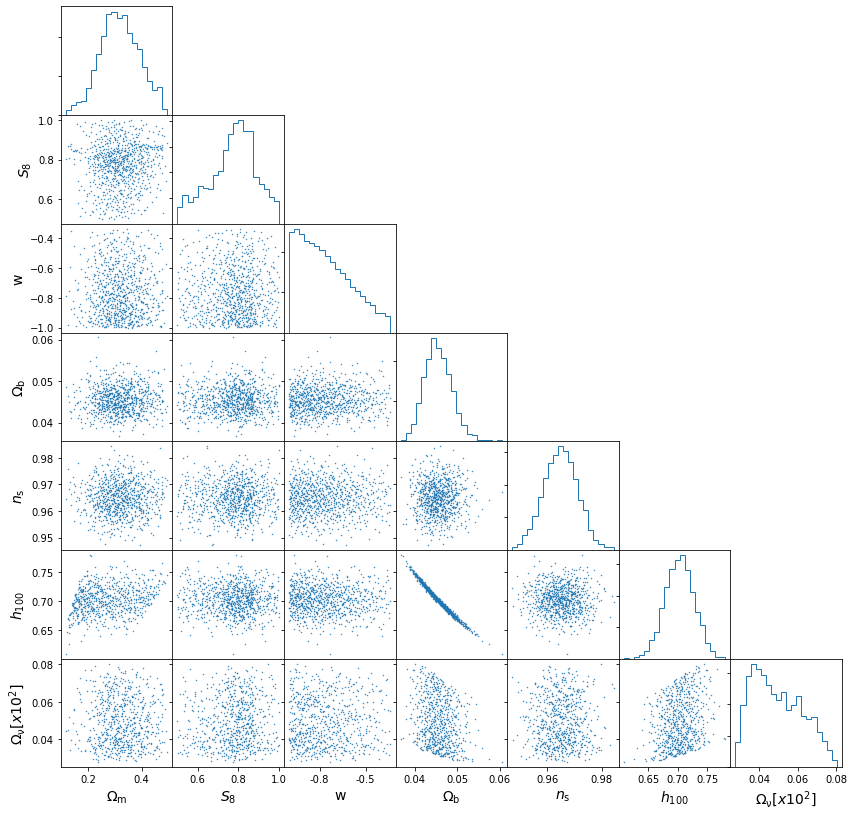

In [20]:
fig, ax = plt.subplots(7,7, figsize=(14,14)) 
plt.subplots_adjust(hspace=0,wspace=0)
for i in range(7):
    for j in range(7):
        if j>i:
            fig.delaxes(ax[i,j])
            
            
for i in range(7):
    for j in range(7):
        if (i!=6) :#or ( j!=0):
                ax[i,j].set_xticklabels([])
                #ax[i,j].set_yticklabels([])
        if (j!=0) :#or ( j!=0):
                ax[i,j].set_yticklabels([])
                
        if (i==0) :#or ( j!=0):
                ax[i,j].set_yticklabels([])
            
#ax[6,0].scatter(om_,S8_,s=0.1)
#ax[6,0].scatter(om_,S8_,s=0.1)
sx = 0.2
ax[0,0].hist(om_,density = True,bins = 20,histtype = 'step')
ax[1,0].scatter(om_,S8_,s=sx)
ax[2,0].scatter(om_,w_,s=sx)
ax[3,0].scatter(om_,ob_,s=sx)
ax[4,0].scatter(om_,ns_,s=sx)
ax[5,0].scatter(m_nu_,h_[mask_nu],s=sx)
ax[6,0].scatter(om_[mask_nu],m_nu_,s=sx)


#ax[1,1].scatter(om_,S8_,s=0.1)
ax[1,1].hist(S8_,density = True,bins = 20,histtype = 'step')
ax[2,1].scatter(S8_,w_,s=sx)
ax[3,1].scatter(S8_,ob_,s=sx)
ax[4,1].scatter(S8_,ns_,s=sx)
ax[5,1].scatter(S8_,h_,s=sx)
ax[6,1].scatter(S8_[mask_nu],m_nu_,s=sx)


ax[2,2].hist(w_,density = True,bins = 20,histtype = 'step')
ax[3,2].scatter(w_,ob_,s=sx)
ax[4,2].scatter(w_,ns_,s=sx)
ax[5,2].scatter(w_,h_,s=sx)
ax[6,2].scatter(w_[mask_nu],m_nu_,s=sx)


ax[3,3].hist(ob_,density = True,bins = 20,histtype = 'step')
ax[4,3].scatter(ob_,ns_,s=sx)
ax[5,3].scatter(ob_,h_,s=sx)
ax[6,3].scatter(ob_[mask_nu],m_nu_,s=sx)


ax[4,4].hist(ns_,density = True,bins = 20,histtype = 'step')
ax[5,4].scatter(ns_,h_,s=sx)
ax[6,4].scatter(ns_[mask_nu],m_nu_,s=sx)


ax[5,5].hist(h_,density = True,bins = 20,histtype = 'step')
ax[6,5].scatter(h_[mask_nu],m_nu_,s=sx)


ax[6,6].hist(m_nu_,density = True,bins = 20,histtype = 'step')

ax[1,0].set_ylabel(r'$S_{8}$',fontsize=14)
ax[2,0].set_ylabel(r'w',fontsize=14)
ax[3,0].set_ylabel(r'$\Omega_{\rm b}$',fontsize=14)
ax[4,0].set_ylabel(r'$n_{\rm s}$',fontsize=14)
ax[5,0].set_ylabel(r'$h_{\rm 100}$',fontsize=14)
ax[6,0].set_ylabel(r'$\Omega_{\rm \nu} [x10^2]$',fontsize=14)


ax[6,0].set_xlabel(r'$\Omega_{\rm m}$',fontsize=14)
ax[6,1].set_xlabel(r'$S_{8}$',fontsize=14)
ax[6,2].set_xlabel(r'w',fontsize=14)
ax[6,3].set_xlabel(r'$\Omega_{\rm b}$',fontsize=14)
ax[6,4].set_xlabel(r'$n_{\rm s}$',fontsize=14)
ax[6,5].set_xlabel(r'$h_{\rm 100}$',fontsize=14)
ax[6,6].set_xlabel(r'$\Omega_{\rm \nu} [x10^2]$',fontsize=14)

ax[6,2].set_xticks([-0.8,-0.5])
ax[6,2].set_xticklabels([-0.8,-0.5])
plt.savefig('/global/homes/m/mgatti/Mass_Mapping/peaks/figures/Dirac_parameter_space.pdf',bbox_inches='tight')


In [21]:
mask_bins = dict()
mask_bins['2nd_moments'] = dict()
mask_bins['3rd_moments'] = dict()
mask_bins['ST_S1'] = dict()
mask_bins['ST_S2'] = dict()
mask_bins['PWH_Gauss'] = dict()
mask_bins['PWH_S01'] = dict()
mask_bins['PWH_S00'] = dict()

mask_bins['2nd_moments'][0] = np.array([('0_0' in bins_2_lb_    ) for bins_2_lb_ in np.array(bins_2_lb).flatten()])
mask_bins['2nd_moments'][1] = np.array([('1_1' in bins_2_lb_    ) for bins_2_lb_ in np.array(bins_2_lb).flatten()])
mask_bins['2nd_moments'][2] = np.array([('2_2' in bins_2_lb_    ) for bins_2_lb_ in np.array(bins_2_lb).flatten()])
mask_bins['2nd_moments'][3] = np.array([('3_3' in bins_2_lb_    ) for bins_2_lb_ in np.array(bins_2_lb).flatten()])

mask_bins['3rd_moments'][0] = np.array([('0_0_0' in bins_2_lb_    ) for bins_2_lb_ in np.array(bins_3_lb).flatten()])
mask_bins['3rd_moments'][1] = np.array([('1_1_1' in bins_2_lb_    ) for bins_2_lb_ in np.array(bins_3_lb).flatten()])
mask_bins['3rd_moments'][2] = np.array([('2_2_2' in bins_2_lb_    ) for bins_2_lb_ in np.array(bins_3_lb).flatten()])
mask_bins['3rd_moments'][3] = np.array([('3_3_3' in bins_2_lb_    ) for bins_2_lb_ in np.array(bins_3_lb).flatten()])


m_ = np.array(['S1' in s for s in labels_S2_])

mask_bins['ST_S1'][0] = np.array([('bin0' in s) and ('auto_' in s)  for s in labels_S2_[m_]])
mask_bins['ST_S1'][1] = np.array([('bin1' in s) and ('auto_' in s)  for s in labels_S2_[m_]])
mask_bins['ST_S1'][2] = np.array([('bin2' in s) and ('auto_' in s)  for s in labels_S2_[m_]])
mask_bins['ST_S1'][3] = np.array([('bin3' in s) and ('auto_' in s)  for s in labels_S2_[m_]])

m_ = np.array(['S2' in s for s in labels_S2_])
auto_mask_s2 =  ((np.array([s[0] for s in  ST2_labels])) ) ==  ((np.array([s[2] for s in  ST2_labels])) )

mask_bins['ST_S2'][0] = np.array([('bin0' in s) and ('auto_' in s)  for s in labels_S2_[m_]]) & auto_mask_s2
mask_bins['ST_S2'][1] = np.array([('bin1' in s) and ('auto_' in s)  for s in labels_S2_[m_]]) & auto_mask_s2
mask_bins['ST_S2'][2] = np.array([('bin2' in s) and ('auto_' in s)  for s in labels_S2_[m_]]) & auto_mask_s2
mask_bins['ST_S2'][3] = np.array([('bin3' in s) and ('auto_' in s)  for s in labels_S2_[m_]]) & auto_mask_s2


mask_bins['PWH_Gauss'][0] = np.array(np.array(['S11'  in dd for dd in data_labels_pwh])  & np.array(['0'  in dd.split('_')[1] for dd in data_labels_pwh]) & np.array(['0'  in dd.split('_')[2] for dd in data_labels_pwh])) 
mask_bins['PWH_Gauss'][1] = np.array(np.array(['S11'  in dd for dd in data_labels_pwh])  & np.array(['1'  in dd.split('_')[1] for dd in data_labels_pwh]) & np.array(['1'  in dd.split('_')[2] for dd in data_labels_pwh])) 
mask_bins['PWH_Gauss'][2] = np.array(np.array(['S11'  in dd for dd in data_labels_pwh])  & np.array(['2'  in dd.split('_')[1] for dd in data_labels_pwh]) & np.array(['2'  in dd.split('_')[2] for dd in data_labels_pwh])) 
mask_bins['PWH_Gauss'][3] = np.array(np.array(['S11'  in dd for dd in data_labels_pwh])  & np.array(['3'  in dd.split('_')[1] for dd in data_labels_pwh]) & np.array(['3'  in dd.split('_')[2] for dd in data_labels_pwh])) 


mask_bins['PWH_S01'][0] = np.array(np.array(['S01'  in dd for dd in data_labels_pwh])  & np.array(['0'  in dd.split('_')[1] for dd in data_labels_pwh]) & np.array(['0'  in dd.split('_')[2] for dd in data_labels_pwh])) 
mask_bins['PWH_S01'][1] = np.array(np.array(['S01'  in dd for dd in data_labels_pwh])  & np.array(['1'  in dd.split('_')[1] for dd in data_labels_pwh]) & np.array(['1'  in dd.split('_')[2] for dd in data_labels_pwh])) 
mask_bins['PWH_S01'][2] = np.array(np.array(['S01'  in dd for dd in data_labels_pwh])  & np.array(['2'  in dd.split('_')[1] for dd in data_labels_pwh]) & np.array(['2'  in dd.split('_')[2] for dd in data_labels_pwh])) 
mask_bins['PWH_S01'][3] = np.array(np.array(['S01'  in dd for dd in data_labels_pwh])  & np.array(['3'  in dd.split('_')[1] for dd in data_labels_pwh]) & np.array(['3'  in dd.split('_')[2] for dd in data_labels_pwh])) 

mask_bins['PWH_S00'][0] = np.array(np.array(['S00'  in dd for dd in data_labels_pwh])  & np.array(['0'  in dd.split('_')[1] for dd in data_labels_pwh]) & np.array(['0'  in dd.split('_')[2] for dd in data_labels_pwh])) 
mask_bins['PWH_S00'][1] = np.array(np.array(['S00'  in dd for dd in data_labels_pwh])  & np.array(['1'  in dd.split('_')[1] for dd in data_labels_pwh]) & np.array(['1'  in dd.split('_')[2] for dd in data_labels_pwh])) 
mask_bins['PWH_S00'][2] = np.array(np.array(['S00'  in dd for dd in data_labels_pwh])  & np.array(['2'  in dd.split('_')[1] for dd in data_labels_pwh]) & np.array(['2'  in dd.split('_')[2] for dd in data_labels_pwh])) 
mask_bins['PWH_S00'][3] = np.array(np.array(['S00'  in dd for dd in data_labels_pwh])  & np.array(['3'  in dd.split('_')[1] for dd in data_labels_pwh]) & np.array(['3'  in dd.split('_')[2] for dd in data_labels_pwh])) 


(399, 160)

In [26]:
# make covariance
for key in mask_bins.keys():
    for t in range(4):
        njck = 399
        if key == '2nd_moments':
            dd_ = np.array(Dall_dict['data'][key])[:,:80][:,mask_bins[key][t]]
            dd = covariance_jck(dd_.T,njck,'bootstrap')
        
        elif key == 'PWH_S01':
            mask = masks['C01']
            dd_ = np.array(Dall_dict['data'][key])[:,:][:,mask_bins[key][t][mask]]
            dd = covariance_jck(dd_.T,njck,'bootstrap')
        elif key == 'PWH_S00':
            mask = masks['S00']
            dd_ = np.array(Dall_dict['data'][key])[:,:][:,mask_bins[key][t][mask]]
            dd = covariance_jck(dd_.T,njck,'bootstrap')
            
        elif key == 'PWH_Gauss':
            mask = masks['G_allscales']
            dd_ = np.array(Dall_dict['data'][key])[:,:60][:,mask_bins[key][t][mask]]
            dd = covariance_jck(dd_.T,njck,'bootstrap')
        else:
            dd_ = np.array(Dall_dict['data'][key])[:,:][:,mask_bins[key][t]]
            dd = covariance_jck(dd_.T,njck,'bootstrap')
    
        print (key+' '+str(t)+' {0:2.2f}'.format(np.sqrt((np.matmul(np.mean(dd_,axis=0),np.matmul(np.linalg.inv(dd['cov']),np.mean(dd_,axis=0)))))))

2nd_moments 0 3.91
2nd_moments 1 7.75
2nd_moments 2 16.62
2nd_moments 3 13.69
3rd_moments 0 0.70
3rd_moments 1 1.35
3rd_moments 2 2.54
3rd_moments 3 1.95
ST_S1 0 3.36
ST_S1 1 7.65
ST_S1 2 16.31
ST_S1 3 14.41
ST_S2 0 3.28
ST_S2 1 7.29
ST_S2 2 15.86
ST_S2 3 13.71
PWH_Gauss 0 3.37
PWH_Gauss 1 7.13
PWH_Gauss 2 15.88
PWH_Gauss 3 13.03
PWH_S01 0 0.48
PWH_S01 1 1.19
PWH_S01 2 2.52
PWH_S01 3 2.14
PWH_S00 0 3.19
PWH_S00 1 6.75
PWH_S00 2 15.21
PWH_S00 3 12.30


In [14]:
1

1

In [27]:
# make covariance
err_dict = dict()
mean_dict = dict()
count = 0
keys_ = ['2nd_moments', '3rd_moments',  'PWH_Gauss','PWH_S00', 'PWH_S01','ST_S1', 'ST_S2']
#keys_ = ['2nd_moments', '3rd_moments',  'PWH_Gauss', 'PWH_S01', 'ST_S1', 'ST_S2']

for key in keys_:
    err_dict[key] = dict()
    mean_dict[key] = dict()
for key in keys_:
    for t in [0,1,2,3]:
        
        njck = 399
        if key == '2nd_moments':
            dd_ = np.array(Dall_dict['data'][key])[:,:80][:,mask_bins[key][t]]
            #dd = covariance_jck(dd_.T,njck,'bootstrap')
        
        elif key == 'PWH_S01':
            mask = masks['C01']
            dd_ = np.array(Dall_dict['data'][key])[:,:][:,mask_bins[key][t][mask]]
            #dd = covariance_jck(dd_.T,njck,'bootstrap')
        elif key == 'PWH_S00':
            mask = masks['S00']
            dd_ = np.array(Dall_dict['data'][key])[:,:][:,mask_bins[key][t][mask]]
            #dd = covariance_jck(dd_.T,njck,'bootstrap')
            
        elif key == 'PWH_Gauss':
            mask = masks['G_allscales']
            dd_ = np.array(Dall_dict['data'][key])[:,:60][:,mask_bins[key][t][mask]]
            #dd = covariance_jck(dd_.T,njck,'bootstrap')
        elif key == 'ST_S2':
            mask = masks['G_allscales']
            dd_ = np.array(Dall_dict['data'][key])[:,:][:,mask_bins[key][t]]
            dd_ = np.mean(dd_.reshape(njck,-1,3),axis=2)
          #  dv = np.mean(dv.reshape(6,3),axis=1)
    
            #dd = covariance_jck(dd_.T,njck,'bootstrap')
            
        else:
            dd_ = np.array(Dall_dict['data'][key])[:,:][:,mask_bins[key][t]]
            #dd = covariance_jck(dd_.T,njck,'bootstrap')
    
    
    #dv = (Ball_dict['data'][key]['dv']/Call_dict['data'][key]['dv'])[mask_bins[key][t]]
        
        dd_temp = covariance_jck(dd_.T,njck,'bootstrap')
        err_dict[key][t] = dd_temp['err']
        mean_dict[key][t]  =  np.mean(dd_,axis=0)
    
        if t == 3:
            if count == 0:
                dv_tot = dd_
            else:
                dv_tot = np.hstack([dv_tot,dd_])
            count +=1
        #print (key+' '+str(t)+' {0:2.2f}'.format(np.sqrt((np.matmul(np.mean(dd_,axis=0),np.matmul(np.linalg.inv(dd['cov']),np.mean(dd_,axis=0)))))))

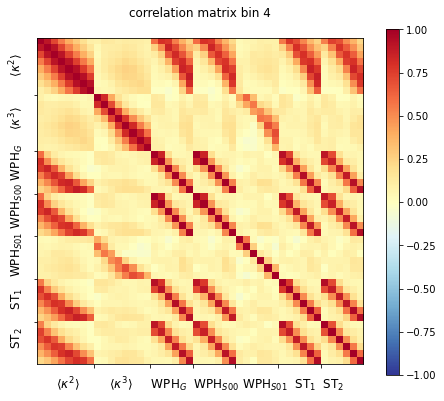

In [28]:
cov = covariance_jck(dv_tot.T,njck,'bootstrap')
crr = (cov['corr'])


fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (9,6))
plt.title("correlation matrix bin 4\n")
im = ax.imshow(crr, vmin=-1, vmax=1,cmap = 'RdYlBu_r')

# Make an axis for the colorbar on the right side
cax = fig.add_axes([0.8, 0.1, 0.02, 0.8])
fig.colorbar(im, cax=cax)

ax.set_xticks([7.5,15.5,21.5,27.5,33.5,39.5]),ax.set_yticks([7.5,15.5,21.5,27.5,33.5,39.5])

labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
labels = [item.get_text() for item in ax.get_yticklabels()]


ax.set_yticklabels(labels)

#ax.set_ylabel("T17")
#ax.set_xlabel(r"$\langle\kappa^2\rangle$        $\langle\kappa^3\rangle$     PWH$_G$  PWH$_{S01}$  ST$_1$  ST$_2$",fontsize=12)
#ax.set_ylabel(r"ST$_2$     ST$_1$   PWH$_{S01}$ PWH$_G$    $\langle\kappa^3\rangle$        $\langle\kappa^2\rangle$",fontsize=12)


ax.set_xlabel(r"$\langle\kappa^2\rangle$        $\langle\kappa^3\rangle$     WPH$_G$  WPH$_{S00}$ WPH$_{S01}$  ST$_1$  ST$_2$",fontsize=12)
ax.set_ylabel(r"ST$_2$     ST$_1$   WPH$_{S01}$ WPH$_{S00}$ WPH$_G$    $\langle\kappa^3\rangle$        $\langle\kappa^2\rangle$",fontsize=12)

plt.savefig("/global/u2/m/mgatti/Mass_Mapping/peaks/figures/corr.pdf",bbox_inches='tight')



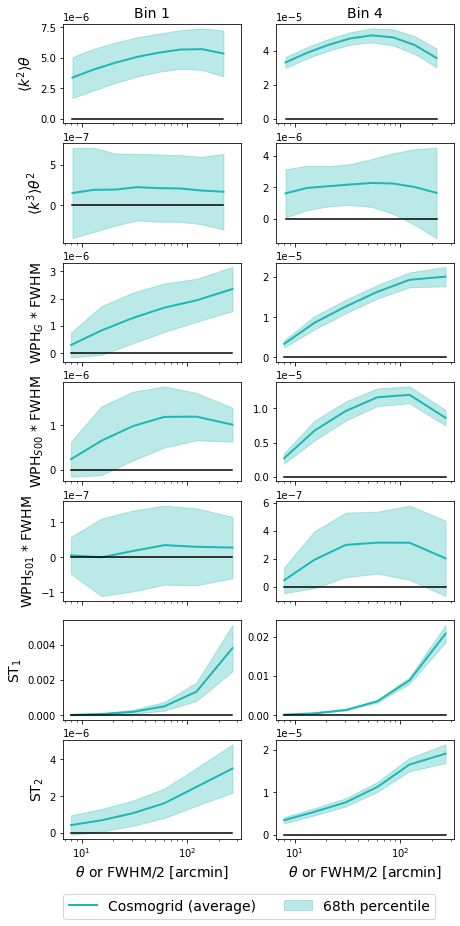

In [29]:
f = glob.glob('/global/cfs/cdirs/des/mgatti/Dirac/LFI_dv_cosmogrid_fiducial/moments/*')
len(f)

bin1 = 2
bin2 = 3
dv_tot = []
# compute SN ---------
data = True
import matplotlib.pyplot as plt
fig, ax = plt.subplots(7,2,sharex=True,sharey=False, figsize=(7,6*2.5)) 

ll = 2
scales_moments = np.array(scales_moments)
key = '2nd_moments'
for ti,t in enumerate([0,3]):
    ax[0,ti].plot(scales_moments,scales_moments*mean_dict[key][t],color=c_4,linewidth=ll)
    ax[0,ti].fill_between(scales_moments,scales_moments*(mean_dict[key][t]-err_dict[key][t]),scales_moments*(mean_dict[key][t]+err_dict[key][t]),color=c_4,alpha=0.3)
    ax[0,ti].plot(scales_moments,0.*np.array(scales_moments),color='black')
    ax[0,ti].set_xscale('log')

key = '3rd_moments'
for ti,t in enumerate([0,3]):
    ax[1,ti].plot(scales_moments,scales_moments**2*mean_dict[key][t],color=c_4,linewidth=ll)
    ax[1,ti].fill_between(scales_moments,scales_moments**2*(mean_dict[key][t]-err_dict[key][t]),scales_moments**2*(mean_dict[key][t]+err_dict[key][t]),color=c_4,alpha=0.3)
    ax[1,ti].plot(scales_moments,0.*np.array(scales_moments),color='black')
    ax[1,ti].set_xscale('log')

    
scales_pwh = np.array([15.89778201,  30.86645692,  61.14795417, 121.8965777 ,245.20035405, 537.89815792])/2.

key = 'PWH_Gauss'
for ti,t in enumerate([0,3]):
    ax[2,ti].plot(scales_pwh,scales_pwh*mean_dict[key][t],color=c_4,linewidth=ll)
    ax[2,ti].fill_between(scales_pwh,scales_pwh*(mean_dict[key][t]-err_dict[key][t]),scales_pwh*(mean_dict[key][t]+err_dict[key][t]),color=c_4,alpha=0.3)
    ax[2,ti].plot(scales_pwh,0.*np.array(scales_pwh),color='black')
    ax[2,ti].set_xscale('log')

    
key = 'PWH_S00'
for ti,t in enumerate([0,3]):
    ax[3,ti].plot(scales_pwh,scales_pwh*mean_dict[key][t],color=c_4,linewidth=ll)
    ax[3,ti].fill_between(scales_pwh,scales_pwh*(mean_dict[key][t]-err_dict[key][t]),scales_pwh*(mean_dict[key][t]+err_dict[key][t]),color=c_4,alpha=0.3)
    ax[3,ti].plot(scales_pwh,0.*np.array(scales_pwh),color='black')
    ax[3,ti].set_xscale('log')

    
key = 'PWH_S01'
for ti,t in enumerate([0,3]):
    ax[4,ti].plot(scales_pwh,scales_pwh*mean_dict[key][t],color=c_4,linewidth=ll)
    ax[4,ti].fill_between(scales_pwh,scales_pwh*(mean_dict[key][t]-err_dict[key][t]),scales_pwh*(mean_dict[key][t]+err_dict[key][t]),color=c_4,alpha=0.3)
    ax[4,ti].plot(scales_pwh,0.*np.array(scales_pwh),color='black')
    ax[4,ti].set_xscale('log')

    
    
key = 'ST_S1'
for ti,t in enumerate([0,3]):
    ax[5,ti].plot(scales_pwh,scales_pwh*mean_dict[key][t],color=c_4,linewidth=ll)
    ax[5,ti].fill_between(scales_pwh,scales_pwh*(mean_dict[key][t]-err_dict[key][t]),scales_pwh*(mean_dict[key][t]+err_dict[key][t]),color=c_4,alpha=0.3)
    ax[5,ti].plot(scales_pwh,0.*np.array(scales_pwh),color='black')
    ax[5,ti].set_xscale('log')

    
    
key = 'ST_S2'
for ti,t in enumerate([0,3]):
    ax[6,ti].plot(scales_pwh,mean_dict[key][t],color=c_4,linewidth=ll,label = 'Cosmogrid (average)')
    ax[6,ti].fill_between(scales_pwh,(mean_dict[key][t]-err_dict[key][t]),(mean_dict[key][t]+err_dict[key][t]),color=c_4,alpha=0.3,label = '68th percentile')
    ax[6,ti].plot(scales_pwh,0.*np.array(scales_pwh),color='black')
    ax[6,ti].set_xscale('log')
    
    
ax[6,0].set_xlabel(r'$\theta$ or FWHM/2 [arcmin]',fontsize=14)
ax[6,1].set_xlabel(r'$\theta$ or FWHM/2 [arcmin]',fontsize=14)


ax[0,0].set_title('Bin 1',fontsize=14)
ax[0,1].set_title('Bin 4',fontsize=14)

ax[0,0].set_ylabel(r'$\langle{k^2}\rangle \theta $',fontsize=14)
ax[1,0].set_ylabel(r'$\langle{k^3}\rangle \theta^2 $',fontsize=14)
ax[2,0].set_ylabel('WPH$_{G}$ * FWHM',fontsize=14)
ax[3,0].set_ylabel('WPH$_{S00}$ * FWHM',fontsize=14)
ax[4,0].set_ylabel('WPH$_{S01}$ * FWHM',fontsize=14)
ax[5,0].set_ylabel('ST$_{1}$',fontsize=14)
ax[6,0].set_ylabel('ST$_{2}$',fontsize=14)

ax[6,1].legend(loc=(-1.2, -0.8),ncol=2,fontsize=14)

plt.savefig("/global/u2/m/mgatti/Mass_Mapping/peaks/figures/DV.pdf",bbox_inches='tight')



In [86]:
mb = load_obj('/global/cfs/cdirs/des/mgatti/Moments_analysis/baryons_data_vector')
mt = load_obj('/global/cfs/cdirs/des/mgatti/Moments_analysis/theory_data_vector')
smoothing_scales = np.array([3.2,5.1,8.2,13.1,21.0,33.6,54.,86.,138,221])
# corrects for the pixel function --- 
key = '2nd_moments'
for t in range(4):
    r = (mb['{0}_{0}'.format(t)]/mt['{0}_{0}'.format(t)])[2:]
    
    rm = (Ball_dict['data'][key]['dv']/Call_dict['data'][key]['dv'])[:80][mask_bins[key][t]]
    
    rm[0]/rm[1]*r[1]

    mb['{0}_{0}'.format(t)][2] = rm[0]/rm[1]*r[1]*mt['{0}_{0}'.format(t)][2]


/global/homes/m/mgatti/.conda/envs/bfd_env3/lib/python3.6/site-packages/ipykernel_launcher.py:296: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


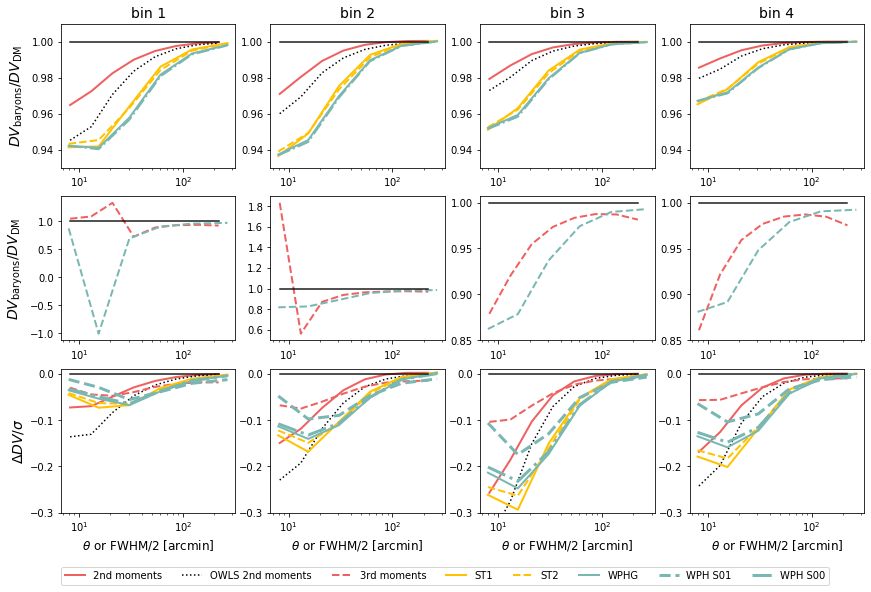

In [128]:
# baryons plot ----
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3,4,sharex='row',sharey=False, figsize=(12*1.2,5*1.2*3/2)) 




# ------------------------------------------------------------------------------------------

key = '2nd_moments'
ds = '-'
ll = 2
for t in range(4):
    dv = (Ball_dict['data'][key]['dv']/Call_dict['data'][key]['dv'])[:80][mask_bins[key][t]]
    ax[0,t].plot(scales_moments,dv,color=c_2, linestyle = ds,linewidth=ll,label = '2nd moments')

    uu = (mb['{0}_{0}'.format(t)]/mt['{0}_{0}'.format(t)])[2:]
    ax[0,t].plot(smoothing_scales[2:],uu,color='black', linestyle = 'dotted', label = 'OWLS 2nd moments')
    


    

# ------------------------------------------------------------------------------------------
scales_pwh = np.array([15.89778201,  30.86645692,  61.14795417, 121.8965777 ,245.20035405, 537.89815792])/2.

key = 'ST_S1'
ds = '-'


for t in range(4):
    dv = (Ball_dict['data'][key]['dv']/Call_dict['data'][key]['dv'])[mask_bins[key][t]]
    ax[0,t].plot(scales_pwh,dv,color=c5, linestyle = ds,linewidth=ll,label = 'ST1')


# ------------------------------------------------------------------------------------------
#m_ = np.array(['S2' in s for s in labels_S2_])
#masks_dv[key]['mask_ST2'] =  np.array([('bin1' in s) or ('bin0' in s) or ('bin10' in s) or ('bin01' in s) for s in labels_S2_[m_]])

key = 'ST_S2'
ds = '--'


for t in range(4):
    dv = (Ball_dict['data'][key]['dv']/Call_dict['data'][key]['dv'])[mask_bins[key][t]]
    dv = np.mean(dv.reshape(6,3),axis=1)
    ax[0,t].plot(scales_pwh,dv,color=c5, linestyle = ds,linewidth=ll,label = 'ST2')


# ------------------------------------------------------------------------------------------
#m_ = np.array(['S2' in s for s in labels_S2_])
#masks_dv[key]['mask_ST2'] =  np.array([('bin1' in s) or ('bin0' in s) or ('bin10' in s) or ('bin01' in s) for s in labels_S2_[m_]])

key = 'PWH_Gauss'
ds = '-'


for t in range(4):
    mask = masks['G_allscales']
    dv = (Ball_dict['data'][key]['dv']/Call_dict['data'][key]['dv'])[:60][mask_bins[key][t][mask]]
    ax[0,t].plot(scales_pwh,dv,color=c_4, linestyle = ds,linewidth=ll,label = 'WPHG')



# ------------------------------------------------------------------------------------------
#m_ = np.array(['S2' in s for s in labels_S2_])
#masks_dv[key]['mask_ST2'] =  np.array([('bin1' in s) or ('bin0' in s) or ('bin10' in s) or ('bin01' in s) for s in labels_S2_[m_]])



key = 'PWH_S00'
ds = '-.'


for t in range(4):
    mask = masks['S00']
    dv = (Ball_dict['data'][key]['dv']/Call_dict['data'][key]['dv'])[mask_bins[key][t][mask]]
    ax[0,t].plot(scales_pwh,dv,color=c_4, linestyle = ds,linewidth=ll,label = 'WPH S00')






    
    
    
# ------------------------------------------------------------------------------------------
key = '3rd_moments'
ds = '--'

for t in range(4):
    dv = (Ball_dict['data'][key]['dv']/Call_dict['data'][key]['dv'])[mask_bins[key][t]]
    ax[1,t].plot(scales_moments,dv,color=c_2, linestyle = ds,linewidth=ll,label = '3rd moments')

key = 'PWH_S01'
ds = '--'


for t in range(4):
    mask = masks['C01']
    dv = (Ball_dict['data'][key]['dv']/Call_dict['data'][key]['dv'])[mask_bins[key][t][mask]]
    ax[1,t].plot(scales_pwh,dv,color=c_4, linestyle = ds,linewidth=ll,label = 'WPH S01')

 
    
    
    
    
    
    
    
    
    
    
    
# ------------------------------------------------------------------------------------------
u = 2
key = '2nd_moments'
ds = '-'

for t in range(4):
    dv = ((Ball_dict['data'][key]['dv']-Call_dict['data'][key]['dv'])[:80][mask_bins[key][t]])/err_dict[key][t]
    ax[u,t].plot(scales_moments,dv,color=c_2, linestyle = ds,linewidth=ll,label = '2nd moments')

    uu = (mb['{0}_{0}'.format(t)]-mt['{0}_{0}'.format(t)])[2:]/err_dict[key][t]
    ax[u,t].plot(smoothing_scales[2:],uu,color='black', linestyle = 'dotted', label = 'OWLS 2nd moments')
    

# ------------------------------------------------------------------------------------------
key = '3rd_moments'
ds = '--'

for t in range(4):
    dv = ((Ball_dict['data'][key]['dv']-Call_dict['data'][key]['dv'])[mask_bins[key][t]])/err_dict[key][t]
    ax[u,t].plot(scales_moments,dv,color=c_2, linestyle = ds,linewidth=ll,label = '3rd moments')


# ------------------------------------------------------------------------------------------
scales_pwh = np.array([15.89778201,  30.86645692,  61.14795417, 121.8965777 ,245.20035405, 537.89815792])/2.

key = 'ST_S1'
ds = '-'


for t in range(4):
    dv = ((Ball_dict['data'][key]['dv']-Call_dict['data'][key]['dv'])[mask_bins[key][t]])/err_dict[key][t]
    ax[u,t].plot(scales_pwh,dv,color=c5, linestyle = ds,linewidth=ll,label = 'ST1')


# ------------------------------------------------------------------------------------------
#m_ = np.array(['S2' in s for s in labels_S2_])
#masks_dv[key]['mask_ST2'] =  np.array([('bin1' in s) or ('bin0' in s) or ('bin10' in s) or ('bin01' in s) for s in labels_S2_[m_]])

key = 'ST_S2'
ds = '--'


for t in range(4):
    dv = ((Ball_dict['data'][key]['dv']-Call_dict['data'][key]['dv'])[mask_bins[key][t]])
    dv = np.mean(dv.reshape(6,3),axis=1)/err_dict[key][t]
    ax[u,t].plot(scales_pwh,dv,color=c5, linestyle = ds,linewidth=ll,label = 'ST2')


# ------------------------------------------------------------------------------------------
#m_ = np.array(['S2' in s for s in labels_S2_])
#masks_dv[key]['mask_ST2'] =  np.array([('bin1' in s) or ('bin0' in s) or ('bin10' in s) or ('bin01' in s) for s in labels_S2_[m_]])

key = 'PWH_Gauss'
ds = '-'


for t in range(4):
    mask = masks['G_allscales']
    dv = ((Ball_dict['data'][key]['dv']-Call_dict['data'][key]['dv'])[:60][mask_bins[key][t][mask]])/err_dict[key][t]
    ax[u,t].plot(scales_pwh,dv,color=c_4, linestyle = ds,linewidth=ll,label = 'WPHG')



# ------------------------------------------------------------------------------------------
#m_ = np.array(['S2' in s for s in labels_S2_])
#masks_dv[key]['mask_ST2'] =  np.array([('bin1' in s) or ('bin0' in s) or ('bin10' in s) or ('bin01' in s) for s in labels_S2_[m_]])

key = 'PWH_S01'
ds = '--'
ll = 3

for t in range(4):
    mask = masks['C01']
    dv = ((Ball_dict['data'][key]['dv']-Call_dict['data'][key]['dv'])[mask_bins[key][t][mask]])/err_dict[key][t]
    ax[u,t].plot(scales_pwh,dv,color=c_4, linestyle = ds,linewidth=ll,label = 'WPH S01')



key = 'PWH_S00'
ds = '-.'


for t in range(4):
    mask = masks['S00']
    dv = ((Ball_dict['data'][key]['dv']-Call_dict['data'][key]['dv'])[mask_bins[key][t][mask]])/err_dict[key][t]
    ax[u,t].plot(scales_pwh,dv,color=c_4, linestyle = ds,linewidth=ll,label = 'WPH S00')


    
#ax[0,0].legend(loc=(0.25, -1.8),ncol=6)

#plt.yscale('log')
'''
for i in range(4):
    ax[0,i].plot(scales_moments,np.ones(len(scales_moments)),color='black',alpha=0.9)
    ax[1,i].plot(scales_moments,np.zeros(len(scales_moments)),color='black',alpha=0.9)
    ax[0,i].set_xscale('log')
    ax[1,i].set_xscale('log')
#plt.tight_layout()
ax[0,0].set_ylim([0.5,1.2])
ax[0,1].set_ylim([0.5,1.2])
ax[0,2].set_ylim([0.5,1.2])


ax[1,0].set_ylim([-0.3,0.05])
ax[1,1].set_ylim([-0.3,0.05])
ax[1,2].set_ylim([-0.3,0.05])


ax[0,0].set_title('bins 11 (or 111)', fontsize = 14)
ax[0,1].set_title('bins 13 (or 113)', fontsize = 14)
ax[0,2].set_title('bins 33 (or 333)', fontsize = 14)

ax[0,0].set_ylabel(r'$DV_{\rm SC}/DV_{\rm no SC}$', fontsize = 14)
ax[1,0].set_ylabel(r'$\Delta DV / \sigma$', fontsize = 14)


ax[1,0].set_xlabel(r'$\theta$ or FWHM/2 [arcmin]', fontsize = 12)
ax[1,1].set_xlabel(r'$\theta$ or FWHM/2 [arcmin]', fontsize = 12)
ax[1,2].set_xlabel(r'$\theta$ or FWHM/2 [arcmin]', fontsize = 12)
'''



ax[u,0].legend(loc=(-0., -0.5),ncol=8)

#plt.yscale('log')

for i in range(4):
    ax[0,i].plot(scales_moments,np.ones(len(scales_moments)),color='black',alpha=0.9)
    ax[1,i].plot(scales_moments,np.ones(len(scales_moments)),color='black',alpha=0.9)
    ax[u,i].plot(scales_moments,np.zeros(len(scales_moments)),color='black',alpha=0.9)
    ax[0,i].set_xscale('log')
    ax[1,i].set_xscale('log')
    #ax[0,i].set_yscale('log')
    ax[u,i].set_xscale('log')
#plt.tight_layout()
#ax[0,0].set_ylim([0.2,1.5])
#ax[0,1].set_ylim([0.5,1.1])
#ax[0,2].set_ylim([0.8,1.1])
#ax[0,3].set_ylim([0.8,1.1])


ax[0,0].set_ylim([0.93,1.01])
ax[0,1].set_ylim([0.93,1.01])
ax[0,2].set_ylim([0.93,1.01])
ax[0,3].set_ylim([0.93,1.01])
#
#
#
ax[u,0].set_ylim([-0.3,0.01])
ax[u,1].set_ylim([-0.3,0.01])
ax[u,2].set_ylim([-0.3,0.01])
ax[u,3].set_ylim([-0.3,0.01])

ax[u,0].set_yticks([-0.3,-0.2,-0.1,0.0])
ax[u,1].set_yticks([-0.3,-0.2,-0.1,0.0])
ax[u,2].set_yticks([-0.3,-0.2,-0.1,0.0])
ax[u,3].set_yticks([-0.3,-0.2,-0.1,0.0])


ax[1,2].set_yticks([0.85,0.90,0.95,1.0])
ax[1,3].set_yticks([0.85,0.90,0.95,1.0])


ax[0,0].set_title('bin 1', fontsize = 14)
ax[0,1].set_title('bin 2', fontsize = 14)
ax[0,2].set_title('bin 3', fontsize = 14)
ax[0,3].set_title('bin 4', fontsize = 14)

ax[0,0].set_ylabel(r'$DV_{\rm baryons}/DV_{\rm DM}$', fontsize = 14)
ax[1,0].set_ylabel(r'$DV_{\rm baryons}/DV_{\rm DM}$', fontsize = 14)
ax[u,0].set_ylabel(r'$\Delta DV / \sigma$', fontsize = 14)


ax[u,0].set_xlabel(r'$\theta$ or FWHM/2 [arcmin]', fontsize = 12)
ax[u,1].set_xlabel(r'$\theta$ or FWHM/2 [arcmin]', fontsize = 12)
ax[u,2].set_xlabel(r'$\theta$ or FWHM/2 [arcmin]', fontsize = 12)
ax[u,3].set_xlabel(r'$\theta$ or FWHM/2 [arcmin]', fontsize = 12)
plt.tight_layout()

plt.savefig("/global/u2/m/mgatti/Mass_Mapping/peaks/figures/baryons_new.pdf",bbox_inches='tight')


Text(0.5, 0, '$\\theta$ or FWHM/2 [arcmin]')

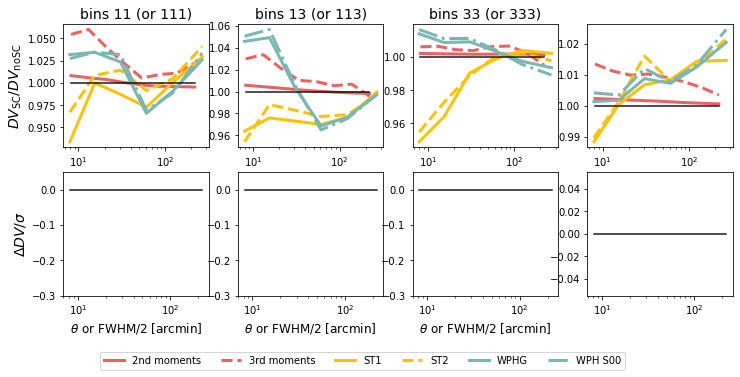

In [146]:
# baryons plot ----
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,4,sharex='row',sharey=False, figsize=(12,5)) 




# ------------------------------------------------------------------------------------------
key = '2nd_moments'
ds = '-'
ll = 3
for t in range(4):
    dv = (Sall_dict['data'][key]['dv']/Rall_dict['data'][key]['dv'])[:80][mask_bins[key][t]]
    ax[0,t].plot(scales_moments,dv,color=c_2, linestyle = ds,linewidth=ll,label = '2nd moments')



# ------------------------------------------------------------------------------------------
key = '3rd_moments'
ds = '--'
ll = 3
for t in range(4):
    dv = (Sall_dict['data'][key]['dv']/Rall_dict['data'][key]['dv'])[mask_bins[key][t]]
    ax[0,t].plot(scales_moments,dv,color=c_2, linestyle = ds,linewidth=ll,label = '3rd moments')

# ------------------------------------------------------------------------------------------
scales_pwh = np.array([15.89778201,  30.86645692,  61.14795417, 121.8965777 ,245.20035405, 537.89815792])/2.

key = 'ST_S1'
ds = '-'
ll = 3

for t in range(4):
    dv = (Sall_dict['data'][key]['dv']/Rall_dict['data'][key]['dv'])[mask_bins[key][t]]
    ax[0,t].plot(scales_pwh,dv,color=c5, linestyle = ds,linewidth=ll,label = 'ST1')


# ------------------------------------------------------------------------------------------
#m_ = np.array(['S2' in s for s in labels_S2_])
#masks_dv[key]['mask_ST2'] =  np.array([('bin1' in s) or ('bin0' in s) or ('bin10' in s) or ('bin01' in s) for s in labels_S2_[m_]])

key = 'ST_S2'
ds = '--'
ll = 3

for t in range(4):
    dv = (Sall_dict['data'][key]['dv']/Rall_dict['data'][key]['dv'])[mask_bins[key][t]]
    dv = np.mean(dv.reshape(6,3),axis=1)
    ax[0,t].plot(scales_pwh,dv,color=c5, linestyle = ds,linewidth=ll,label = 'ST2')


# ------------------------------------------------------------------------------------------
#m_ = np.array(['S2' in s for s in labels_S2_])
#masks_dv[key]['mask_ST2'] =  np.array([('bin1' in s) or ('bin0' in s) or ('bin10' in s) or ('bin01' in s) for s in labels_S2_[m_]])

key = 'PWH_Gauss'
ds = '-'
ll = 3

for t in range(4):
    mask = masks['G_allscales']
    dv = (Sall_dict['data'][key]['dv']/Rall_dict['data'][key]['dv'])[:60][mask_bins[key][t][mask]]
    ax[0,t].plot(scales_pwh,dv,color=c_4, linestyle = ds,linewidth=ll,label = 'WPHG')



# ------------------------------------------------------------------------------------------
#m_ = np.array(['S2' in s for s in labels_S2_])
#masks_dv[key]['mask_ST2'] =  np.array([('bin1' in s) or ('bin0' in s) or ('bin10' in s) or ('bin01' in s) for s in labels_S2_[m_]])

#key = 'PWH_S01'
#ds = '--'
#ll = 3
#
#for t in range(4):
#    mask = masks['C01']
#    dv = (Sall_dict['data'][key]['dv']/Call_dict['data'][key]['dv'])[mask_bins[key][t][mask]]
#    ax[0,t].plot(scales_pwh,dv,color=c_4, linestyle = ds,linewidth=ll,label = 'WPH S01')



key = 'PWH_S00'
ds = '-.'
ll = 3

for t in range(4):
    mask = masks['S00']
    dv = (Sall_dict['data'][key]['dv']/Rall_dict['data'][key]['dv'])[mask_bins[key][t][mask]]
    ax[0,t].plot(scales_pwh,dv,color=c_4, linestyle = ds,linewidth=ll,label = 'WPH S00')






ax[0,0].legend(loc=(0.25, -1.8),ncol=6)

#plt.yscale('log')

for i in range(4):
    ax[0,i].plot(scales_moments,np.ones(len(scales_moments)),color='black',alpha=0.9)
    ax[1,i].plot(scales_moments,np.zeros(len(scales_moments)),color='black',alpha=0.9)
    ax[0,i].set_xscale('log')
    ax[1,i].set_xscale('log')
#plt.tight_layout()
#ax[0,0].set_ylim([0.5,1.2])
#ax[0,1].set_ylim([0.5,1.2])
#ax[0,2].set_ylim([0.5,1.2])


ax[1,0].set_ylim([-0.3,0.05])
ax[1,1].set_ylim([-0.3,0.05])
ax[1,2].set_ylim([-0.3,0.05])


ax[0,0].set_title('bins 11 (or 111)', fontsize = 14)
ax[0,1].set_title('bins 13 (or 113)', fontsize = 14)
ax[0,2].set_title('bins 33 (or 333)', fontsize = 14)

ax[0,0].set_ylabel(r'$DV_{\rm SC}/DV_{\rm no SC}$', fontsize = 14)
ax[1,0].set_ylabel(r'$\Delta DV / \sigma$', fontsize = 14)


ax[1,0].set_xlabel(r'$\theta$ or FWHM/2 [arcmin]', fontsize = 12)
ax[1,1].set_xlabel(r'$\theta$ or FWHM/2 [arcmin]', fontsize = 12)
ax[1,2].set_xlabel(r'$\theta$ or FWHM/2 [arcmin]', fontsize = 12)


In [ ]:
f = glob.glob('/global/cfs/cdirs/des/mgatti/Dirac/LFI_dv/cl_now/*')
len(f)

In [ ]:
# for bins 11,22,33,44 ---

- Baryons
- SC
- PSF contamination
- SN estimates


In [117]:
# load cls_owls.
0

0

In [ ]:


import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,3,sharex='row',sharey=False, figsize=(12,5)) 



ll = 2
# 2nd moments -----------------------------------------
scales_moments = np.array([8.2,13.1,21.0,33.6,54.,86.,138,221.])
f = 1-1/(scales_moments[-1]-scales_moments[0])*scales_moments 


std = np.std(np.array(Ball_dict['data']['2nd_moments']),axis=0)
dv0 = np.mean(np.array(np.array(Ball_dict['data']['2nd_moments'])),axis=0)/np.mean(np.array(np.array(Dall_dict['data']['2nd_moments'])),axis=0)
dv1 = (np.mean(np.array(np.array(Ball_dict['data']['2nd_moments'])),axis=0)- np.mean(np.array(np.array(Dall_dict['data']['2nd_moments'])),axis=0))/std
min_ = 0
max_ = len(scales_moments)
'''
ax[0,0].plot(scales_moments,(dv0)[min_:max_] ,color=c_2,linewidth=ll)
ax[1,0].plot(scales_moments,(dv1)[min_:max_] ,color=c_2,linewidth=ll)

min_ = len(scales_moments)
max_ = 2*len(scales_moments)
ax[0,1].plot(scales_moments,(dv0)[min_:max_] ,color=c_2,linewidth=ll)
ax[1,1].plot(scales_moments,(dv1)[min_:max_] ,color=c_2,linewidth=ll)

min_ = 2*len(scales_moments)
max_ = 3*len(scales_moments)
ax[0,2].plot(scales_moments,(dv0)[min_:max_] ,color=c_2,linewidth=ll)
ax[1,2].plot(scales_moments,(dv1)[min_:max_] ,color=c_2,linewidth=ll)
'''



ds = '-'
min_ = 0
max_ = len(scales_moments)
z = np.polyfit(scales_moments, (dv0)[min_:max_], 2)
ax[0,0].plot(scales_moments,(scales_moments**2*z[0]+scales_moments*z[1]+z[2]-1)*f+1,color=c_2, linestyle = ds,linewidth=ll,label = '2nd moments')
z = np.polyfit(scales_moments, (dv1)[min_:max_], 2)
ax[1,0].plot(scales_moments,(scales_moments**2*z[0]+scales_moments*z[1]+z[2])*f,color=c_2, linestyle = ds,linewidth=ll,label = '2nd moments')

min_ = len(scales_moments)
max_ = 2*len(scales_moments)
z = np.polyfit(scales_moments, (dv0)[min_:max_], 2)
ax[0,1].plot(scales_moments,(scales_moments**2*z[0]+scales_moments*z[1]+z[2]-1)*f +1,color=c_2,linewidth=ll)
z = np.polyfit(scales_moments, (dv1)[min_:max_], 2)
ax[1,1].plot(scales_moments,(scales_moments**2*z[0]+scales_moments*z[1]+z[2])*f ,color=c_2,linewidth=ll)

min_ = 2*len(scales_moments)
max_ = 3*len(scales_moments)
z = np.polyfit(scales_moments, (dv0)[min_:max_], 2)
ax[0,2].plot(scales_moments,(scales_moments**2*z[0]+scales_moments*z[1]+z[2]-1)*f+1 ,color=c_2,linewidth=ll)
z = np.polyfit(scales_moments, (dv1)[min_:max_], 2)
ax[1,2].plot(scales_moments,(scales_moments**2*z[0]+scales_moments*z[1]+z[2])*f ,color=c_2,linewidth=ll)





'''
# 3rd moments -----------------------------------------
ds = 'dashed'

scales_moments = np.array([8.2,13.1,21.0,33.6,54.,86.,138,221.])
std = np.std(np.array(Ball_dict['data']['3rd_moments']),axis=0)
dv0 = np.mean(np.array(np.array(Ball_dict['data']['3rd_moments'])),axis=0)/np.mean(np.array(np.array(Dall_dict['data']['3rd_moments'])),axis=0)
dv1 = (np.mean(np.array(np.array(Ball_dict['data']['3rd_moments'])),axis=0)- np.mean(np.array(np.array(Dall_dict['data']['3rd_moments'])),axis=0))/std
min_ = 0
max_ = len(scales_moments)
z = np.polyfit(scales_moments, (dv0)[min_:max_], 2)
ax[0,0].plot(scales_moments,(dv0)[min_:max_] ,color=c_2, linestyle = ds,linewidth=ll,label = '3rd moments')
ax[1,0].plot(scales_moments,(dv1)[min_:max_] ,color=c_2, linestyle = ds,linewidth=ll,label = '3rd moments')

min_ = len(scales_moments)
max_ = 2*len(scales_moments)
z = np.polyfit(scales_moments, (dv0)[min_:max_], 2)
ax[0,1].plot(scales_moments,(dv0)[min_:max_] ,color=c_2, linestyle = ds,linewidth=ll,label = '3rd moments')
ax[1,1].plot(scales_moments,(dv1)[min_:max_] ,color=c_2, linestyle = ds,linewidth=ll,label = '3rd moments')

min_ = 2*len(scales_moments)
max_ = 3*len(scales_moments)
z = np.polyfit(scales_moments, (dv0)[min_:max_], 2)
ax[0,2].plot(scales_moments,(dv0)[min_:max_] ,color=c_2, linestyle = ds,linewidth=ll,label = '3rd moments')
ax[1,2].plot(scales_moments,(dv1)[min_:max_] ,color=c_2, linestyle = ds,linewidth=ll,label = '3rd moments')

'''



# 3rd moments -----------------------------------------
ds = 'dashed'

scales_moments = np.array([8.2,13.1,21.0,33.6,54.,86.,138,221.])
std = np.std(np.array(Ball_dict['data']['3rd_moments']),axis=0)
dv0 = np.mean(np.array(np.array(Ball_dict['data']['3rd_moments'])),axis=0)/np.mean(np.array(np.array(Dall_dict['data']['3rd_moments'])),axis=0)
dv1 = (np.mean(np.array(np.array(Ball_dict['data']['3rd_moments'])),axis=0)- np.mean(np.array(np.array(Dall_dict['data']['3rd_moments'])),axis=0))/std
min_ = 0
max_ = len(scales_moments)

min_ = 0
max_ = len(scales_moments)
z = np.polyfit(scales_moments, (dv0)[min_:max_], 2)
ax[0,0].plot(scales_moments,(scales_moments**2*z[0]+scales_moments*z[1]+z[2]-1)*f+1,color=c_2, linestyle = ds,linewidth=ll,label = '3rd moments')
z = np.polyfit(scales_moments, (dv1)[min_:max_], 2)
ax[1,0].plot(scales_moments,(scales_moments**2*z[0]+scales_moments*z[1]+z[2])*f,color=c_2, linestyle = ds,linewidth=ll,label = '3rd moments')

min_ = len(scales_moments)
max_ = 2*len(scales_moments)
z = np.polyfit(scales_moments, (dv0)[min_:max_], 2)
ax[0,1].plot(scales_moments,(scales_moments**2*z[0]+scales_moments*z[1]+z[2]-1)*f +1,linestyle = ds,color=c_2,linewidth=ll)
z = np.polyfit(scales_moments, (dv1)[min_:max_], 2)
ax[1,1].plot(scales_moments,(scales_moments**2*z[0]+scales_moments*z[1]+z[2])*f ,linestyle = ds,color=c_2,linewidth=ll)

min_ = 2*len(scales_moments)
max_ = 3*len(scales_moments)
z = np.polyfit(scales_moments, (dv0)[min_:max_], 2)
ax[0,2].plot(scales_moments,(scales_moments**2*z[0]+scales_moments*z[1]+z[2]-1)*f+1 ,linestyle = ds,color=c_2,linewidth=ll)
z = np.polyfit(scales_moments, (dv1)[min_:max_], 2)
ax[1,2].plot(scales_moments,(scales_moments**2*z[0]+scales_moments*z[1]+z[2])*f ,linestyle = ds,color=c_2,linewidth=ll)






ll = 2
ds = '-'

f = 0.95-1/(scales_pwh[-1]-scales_pwh[0])*scales_pwh 


# ST1 -----------------------------------------
scales_pwh = np.array([15.89778201,  30.86645692,  61.14795417, 121.8965777 ,245.20035405, 537.89815792])/2.

std = np.std(np.array(Ball_dict['data']['ST_S1']),axis=0)
dv0 = np.mean(np.array(np.array(Ball_dict['data']['ST_S1'])),axis=0)/np.mean(np.array(np.array(Dall_dict['data']['ST_S1'])),axis=0)
dv1 = (np.mean(np.array(np.array(Ball_dict['data']['ST_S1'])),axis=0)- np.mean(np.array(np.array(Dall_dict['data']['ST_S1'])),axis=0))/std
min_ = 0
max_ = len(scales_pwh)

'''
ax[0,0].plot(scales_pwh,(dv0)[min_:max_] ,color=c5,label = 'ST1', linestyle = ds,linewidth=ll)
ax[1,0].plot(scales_pwh,(dv1)[min_:max_] ,color=c5,label = 'ST1', linestyle = ds,linewidth=ll)

min_ = len(scales_pwh)
max_ = 2*len(scales_pwh)
ax[0,1].plot(scales_pwh,(dv0)[min_:max_] ,color=c5,label = 'ST1', linestyle = ds,linewidth=ll)
ax[1,1].plot(scales_pwh,(dv1)[min_:max_] ,color=c5,label = 'ST1', linestyle = ds,linewidth=ll)

min_ = 2*len(scales_pwh)
max_ = 3*len(scales_pwh)
ax[0,2].plot(scales_pwh,(dv0)[min_:max_] ,color=c5,label = 'ST1', linestyle = ds,linewidth=ll)
ax[1,2].plot(scales_pwh,(dv1)[min_:max_] ,color=c5,label = 'ST1', linestyle = ds,linewidth=ll)
'''

z = np.polyfit(scales_pwh, (dv0)[min_:max_], 2)
ax[0,0].plot(scales_pwh,(scales_pwh**2*z[0]+scales_pwh*z[1]+z[2]-1)*f+1 ,color=c5,label = 'ST1', linestyle = ds,linewidth=ll)
z = np.polyfit(scales_pwh, (dv1)[min_:max_], 2)
ax[1,0].plot(scales_pwh,(scales_pwh**2*z[0]+scales_pwh*z[1]+z[2])*f*0.6 ,color=c5,label = 'ST1', linestyle = ds,linewidth=ll)

min_ = len(scales_pwh)
max_ = 2*len(scales_pwh)
z = np.polyfit(scales_pwh, (dv0)[min_:max_], 2)
ax[0,1].plot(scales_pwh,(scales_pwh**2*z[0]+scales_pwh*z[1]+z[2]-1)*f+1 ,color=c5,label = 'ST1', linestyle = ds,linewidth=ll)
z = np.polyfit(scales_pwh, (dv1)[min_:max_], 2)
ax[1,1].plot(scales_pwh,(scales_pwh**2*z[0]+scales_pwh*z[1]+z[2])*f*0.6 ,color=c5,label = 'ST1', linestyle = ds,linewidth=ll)

min_ = 2*len(scales_pwh)
max_ = 3*len(scales_pwh)
z = np.polyfit(scales_pwh, (dv0)[min_:max_], 2)
ax[0,2].plot(scales_pwh,(scales_pwh**2*z[0]+scales_pwh*z[1]+z[2]-1)*f+1 ,color=c5,label = 'ST1', linestyle = ds,linewidth=ll)
z = np.polyfit(scales_pwh, (dv1)[min_:max_], 2)
ax[1,2].plot(scales_pwh,(scales_pwh**2*z[0]+scales_pwh*z[1]+z[2])*f*0.6 ,color=c5,label = 'ST1', linestyle = ds,linewidth=ll)






# ST2 -----------------------------------------
ds = 'dashed'


scales_moments = [8.2,13.1,21.0,33.6,54.,86.,138,221.]
std = np.std(np.array(Ball_dict['data']['ST_S2']),axis=0)
dv0 = np.mean(np.array(np.array(Ball_dict['data']['ST_S2'])),axis=0)/np.mean(np.array(np.array(Dall_dict['data']['ST_S2'])),axis=0)
dv1 = (np.mean(np.array(np.array(Ball_dict['data']['ST_S2'])),axis=0)- np.mean(np.array(np.array(Dall_dict['data']['ST_S2'])),axis=0))/std
min_ = 0
max_ = len(scales_pwh)

z = np.polyfit(scales_pwh, (dv0)[min_:max_], 2)
ax[0,0].plot(scales_pwh,(scales_pwh**2*z[0]+scales_pwh*z[1]+z[2]-1)*f+1 ,color=c5,label = 'ST2', linestyle = ds,linewidth=ll)
z = np.polyfit(scales_pwh, (dv1)[min_:max_], 2)
ax[1,0].plot(scales_pwh,(scales_pwh**2*z[0]+scales_pwh*z[1]+z[2])*f ,color=c5,label = 'ST2', linestyle = ds,linewidth=ll)

min_ = len(scales_pwh)
max_ = 2*len(scales_pwh)
z = np.polyfit(scales_pwh, (dv0)[min_:max_], 2)
ax[0,1].plot(scales_pwh,(scales_pwh**2*z[0]+scales_pwh*z[1]+z[2]-1)*f+1 ,color=c5,label = 'ST2', linestyle = ds,linewidth=ll)
z = np.polyfit(scales_pwh, (dv1)[min_:max_], 2)
ax[1,1].plot(scales_pwh,(scales_pwh**2*z[0]+scales_pwh*z[1]+z[2])*f ,color=c5,label = 'ST2', linestyle = ds,linewidth=ll)

min_ = 2*len(scales_pwh)
max_ = 3*len(scales_pwh)
z = np.polyfit(scales_pwh, (dv0)[min_:max_], 2)
ax[0,2].plot(scales_pwh,(scales_pwh**2*z[0]+scales_pwh*z[1]+z[2]-1)*f+1 ,color=c5,label = 'ST2', linestyle = ds,linewidth=ll)
z = np.polyfit(scales_pwh, (dv1)[min_:max_], 2)
ax[1,2].plot(scales_pwh,(scales_pwh**2*z[0]+scales_pwh*z[1]+z[2])*f ,color=c5,label = 'ST2', linestyle = ds,linewidth=ll)












# PWHS01 -----------------------------------------

# PWHS01 -----------------------------------------
ds = '-'


scales_moments = [8.2,13.1,21.0,33.6,54.,86.,138,221.]
std = np.std(np.array(Ball_dict['data']['PWH_Gauss']),axis=0)
dv0 = np.mean(np.array(np.array(Ball_dict['data']['PWH_Gauss'])),axis=0)/np.mean(np.array(np.array(Dall_dict['data']['PWH_Gauss'])),axis=0)
dv1 = (np.mean(np.array(np.array(Ball_dict['data']['PWH_Gauss'])),axis=0)- np.mean(np.array(np.array(Dall_dict['data']['PWH_Gauss'])),axis=0))/std
min_ = 0
max_ = len(scales_pwh)

z = np.polyfit(scales_pwh, (dv0)[min_:max_], 2)
ax[0,0].plot(scales_pwh,(scales_pwh**2*z[0]+scales_pwh*z[1]+z[2]-1)*f+1 ,color=c_4,label = 'WPHG', linestyle = ds,linewidth=ll)
z = np.polyfit(scales_pwh, (dv1)[min_:max_], 2)
ax[1,0].plot(scales_pwh,(scales_pwh**2*z[0]+scales_pwh*z[1]+z[2])*f ,color=c_4,label = 'WPHG', linestyle = ds,linewidth=ll)

min_ = len(scales_pwh)
max_ = 2*len(scales_pwh)
z = np.polyfit(scales_pwh, (dv0)[min_:max_], 2)
ax[0,1].plot(scales_pwh,(scales_pwh**2*z[0]+scales_pwh*z[1]+z[2]-1)*f+1 ,color=c_4,label = 'WPHG', linestyle = ds,linewidth=ll)
z = np.polyfit(scales_pwh, (dv1)[min_:max_], 2)
ax[1,1].plot(scales_pwh,(scales_pwh**2*z[0]+scales_pwh*z[1]+z[2])*f ,color=c_4,label = 'WPHG', linestyle = ds,linewidth=ll)

min_ = 2*len(scales_pwh)
max_ = 3*len(scales_pwh)
z = np.polyfit(scales_pwh, (dv0)[min_:max_], 2)
ax[0,2].plot(scales_pwh,(scales_pwh**2*z[0]+scales_pwh*z[1]+z[2]-1)*f+1 ,color=c_4,label = 'WPHG', linestyle = ds,linewidth=ll)
z = np.polyfit(scales_pwh, (dv1)[min_:max_], 2)
ax[1,2].plot(scales_pwh,(scales_pwh**2*z[0]+scales_pwh*z[1]+z[2])*f ,color=c_4,label = 'WPHG', linestyle = ds,linewidth=ll)



ds = 'dashed'


scales_moments = [8.2,13.1,21.0,33.6,54.,86.,138,221.]
std = np.std(np.array(Ball_dict['data']['PWH_S01']),axis=0)
dv0 = np.mean(np.array(np.array(Ball_dict['data']['PWH_S01'])),axis=0)/np.mean(np.array(np.array(Dall_dict['data']['PWH_S01'])),axis=0)
dv1 = (np.mean(np.array(np.array(Ball_dict['data']['PWH_S01'])),axis=0)- np.mean(np.array(np.array(Dall_dict['data']['PWH_S01'])),axis=0))/std
min_ = 0
max_ = len(scales_pwh)

z = np.polyfit(scales_pwh, (dv0)[min_:max_], 2)
ax[0,0].plot(scales_pwh,0.5*((scales_pwh**2*z[0]+scales_pwh*z[1]+z[2]-1)*f)+1 ,color=c_4,label = 'WPH S01', linestyle = ds,linewidth=ll)
z = np.polyfit(scales_pwh, (dv1)[min_:max_], 2)
ax[1,0].plot(scales_pwh,(scales_pwh**2*z[0]+scales_pwh*z[1]+z[2])*f ,color=c_4,label = 'WPH S01', linestyle = ds,linewidth=ll)

min_ = len(scales_pwh)
max_ = 2*len(scales_pwh)
z = np.polyfit(scales_pwh, (dv0)[min_:max_], 2)
ax[0,1].plot(scales_pwh,(scales_pwh**2*z[0]+scales_pwh*z[1]+z[2]-1)*f+1 ,color=c_4,label = 'WPH S01', linestyle = ds,linewidth=ll)
z = np.polyfit(scales_pwh, (dv1)[min_:max_], 2)
ax[1,1].plot(scales_pwh,(scales_pwh**2*z[0]+scales_pwh*z[1]+z[2])*f ,color=c_4,label = 'WPH S01', linestyle = ds,linewidth=ll)

min_ = 2*len(scales_pwh)
max_ = 3*len(scales_pwh)
z = np.polyfit(scales_pwh, (dv0)[min_:max_], 1)
ax[0,2].plot(scales_pwh,(scales_pwh*z[0]+z[1]-1)*f*0.5+1 ,color=c_4,label = 'WPH S01', linestyle = ds,linewidth=ll)
z = np.polyfit(scales_pwh, (dv1)[min_:max_], 1)
ax[1,2].plot(scales_pwh,(scales_pwh*z[0]+z[1])*f ,color=c_4,label = 'WPH S01', linestyle = ds,linewidth=ll)






ax[0,0].legend(loc=(0.25, -1.8),ncol=6)

#plt.yscale('log')

for i in range(3):
    ax[0,i].plot(scales_moments,np.ones(len(scales_moments)),color='black',alpha=0.9)
    ax[1,i].plot(scales_moments,np.zeros(len(scales_moments)),color='black',alpha=0.9)
    ax[0,i].set_xscale('log')
    ax[1,i].set_xscale('log')
#plt.tight_layout()
ax[0,0].set_ylim([0.5,1.2])
ax[0,1].set_ylim([0.5,1.2])
ax[0,2].set_ylim([0.5,1.2])


ax[1,0].set_ylim([-0.3,0.05])
ax[1,1].set_ylim([-0.3,0.05])
ax[1,2].set_ylim([-0.3,0.05])


ax[0,0].set_title('bins 11 (or 111)', fontsize = 14)
ax[0,1].set_title('bins 13 (or 113)', fontsize = 14)
ax[0,2].set_title('bins 33 (or 333)', fontsize = 14)

ax[0,0].set_ylabel(r'$DV_{\rm SC}/DV_{\rm no SC}$', fontsize = 14)
ax[1,0].set_ylabel(r'$\Delta DV / \sigma$', fontsize = 14)


ax[1,0].set_xlabel(r'$\theta$ or FWHM/2 [arcmin]', fontsize = 12)
ax[1,1].set_xlabel(r'$\theta$ or FWHM/2 [arcmin]', fontsize = 12)
ax[1,2].set_xlabel(r'$\theta$ or FWHM/2 [arcmin]', fontsize = 12)
plt.savefig('/global/homes/m/mgatti/Mass_Mapping/peaks/figures/SC_DV.pdf',bbox_inches='tight')




In [103]:
1

1

# save DVs for compression & LFI

In [109]:
folder = '/global/cfs/cdirs/des/mgatti/LFI_runs_august_2023/'   
if not os.path.exists(folder):
    os.mkdir(folder)
    
ff = ['everything']#_nosm']
type_ = 'cosmogrid_B'#,'cosmogrid']
#type_ = 'cosmogrid_B'
for key in ff:     
    
    # mask the Dirac sims
    
    Adv_final = copy.deepcopy(dv_final)
    
        
    if do_moments:
        Adv_final['2nd_moments'] = dv_final['2nd_moments'][:,masks_dv[key]['mask_2nd']]
        Adv_final['3rd_moments'] = dv_final['3rd_moments'][:,masks_dv[key]['mask_3rd']]
    if do_ST:
        Adv_final['ST_S1'] = dv_final['ST_S1'][:,masks_dv[key]['mask_ST1']]
        Adv_final['ST_S2'] = dv_final['ST_S2'][:,masks_dv[key]['mask_ST2']]
    
    if do_WPH:
        mask = np.array(masks['G_allscales'])
        Adv_final['PWH_Gauss'] = dv_final['PWH_Gauss'][:,np.hstack([masks_dv[key]['mask_PWH'][mask],masks_dv[key]['mask_PWH'][mask]])]
        mask = np.array(masks['S00'])
        Adv_final['PWH_S00'] = dv_final['PWH_S00'][:,masks_dv[key]['mask_PWH'][mask]]
        mask = np.array(masks['C01'])
        Adv_final['PWH_S01'] = dv_final['PWH_S01'][:,masks_dv[key]['mask_PWH'][mask]]

        
    if do_cl:
        Adv_final['cl'] = dv_final['cl'][:,masks_dv[key]['mask_cl']]
    if do_peaks:
        Adv_final['peaks'] = dv_final['peaks'][:,masks_dv[key]['mask_peaks']]
        
    # mask the target data vector *************************
    if type_ == 'data':
        Adata_all_dict = copy.deepcopy(data_all_dict)
    elif type_ == 'cosmogrid':
        Adata_all_dict = copy.deepcopy(Call_dict)
    elif type_ == 'cosmogrid_B':
        Adata_all_dict = copy.deepcopy(Ball_dict)   
        
    if do_moments:
        Adata_all_dict['data']['2nd_moments']['dv'] = Adata_all_dict['data']['2nd_moments']['dv'][masks_dv[key]['mask_2nd']]
        Adata_all_dict['data']['3rd_moments']['dv'] = Adata_all_dict['data']['3rd_moments']['dv'][masks_dv[key]['mask_3rd']]
    
    if do_ST:
        Adata_all_dict['data']['ST_S1']['dv'] = Adata_all_dict['data']['ST_S1']['dv'][masks_dv[key]['mask_ST1']]
        Adata_all_dict['data']['ST_S2']['dv'] = Adata_all_dict['data']['ST_S2']['dv'][masks_dv[key]['mask_ST2']]
        
    if do_WPH:
        mask = np.array(masks['G_allscales'])
        Adata_all_dict['data']['PWH_Gauss']['dv'] = Adata_all_dict['data']['PWH_Gauss']['dv'][np.hstack([masks_dv[key]['mask_PWH'][mask],masks_dv[key]['mask_PWH'][mask]])]
        mask = np.array(masks['S00'])
        Adata_all_dict['data']['PWH_S00']['dv'] = Adata_all_dict['data']['PWH_S00']['dv'][masks_dv[key]['mask_PWH'][mask]]
        mask = np.array(masks['C01'])
        Adata_all_dict['data']['PWH_S01']['dv'] = Adata_all_dict['data']['PWH_S01']['dv'][masks_dv[key]['mask_PWH'][mask]]


        
    output_folder  = folder +key+'_data/' 
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)
        
    dv_final_t = dict()
    dv_final_v = dict()
    dv_final_a = dict()
    mask_noiserel = noise_masked == 3
    for k in Adv_final.keys():
        
        dv_final_t[k] = Adv_final[k][~mask_noiserel,:]  
        dv_final_v[k] = Adv_final[k][mask_noiserel,:]    
        dv_final_a[k] = Adv_final[k]  
    all_you_need = dict()
    all_you_need['dv_final_t'] = dv_final_t
    all_you_need['dv_final_v'] = dv_final_v
    all_you_need['dv_final_a'] = dv_final_a
    all_you_need['params'] = params
    all_you_need['data'] = Adata_all_dict
    all_you_need['mask_noiserel'] = mask_noiserel
    
    if type_ == 'data':
        np.save(output_folder+'/Aall_you_need',all_you_need)

    elif type_ == 'cosmogrid':
        np.save(output_folder+'/Aall_you_need_cosmogrid',all_you_need)

    elif type_ == 'cosmogrid_B':
        np.save(output_folder+'/Aall_you_need_cosmogrid_B',all_you_need)



In [10]:
'''
folder = '/global/cfs/cdirs/des/mgatti/LFI_runs_august_2023/'   
if not os.path.exists(folder):
    os.mkdir(folder)
    
ff = ['everything']#_nosm']
for ii in range(20,100):
    type_ = 'cosmogrid_{0}'.format(ii)#,'cosmogrid']
    #type_ = 'cosmogrid_B'
    for key in ff:     

        # mask the Dirac sims

        Adv_final = copy.deepcopy(dv_final)


        if do_moments:
            Adv_final['2nd_moments'] = dv_final['2nd_moments'][:,masks_dv[key]['mask_2nd']]
            Adv_final['3rd_moments'] = dv_final['3rd_moments'][:,masks_dv[key]['mask_3rd']]
        if do_ST:
            Adv_final['ST_S1'] = dv_final['ST_S1'][:,masks_dv[key]['mask_ST1']]
            Adv_final['ST_S2'] = dv_final['ST_S2'][:,masks_dv[key]['mask_ST2']]

        if do_WPH:
            mask = np.array(masks['G_allscales'])
            Adv_final['PWH_Gauss'] = dv_final['PWH_Gauss'][:,np.hstack([masks_dv[key]['mask_PWH'][mask],masks_dv[key]['mask_PWH'][mask]])]
            mask = np.array(masks['S00'])
            Adv_final['PWH_S00'] = dv_final['PWH_S00'][:,masks_dv[key]['mask_PWH'][mask]]
            mask = np.array(masks['C01'])
            Adv_final['PWH_S01'] = dv_final['PWH_S01'][:,masks_dv[key]['mask_PWH'][mask]]


        if do_cl:
            Adv_final['cl'] = dv_final['cl'][:,masks_dv[key]['mask_cl']]
        if do_peaks:
            Adv_final['peaks'] = dv_final['peaks'][:,masks_dv[key]['mask_peaks']]

        # mask the target data vector *************************
        Adata_all_dict = copy.deepcopy(Call_dict)   
        DAdata_all_dict = copy.deepcopy(Dall_dict)   

        if do_moments:
            Adata_all_dict['data']['2nd_moments']['dv'] = DAdata_all_dict['data']['2nd_moments'][ii][masks_dv[key]['mask_2nd']]
            Adata_all_dict['data']['3rd_moments']['dv'] = DAdata_all_dict['data']['3rd_moments'][ii][masks_dv[key]['mask_3rd']]

        if do_ST:
            Adata_all_dict['data']['ST_S1']['dv'] = DAdata_all_dict['data']['ST_S1'][ii][masks_dv[key]['mask_ST1']]
            Adata_all_dict['data']['ST_S2']['dv'] = DAdata_all_dict['data']['ST_S2'][ii][masks_dv[key]['mask_ST2']]

        if do_WPH:
            mask = np.array(masks['G_allscales'])
            Adata_all_dict['data']['PWH_Gauss']['dv'] = DAdata_all_dict['data']['PWH_Gauss'][ii][np.hstack([masks_dv[key]['mask_PWH'][mask],masks_dv[key]['mask_PWH'][mask]])]
            mask = np.array(masks['S00'])
            Adata_all_dict['data']['PWH_S00']['dv'] = DAdata_all_dict['data']['PWH_S00'][ii][masks_dv[key]['mask_PWH'][mask]]
            mask = np.array(masks['C01'])
            Adata_all_dict['data']['PWH_S01']['dv'] = DAdata_all_dict['data']['PWH_S01'][ii][masks_dv[key]['mask_PWH'][mask]]

        Adata_all_dict['data']['cl']['dv'] = DAdata_all_dict['data']['cl'][ii][masks_dv[key]['mask_cl']]
        Adata_all_dict['data']['peaks']['dv'] = DAdata_all_dict['data']['peaks'][ii][masks_dv[key]['mask_peaks']]


        output_folder  = folder +key+'_data/' 
        if not os.path.exists(output_folder):
            os.mkdir(output_folder)

        dv_final_t = dict()
        dv_final_v = dict()
        dv_final_a = dict()
        mask_noiserel = noise_masked == 3
        for k in Adv_final.keys():

            dv_final_t[k] = Adv_final[k][~mask_noiserel,:]  
            dv_final_v[k] = Adv_final[k][mask_noiserel,:]    
            dv_final_a[k] = Adv_final[k]  
        all_you_need = dict()
        all_you_need['dv_final_t'] = dv_final_t
        all_you_need['dv_final_v'] = dv_final_v
        all_you_need['dv_final_a'] = dv_final_a
        all_you_need['params'] = params
        all_you_need['data'] = Adata_all_dict
        all_you_need['mask_noiserel'] = mask_noiserel

        np.save(output_folder+'/Aall_you_need_cosmogrid_{0}'.format(ii),all_you_need)

'''       

In [43]:
1

1

# Compression

Generally we want to compress only using the training (3/4) data.

In [127]:
import sys
sys.path.insert(0, "/global/cfs/cdirs/des/mgatti/tensorflow_115/")
sys.path.insert(0, "/project/projectdirs/des/mgatti/tensorflow_115/")
sys.path.insert(0, "/global/cfs/cdirs/des/mgatti/tensorflow_probability//")

    
import copy
import matplotlib.pyplot as plt
import getdist
import random
import emcee as mc
from getdist import plots, MCSamples

import scipy.interpolate as interpolate
import time
from scipy.interpolate import UnivariateSpline
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)
from scipy.integrate import simps
tf.test.is_gpu_available()
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
import sys

import pickle
def save_obj(name, obj):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, protocol=2)
        f.close()

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        mute =  pickle.load(f)
        f.close()
    return mute

import glob
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

c_2=rgb_to_hex((239, 96, 96))
c_3=rgb_to_hex((255, 194, 0)) 
c_23=rgb_to_hex((121, 183, 179)) 
c_4=rgb_to_hex((30, 183, 179)) 
c_cs="black"#rgb_to_hex((161, 13, 79)) 



import pickle
def save_obj(name, obj):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, protocol=2)
        f.close()

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        mute =  pickle.load(f)
        f.close()

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam
#
#
def simple_model_2d_3k(input_size, lr=1e-4):
    # create model
    model = Sequential()
    model.add(Dense(2900, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1900, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1000, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))

    # model.add(ReLU())
    model.add(Dense(500, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    model.add(Dense(100, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    model.add(Dense(20, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    # model.add(ReLU())
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(optimizer=Adam(lr=lr), loss='mse')
    return model


def simple_model_2d_2k(input_size, lr=1e-4):
    # create model
    model = Sequential()
    model.add(Dense(1200, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(800, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    # model.add(ReLU())
    model.add(Dense(100, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    model.add(Dense(100, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    # model.add(ReLU())
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(optimizer=Adam(lr=lr), loss='mse')
    return model




from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam
#
#

def simple_model_2d_1k(input_size, lr=1e-4):
    # create model
    model = Sequential()
    model.add(Dense(900, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(800, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    # model.add(ReLU())
    model.add(Dense(100, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    model.add(Dense(100, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    # model.add(ReLU())
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(optimizer=Adam(lr=lr), loss='mse')
    return model



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam
#
#
def simple_model_2d_100(input_size, lr=1e-4):
    # create model
    model = Sequential()
    model.add(Dense(90, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(80, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    # model.add(ReLU())
    model.add(Dense(10, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    model.add(Dense(10, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    # model.add(ReLU())
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(optimizer=Adam(lr=lr), loss='mse')
    return model

def do_compression(key,all_you_need):
        
        dv_final = all_you_need['dv_final_t']
        params = all_you_need['params'][~all_you_need['mask_noiserel']]

        if not os.path.exists(output_folder+'/compression/'+label_run+'_'+key+'.npy'):
                #'''
                sim_data =  np.clip(0.5+0.2 * ( all_you_need['dv_final_t'][key]-np.median( all_you_need['dv_final_t'][key],axis=0)) / np.std( all_you_need['dv_final_t'][key], axis=0) ,-0.5,1.5)
                sim_data_v =  np.clip(0.5+0.2 * ( all_you_need['dv_final_v'][key]-np.median( all_you_need['dv_final_t'][key],axis=0)) / np.std( all_you_need['dv_final_t'][key], axis=0) ,-0.5,1.5)
                sim_data_a =  np.clip(0.5+0.2 * ( all_you_need['dv_final_a'][key]-np.median( all_you_need['dv_final_t'][key],axis=0)) / np.std( all_you_need['dv_final_t'][key], axis=0) ,-0.5,1.5)
                
                len_  = dv_final[key].shape[1]
                if len_ > 2000:
                    regression_power = simple_model_2d_3k(sim_data.shape[1], lr=1e-5)
                elif len_ > 700:
                    regression_power = simple_model_2d_2k(sim_data.shape[1], lr=1e-5)
                elif len_ > 100:
                    regression_power = simple_model_2d_1k(sim_data.shape[1], lr=1e-5)
                else:
                    regression_power = simple_model_2d_100(sim_data.shape[1], lr=1e-5)

                regression_power.summary()
                
                special_ = np.arange(sim_data.shape[0])<1000
                for i in range(8):
                    
                    numerical_noise = np.random.normal(sim_data*0.,2e-3)
                    history_2d_power = regression_power.fit((sim_data+numerical_noise)[~special_],
                               params[~special_,:][:,mm],
                               epochs =10,batch_size = 32, shuffle=True,
                               validation_data = ((sim_data)[special_],
                                                  params[special_,:][:,mm]))


                compressed_data_t  = np.clip(regression_power.predict(sim_data), -1., 1.5)
                compressed_data_v  = np.clip(regression_power.predict(sim_data_v), -1., 1.5)
                compressed_data_a  = np.clip(regression_power.predict(sim_data_a), -1., 1.5)


            
                results = {'sim_params_t': all_you_need['params'][~all_you_need['mask_noiserel']],
                           'sim_params_v': all_you_need['params'][all_you_need['mask_noiserel']],
                           'sim_params_a': all_you_need['params'],
                           'compressed_data_t':compressed_data_t, 'compressed_data_v':compressed_data_v, 
                           'compressed_data_a':compressed_data_a}
                np.save(output_folder+'/compression/'+label_run+'_'+key,results)
                regression_power.save_weights((output_folder+'/compression_models/'+label_run+'_'+key))
                
                #'''

In [21]:
ff = ['everything_nosm']
ff = ['everything']
type_ = 'data'#,'cosmogrid']
#type_ = 'cosmogrid_B'
for key in ff:     
    
    output_folder  = folder +key+'_'+type_+'/' 

   
    all_you_need = np.load(output_folder+'Aall_you_need.npy',allow_pickle=True).item()
        

    label_run_chain = '4p_'
    label_runs = ['Om','S8','w','A']
    mm_ = np.array([True,True,True,False,False,False,True,False,False,False,False,False])

   # label_runs = ['2_params_compression']
    for iii,label_run in enumerate(label_runs):
    


        if label_run == 'h0':
            mm = np.array([False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False])

        if label_run == 'ob':
            mm = np.array([False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False])


        if label_run == 'ns':
            mm = np.array([False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False])
 

        if label_run == 'S8':
            mm = np.array([False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False])


        if label_run == 'Om':
            mm = np.array([True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False])

        if label_run == 'w':
            mm = np.array([False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False])

        if label_run == 'A':
            mm = np.array([False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False])

        if label_run == 'E':
            mm = np.array([False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False])

        if label_run == 'm1':
            mm = np.array([False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False])



        if label_run == 'm2':
            mm = np.array([False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False])

            
        if label_run == 'm3':
            mm = np.array([False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False])

        if label_run == 'm4':
            mm = np.array([False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False])

         
        if label_run == 'dz1':
            mm = np.array([False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False])

            
        if label_run == 'dz2':
            mm = np.array([False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False])
            
        if label_run == 'dz3':
            mm = np.array([False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False])
      
        if label_run == 'dz4':
            mm = np.array([False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True])
      

        result_dir = '../../../../../../pscratch/sd/m/mgatti/temp/'
        #result_dir = '../../../../../cscratch/sd/mgatti/temp/'

        try:
            os.mkdir(output_folder+'/compression/')
            
        except:
            pass
        

        try:
            os.mkdir(output_folder+'/compression_models/')
        except:
            pass
                
        
        runstodo = len(all_you_need['dv_final_t'].keys())
        run_count=0
        keys = list(all_you_need['dv_final_t'].keys())
          
        while run_count<runstodo:
            if (run_count)<runstodo:
                do_compression(keys[run_count],all_you_need)
            run_count+=1

In [154]:
1

1

# compressing data vector

In [20]:
ff = ['everything']
#type_ = 'cosmogrid_B'#,'cosmogrid']
#type_ = 'cosmogrid'

folder = '/global/cfs/cdirs/des/mgatti/LFI_runs_august_2023/'   



       
for type_ in ['cosmogrid_B','cosmogrid']:#,'cosmogrid']:#'cosmogrid_B','cosmogrid']:#,'cosmogrid_B','data']:

    for key in ff:     

        output_folder  = folder +key+'_'+'data'+'/' 

        all_you_need = np.load(output_folder+'Aall_you_need.npy',allow_pickle=True).item()


        if type_ == 'data':
            target = np.load(output_folder+'Aall_you_need.npy',allow_pickle=True).item()

        elif type_ == 'cosmogrid':
            target = np.load(output_folder+'Aall_you_need_cosmogrid.npy',allow_pickle=True).item()

        elif type_ == 'cosmogrid_B':
            target = np.load(output_folder+'Aall_you_need_cosmogrid_B.npy',allow_pickle=True).item()



        # compress ---
        import copy
        path_uu =copy.deepcopy(output_folder)
        #path_uu = '/global/cfs/cdirs/des/mgatti/LFI_new_runs/removed_large/'

        label_runs = ['Om','S8','w','A']

        #dicts_ = {'Dirac':Dall_dict} 
        dv_final = all_you_need['dv_final_t']  
        output_folder = path_uu
        compressed_data = dict()
        #label_runs = ['2_params_compression','2_s8w_params_compression','2_s8A_params_compression']
        #label_runs = ['2_s8w_params_compression'] #,'2_s8w_params_compression','2_s8A_params_compression']



        if 1==1:
            compr_dv = dict()
            #if 1==1:
               # key = 'cl'
            for key in all_you_need['dv_final_t'].keys():
                #if key !='cl':
                    compr_dv[key] = dict()
                    mute = dict()
                    for iii,label_run in enumerate(label_runs):

                        if label_run == 'h0':
                            mm = np.array([False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False])

                        if label_run == 'ob':
                            mm = np.array([False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False])


                        if label_run == 'ns':
                            mm = np.array([False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False])


                        if label_run == 'S8':
                            mm = np.array([False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False])


                        if label_run == 'Om':
                            mm = np.array([True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False])

                        if label_run == 'w':
                            mm = np.array([False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False])

                        if label_run == 'A':
                            mm = np.array([False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False])

                        if label_run == 'E':
                            mm = np.array([False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False])

                        if label_run == 'm1':
                            mm = np.array([False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False])



                        if label_run == 'm2':
                            mm = np.array([False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False])


                        if label_run == 'm3':
                            mm = np.array([False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False])

                        if label_run == 'm4':
                            mm = np.array([False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False])


                        if label_run == 'dz1':
                            mm = np.array([False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False])


                        if label_run == 'dz2':
                            mm = np.array([False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False])

                        if label_run == 'dz3':
                            mm = np.array([False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False])

                        if label_run == 'dz4':
                            mm = np.array([False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True])



                        len_ = len(target['data']['data'][key]['dv'])
                        dv = copy.deepcopy(target['data']['data'][key]['dv'])
                        dv =  np.clip(0.5+0.2 * (dv-np.median(dv_final[key],axis=0)) / np.std(dv_final[key], axis=0) ,-0.5,1.5)
                        sim_data =  np.clip(0.5+0.2 * (dv_final[key]-np.median(dv_final[key],axis=0)) / np.std(dv_final[key], axis=0) ,-0.5,1.5)

                        if len_ > 2000:
                            regression_power = simple_model_2d_3k(len_, lr=1e-5)
                        elif len_ > 600:
                            regression_power = simple_model_2d_2k(len_, lr=1e-5)
                        elif len_ > 100:
                            regression_power = simple_model_2d_1k(len_, lr=1e-5)
                        else:
                            regression_power = simple_model_2d_100(len_, lr=1e-5)

                        regression_power.summary()
                        regression_power.load_weights((output_folder+'/compression_models/'+label_run+'_'+key))
                        predict = np.clip(regression_power.predict(dv.reshape(1,-1)), -1., 1.5)



                        mute[label_run] = np.load(output_folder+'/compression/'+label_run+'_'+key+'.npy',allow_pickle=True).item()
                        if iii == 0:

                           # compr_dv[key]['sim_params0']  = mute[label_run]['sim_params0'][:,mm] 
                            compr_dv[key]['sim_params_v']  = mute[label_run]['sim_params_v'][:,mm] 
                            compr_dv[key]['compressed_data_v']  = mute[label_run]['compressed_data_v']  
                            compr_dv[key]['sim_params_a']  = mute[label_run]['sim_params_a'][:,mm] 
                            compr_dv[key]['compressed_data_a']  = mute[label_run]['compressed_data_a']                         

                            compr_dv[key]['compressed_data0d']  = [predict]
                        else:
                            compr_dv[key]['compressed_data_v']  = np.hstack([compr_dv[key]['compressed_data_v'],mute[label_run]['compressed_data_v']])
                            compr_dv[key]['sim_params_v']  = np.hstack([compr_dv[key]['sim_params_v'],mute[label_run]['sim_params_v'][:,mm]])
                            compr_dv[key]['compressed_data_a']  = np.hstack([compr_dv[key]['compressed_data_a'],mute[label_run]['compressed_data_a']])
                            compr_dv[key]['sim_params_a']  = np.hstack([compr_dv[key]['sim_params_a'],mute[label_run]['sim_params_a'][:,mm]])


                            compr_dv[key]['compressed_data0d'].append(predict)
                    compr_dv[key]['compressed_data0d'] = np.array(compr_dv[key]['compressed_data0d'])[:,0,0]



            # moments **************************************
            #compr_dv['SR_cl'] = copy.deepcopy(compr_dv['2nd_moments'] )
            #compr_dv['SR_cl']['compressed_data1'] =  np.hstack([compr_dv['SR']['compressed_data1'] ,compr_dv['cl']['compressed_data1']])
            #compr_dv['SR_cl']['compressed_data0d'] = np.hstack([compr_dv['SR']['compressed_data0d'],compr_dv['cl']['compressed_data0d']])

            # moments **************************************
            #compr_dv['SR_2nd_moments'] = copy.deepcopy(compr_dv['2nd_moments'] )
            #compr_dv['SR_2nd_moments']['compressed_data1'] =  np.hstack([compr_dv['SR']['compressed_data1'] ,compr_dv['2nd_moments']['compressed_data1']])
            #compr_dv['SR_2nd_moments']['compressed_data0d'] = np.hstack([compr_dv['SR']['compressed_data0d'],compr_dv['2nd_moments']['compressed_data0d']])


            #compr_dv['SR_3rd_moments'] = copy.deepcopy(compr_dv['2nd_moments'] )
            #compr_dv['SR_3rd_moments']['compressed_data1'] =  np.hstack([compr_dv['SR']['compressed_data1'] ,compr_dv['3rd_moments']['compressed_data1']])
            #compr_dv['SR_3rd_moments']['compressed_data0d'] = np.hstack([compr_dv['SR']['compressed_data0d'],compr_dv['3rd_moments']['compressed_data0d']])
        #

           
            compr_dv['2nd_moments']['compressed_data_a'],compr_dv['PWH_Gauss']['compressed_data_a']
            compr_dv['2nd_PWHG'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['2nd_PWHG']['compressed_data_a'] =  np.hstack([compr_dv['2nd_moments']['compressed_data_a'],compr_dv['PWH_Gauss']['compressed_data_a']])
            compr_dv['2nd_PWHG']['compressed_data_v'] =  np.hstack([compr_dv['2nd_moments']['compressed_data_v'],compr_dv['PWH_Gauss']['compressed_data_v']])
            compr_dv['2nd_PWHG']['compressed_data0d'] = np.hstack([compr_dv['2nd_moments']['compressed_data0d'],compr_dv['PWH_Gauss']['compressed_data0d']])
            #except:
            #    print (' failed 2nd_PWHG')
#

            compr_dv['2nd_3rd_moments'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['2nd_3rd_moments']['compressed_data_a'] =  np.hstack([compr_dv['2nd_moments']['compressed_data_a'],compr_dv['3rd_moments']['compressed_data_a']])
            compr_dv['2nd_3rd_moments']['compressed_data_v'] =  np.hstack([compr_dv['2nd_moments']['compressed_data_v'],compr_dv['3rd_moments']['compressed_data_v']])
            compr_dv['2nd_3rd_moments']['compressed_data0d'] = np.hstack([compr_dv['2nd_moments']['compressed_data0d'],compr_dv['3rd_moments']['compressed_data0d']])


            compr_dv['cl_peaks'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['cl_peaks']['compressed_data_a'] =  np.hstack([compr_dv['cl']['compressed_data_a'],compr_dv['peaks']['compressed_data_a']])
            compr_dv['cl_peaks']['compressed_data_v'] =  np.hstack([compr_dv['cl']['compressed_data_v'],compr_dv['peaks']['compressed_data_v']])
            compr_dv['cl_peaks']['compressed_data0d'] = np.hstack([compr_dv['cl']['compressed_data0d'],compr_dv['peaks']['compressed_data0d']])

            compr_dv['2nd_moments_peaks'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['2nd_moments_peaks']['compressed_data_a'] =  np.hstack([compr_dv['2nd_moments']['compressed_data_a'],compr_dv['peaks']['compressed_data_a']])
            compr_dv['2nd_moments_peaks']['compressed_data_v'] =  np.hstack([compr_dv['2nd_moments']['compressed_data_v'],compr_dv['peaks']['compressed_data_v']])
            compr_dv['2nd_moments_peaks']['compressed_data0d'] = np.hstack([compr_dv['2nd_moments']['compressed_data0d'],compr_dv['peaks']['compressed_data0d']])

            # combined gaussian


            # ST ********************************************
            #try:
            compr_dv['ST_S1']['compressed_data_a'],compr_dv['ST_S0']['compressed_data_a'],compr_dv['ST_S2']['compressed_data_a']
            compr_dv['ST_S1_ST_S2_ST_S0'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['ST_S1_ST_S2_ST_S0']['compressed_data_a'] =  np.hstack([compr_dv['ST_S1']['compressed_data_a'],compr_dv['ST_S0']['compressed_data_a'],compr_dv['ST_S2']['compressed_data_a']])
            compr_dv['ST_S1_ST_S2_ST_S0']['compressed_data_v'] =  np.hstack([compr_dv['ST_S1']['compressed_data_v'],compr_dv['ST_S0']['compressed_data_v'],compr_dv['ST_S2']['compressed_data_v']])
            compr_dv['ST_S1_ST_S2_ST_S0']['compressed_data0d'] = np.hstack([compr_dv['ST_S1']['compressed_data0d'],compr_dv['ST_S0']['compressed_data0d'],compr_dv['ST_S2']['compressed_data0d']])
        #except:
            #    print (' failed ST_S1_ST_S2_ST_S0')

           # try:
            compr_dv['PWH_S00']['compressed_data_a'],compr_dv['PWH_S00']['compressed_data_a']
            compr_dv['PWH_S00_S01'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['PWH_S00_S01']['compressed_data_a'] =  np.hstack([compr_dv['PWH_S00']['compressed_data_a'],compr_dv['PWH_S00']['compressed_data_a']])
            compr_dv['PWH_S00_S01']['compressed_data_v'] =  np.hstack([compr_dv['PWH_S00']['compressed_data_v'],compr_dv['PWH_S00']['compressed_data_v']])
            compr_dv['PWH_S00_S01']['compressed_data0d'] = np.hstack([compr_dv['PWH_S00']['compressed_data0d'],compr_dv['PWH_S00']['compressed_data0d']])
       # except:
       #     print (' failed PWH_S00_S01')

            #try:
           # compr_dv['PWH_S00']['compressed_data_a'],compr_dv['PWH_S01']['compressed_data1'],compr_dv['PWH_Gauss']['compressed_data1']
            compr_dv['PWH_Gauss_PWH_S01_PWH_S00'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['PWH_Gauss_PWH_S01_PWH_S00']['compressed_data_a'] =  np.hstack([compr_dv['PWH_S00']['compressed_data_a'],compr_dv['PWH_S01']['compressed_data_a'],compr_dv['PWH_Gauss']['compressed_data_a']])
            compr_dv['PWH_Gauss_PWH_S01_PWH_S00']['compressed_data_v'] =  np.hstack([compr_dv['PWH_S00']['compressed_data_v'],compr_dv['PWH_S01']['compressed_data_v'],compr_dv['PWH_Gauss']['compressed_data_v']])
            compr_dv['PWH_Gauss_PWH_S01_PWH_S00']['compressed_data0d'] = np.hstack([compr_dv['PWH_S00']['compressed_data0d'],compr_dv['PWH_S01']['compressed_data0d'],compr_dv['PWH_Gauss']['compressed_data0d']])
        #except:
            #    print (' failed PWH_Gauss_PWH_S01_PWH_S00')


           # compr_dv['PWH_S00']['compressed_data1'],compr_dv['PWH_S01']['compressed_data1'],compr_dv['2nd_moments']['compressed_data1']
            compr_dv['2nd_moments_PWH_S01_PWH_S00'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['2nd_moments_PWH_S01_PWH_S00']['compressed_data_a'] =  np.hstack([compr_dv['PWH_S00']['compressed_data_a'],compr_dv['PWH_S01']['compressed_data_a'],compr_dv['2nd_moments']['compressed_data_a']])
            compr_dv['2nd_moments_PWH_S01_PWH_S00']['compressed_data_v'] =  np.hstack([compr_dv['PWH_S00']['compressed_data_v'],compr_dv['PWH_S01']['compressed_data_v'],compr_dv['2nd_moments']['compressed_data_v']])
            compr_dv['2nd_moments_PWH_S01_PWH_S00']['compressed_data0d'] = np.hstack([compr_dv['PWH_S00']['compressed_data0d'],compr_dv['PWH_S01']['compressed_data0d'],compr_dv['2nd_moments']['compressed_data0d']])

      
            # combination all together ------------------------------------------------------
            compr_dv['ST_S0']['compressed_data_a'],compr_dv['ST_S1']['compressed_data_a'],compr_dv['ST_S2']['compressed_data_a'],compr_dv['PWH_Gauss']['compressed_data_a']
            compr_dv['PWH_Gauss_ST_S2_ST_S0_ST_S1'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['PWH_Gauss_ST_S2_ST_S0_ST_S1']['compressed_data_a'] =  np.hstack([ compr_dv['ST_S0']['compressed_data_a'],compr_dv['ST_S1']['compressed_data_a'],compr_dv['ST_S2']['compressed_data_a'],compr_dv['PWH_Gauss']['compressed_data_a']])
            compr_dv['PWH_Gauss_ST_S2_ST_S0_ST_S1']['compressed_data_v'] =  np.hstack([ compr_dv['ST_S0']['compressed_data_v'],compr_dv['ST_S1']['compressed_data_v'],compr_dv['ST_S2']['compressed_data_v'],compr_dv['PWH_Gauss']['compressed_data_v']])
            compr_dv['PWH_Gauss_ST_S2_ST_S0_ST_S1']['compressed_data0d'] = np.hstack([ compr_dv['ST_S0']['compressed_data0d'],compr_dv['ST_S1']['compressed_data0d'],compr_dv['ST_S2']['compressed_data0d'],compr_dv['PWH_Gauss']['compressed_data0d']])

           
            compr_dv['ST_S0']['compressed_data_a'],compr_dv['ST_S1']['compressed_data_a'],compr_dv['ST_S2']['compressed_data_a'],compr_dv['2nd_moments']['compressed_data_a']
            compr_dv['2nd_moments_ST_S2_ST_S0_ST_S1'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['2nd_moments_ST_S2_ST_S0_ST_S1']['compressed_data_a'] =  np.hstack([compr_dv['ST_S0']['compressed_data_a'],compr_dv['ST_S1']['compressed_data_a'],compr_dv['ST_S2']['compressed_data_a'],compr_dv['2nd_moments']['compressed_data_a']])
            compr_dv['2nd_moments_ST_S2_ST_S0_ST_S1']['compressed_data_v'] =  np.hstack([compr_dv['ST_S0']['compressed_data_v'],compr_dv['ST_S1']['compressed_data_v'],compr_dv['ST_S2']['compressed_data_v'],compr_dv['2nd_moments']['compressed_data_v']])
            compr_dv['2nd_moments_ST_S2_ST_S0_ST_S1']['compressed_data0d'] = np.hstack([compr_dv['ST_S0']['compressed_data0d'],compr_dv['ST_S1']['compressed_data0d'],compr_dv['ST_S2']['compressed_data0d'],compr_dv['2nd_moments']['compressed_data0d']])

            #compr_dv['PWH_Gauss_3rd_moments'] = copy.deepcopy(compr_dv['2nd_moments'] )
            #compr_dv['PWH_Gauss_3rd_moments']['compressed_data1'] =  np.hstack([compr_dv['SR']['compressed_data1']  , compr_dv['3rd_moments']['compressed_data1'],compr_dv['PWH_Gauss']['compressed_data1']])
            #compr_dv['PWH_Gauss_3rd_moments']['compressed_data0d'] = np.hstack([compr_dv['SR']['compressed_data0d'] , compr_dv['3rd_moments']['compressed_data0d'],compr_dv['PWH_Gauss']['compressed_data0d']])



      
            compr_dv['ST_S1']['compressed_data_a'],compr_dv['ST_S2']['compressed_data_a'],compr_dv['PWH_Gauss']['compressed_data_a'],compr_dv['PWH_S00']['compressed_data_a'],compr_dv['PWH_S01']['compressed_data_a']
            compr_dv['all_ST_PWHM'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['all_ST_PWHM']['compressed_data_a'] =  np.hstack([compr_dv['ST_S1']['compressed_data_a'],compr_dv['ST_S2']['compressed_data_a'],compr_dv['PWH_Gauss']['compressed_data_a'],compr_dv['PWH_S00']['compressed_data_a'],compr_dv['PWH_S01']['compressed_data_a']])
            compr_dv['all_ST_PWHM']['compressed_data_v'] =  np.hstack([compr_dv['ST_S1']['compressed_data_v'],compr_dv['ST_S2']['compressed_data_v'],compr_dv['PWH_Gauss']['compressed_data_v'],compr_dv['PWH_S00']['compressed_data_v'],compr_dv['PWH_S01']['compressed_data_v']])
            compr_dv['all_ST_PWHM']['compressed_data0d'] = np.hstack([compr_dv['ST_S1']['compressed_data0d'],compr_dv['ST_S2']['compressed_data0d'],compr_dv['PWH_Gauss']['compressed_data0d'],compr_dv['PWH_S00']['compressed_data0d'],compr_dv['PWH_S01']['compressed_data0d']])

            #compr_dv['all_ST_PWHM_3rd_moments'] = copy.deepcopy(compr_dv['2nd_moments'] )
            #compr_dv['all_ST_PWHM_3rd_moments']['compressed_data1'] =  np.hstack([compr_dv['SR']['compressed_data1']  ,compr_dv['ST_S0']['compressed_data1'],compr_dv['ST_S1']['compressed_data1'],compr_dv['ST_S2']['compressed_data1'],compr_dv['PWH_Gauss']['compressed_data1'],compr_dv['PWH_S00']['compressed_data1'],compr_dv['PWH_S01']['compressed_data1'],compr_dv['3rd_moments']['compressed_data1']])
            #compr_dv['all_ST_PWHM_3rd_moments']['compressed_data0d'] = np.hstack([compr_dv['SR']['compressed_data0d'] ,compr_dv['ST_S0']['compressed_data0d'],compr_dv['ST_S1']['compressed_data0d'],compr_dv['ST_S2']['compressed_data0d'],compr_dv['PWH_Gauss']['compressed_data0d'],compr_dv['PWH_S00']['compressed_data0d'],compr_dv['PWH_S01']['compressed_data0d'],compr_dv['3rd_moments']['compressed_data0d']])

   
            compr_dv['ST_S0']['compressed_data_a'],compr_dv['ST_S1']['compressed_data_a'],compr_dv['ST_S2']['compressed_data_a'],compr_dv['2nd_moments']['compressed_data_a'],compr_dv['PWH_S00']['compressed_data_a'],compr_dv['PWH_S01']['compressed_data_a']
            compr_dv['all_2nd_moments_ST_PWHM_ng'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['all_2nd_moments_ST_PWHM_ng']['compressed_data_a'] =  np.hstack([ compr_dv['ST_S0']['compressed_data_a'],compr_dv['ST_S1']['compressed_data_a'],compr_dv['ST_S2']['compressed_data_a'],compr_dv['2nd_moments']['compressed_data_a'],compr_dv['PWH_S00']['compressed_data_a'],compr_dv['PWH_S01']['compressed_data_a']])
            compr_dv['all_2nd_moments_ST_PWHM_ng']['compressed_data_v'] =  np.hstack([ compr_dv['ST_S0']['compressed_data_v'],compr_dv['ST_S1']['compressed_data_v'],compr_dv['ST_S2']['compressed_data_v'],compr_dv['2nd_moments']['compressed_data_v'],compr_dv['PWH_S00']['compressed_data_v'],compr_dv['PWH_S01']['compressed_data_v']])
            compr_dv['all_2nd_moments_ST_PWHM_ng']['compressed_data0d'] = np.hstack([ compr_dv['ST_S0']['compressed_data0d'],compr_dv['ST_S1']['compressed_data0d'],compr_dv['ST_S2']['compressed_data0d'],compr_dv['2nd_moments']['compressed_data0d'],compr_dv['PWH_S00']['compressed_data0d'],compr_dv['PWH_S01']['compressed_data0d']])

        
           # compr_dv['ST_S0']['compressed_data_a'],compr_dv['ST_S1']['compressed_data_a'],compr_dv['ST_S2']['compressed_data1'],compr_dv['2nd_moments']['compressed_data_a'],compr_dv['PWH_S00']['compressed_data_a'],compr_dv['PWH_S01']['compressed_data_a'],compr_dv['3rd_moments']['compressed_data_a']
            compr_dv['all_2nd_moments_ST_PWHM_ng_3rd_moments'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['all_2nd_moments_ST_PWHM_ng_3rd_moments']['compressed_data_a'] =  np.hstack([compr_dv['ST_S0']['compressed_data_a'],compr_dv['ST_S1']['compressed_data_a'],compr_dv['ST_S2']['compressed_data_a'],compr_dv['2nd_moments']['compressed_data_a'],compr_dv['PWH_S00']['compressed_data_a'],compr_dv['PWH_S01']['compressed_data_a'],compr_dv['3rd_moments']['compressed_data_a']])
            compr_dv['all_2nd_moments_ST_PWHM_ng_3rd_moments']['compressed_data_v'] =  np.hstack([compr_dv['ST_S0']['compressed_data_v'],compr_dv['ST_S1']['compressed_data_v'],compr_dv['ST_S2']['compressed_data_v'],compr_dv['2nd_moments']['compressed_data_v'],compr_dv['PWH_S00']['compressed_data_v'],compr_dv['PWH_S01']['compressed_data_v'],compr_dv['3rd_moments']['compressed_data_v']])
            compr_dv['all_2nd_moments_ST_PWHM_ng_3rd_moments']['compressed_data0d'] = np.hstack([compr_dv['ST_S0']['compressed_data0d'],compr_dv['ST_S1']['compressed_data0d'],compr_dv['ST_S2']['compressed_data0d'],compr_dv['2nd_moments']['compressed_data0d'],compr_dv['PWH_S00']['compressed_data0d'],compr_dv['PWH_S01']['compressed_data0d'],compr_dv['3rd_moments']['compressed_data0d']])


            '''
            # combination all together ------------------------------------------------------
            compr_dv['2nd_moments_PWH_Gauss_ST_S2_ST_S0_ST_S1'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['2nd_moments_PWH_Gauss_ST_S2_ST_S0_ST_S1']['compressed_data1'] =  np.hstack([compr_dv['SR']['compressed_data1'] ,compr_dv['2nd_moments']['compressed_data1'],compr_dv['ST_S0']['compressed_data1'],compr_dv['ST_S1']['compressed_data1'],compr_dv['ST_S2']['compressed_data1'],compr_dv['PWH_Gauss']['compressed_data1']])
            #compr_dv['2nd_moments_PWH_Gauss_ST_S2_ST_S0_ST_S1']['compressed_data0'] =  np.hstack([compr_dv['SR']['compressed_data0'] ,compr_dv['2nd_moments']['compressed_data0'],compr_dv['ST_S0']['compressed_data0'],compr_dv['ST_S1']['compressed_data0'],compr_dv['ST_S2']['compressed_data0'],compr_dv['PWH_Gauss']['compressed_data0']])
            compr_dv['2nd_moments_PWH_Gauss_ST_S2_ST_S0_ST_S1']['compressed_data0d'] = np.hstack([compr_dv['SR']['compressed_data0d'],compr_dv['2nd_moments']['compressed_data0d'],compr_dv['ST_S0']['compressed_data0d'],compr_dv['ST_S1']['compressed_data0d'],compr_dv['ST_S2']['compressed_data0d'],compr_dv['PWH_Gauss']['compressed_data0d']])


            compr_dv['2nd_moments_PWH_Gauss_3rd_moments'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['2nd_moments_PWH_Gauss_3rd_moments']['compressed_data1'] =  np.hstack([compr_dv['SR']['compressed_data1'] ,compr_dv['2nd_moments']['compressed_data1'],compr_dv['3rd_moments']['compressed_data1'],compr_dv['PWH_Gauss']['compressed_data1']])
            #compr_dv['2nd_moments_PWH_Gauss_3rd_moments']['compressed_data0'] =  np.hstack([compr_dv['SR']['compressed_data0'] ,compr_dv['2nd_moments']['compressed_data0'],compr_dv['3rd_moments']['compressed_data0'],compr_dv['PWH_Gauss']['compressed_data0']])
            compr_dv['2nd_moments_PWH_Gauss_3rd_moments']['compressed_data0d'] = np.hstack([compr_dv['SR']['compressed_data0d'],compr_dv['2nd_moments']['compressed_data0d'],compr_dv['3rd_moments']['compressed_data0d'],compr_dv['PWH_Gauss']['compressed_data0d']])


            compr_dv['all_2nd_moments_ST_PWHM'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['all_2nd_moments_ST_PWHM']['compressed_data1'] =  np.hstack([compr_dv['SR']['compressed_data1'] ,compr_dv['2nd_moments']['compressed_data1'],compr_dv['ST_S0']['compressed_data1'],compr_dv['ST_S1']['compressed_data1'],compr_dv['ST_S2']['compressed_data1'],compr_dv['PWH_Gauss']['compressed_data1'],compr_dv['PWH_S00']['compressed_data1'],compr_dv['PWH_S01']['compressed_data1']])
            #compr_dv['all_2nd_moments_ST_PWHM']['compressed_data0'] =  np.hstack([compr_dv['SR']['compressed_data0'] ,compr_dv['2nd_moments']['compressed_data0'],compr_dv['ST_S0']['compressed_data0'],compr_dv['ST_S1']['compressed_data0'],compr_dv['ST_S2']['compressed_data0'],compr_dv['PWH_Gauss']['compressed_data0'],compr_dv['PWH_S00']['compressed_data0'],compr_dv['PWH_S01']['compressed_data0']])
            compr_dv['all_2nd_moments_ST_PWHM']['compressed_data0d'] = np.hstack([compr_dv['SR']['compressed_data0d'],compr_dv['2nd_moments']['compressed_data0d'],compr_dv['ST_S0']['compressed_data0d'],compr_dv['ST_S1']['compressed_data0d'],compr_dv['ST_S2']['compressed_data0d'],compr_dv['PWH_Gauss']['compressed_data0d'],compr_dv['PWH_S00']['compressed_data0d'],compr_dv['PWH_S01']['compressed_data0d']])

            '''
           # try:
            compr_dv['2nd_moments']['compressed_data_a'],compr_dv['ST_S0']['compressed_data_a'],compr_dv['ST_S1']['compressed_data_a'],compr_dv['ST_S2']['compressed_data_a'],compr_dv['PWH_Gauss']['compressed_data_a'],compr_dv['PWH_S00']['compressed_data_a'],compr_dv['PWH_S01']['compressed_data_a'],compr_dv['3rd_moments']['compressed_data_a']
            compr_dv['all_2nd_moments_ST_PWHM_3rd_moments'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['all_2nd_moments_ST_PWHM_3rd_moments']['compressed_data_a'] =  np.hstack([compr_dv['2nd_moments']['compressed_data_a'],compr_dv['ST_S0']['compressed_data_a'],compr_dv['ST_S1']['compressed_data_a'],compr_dv['ST_S2']['compressed_data_a'],compr_dv['PWH_Gauss']['compressed_data_a'],compr_dv['PWH_S00']['compressed_data_a'],compr_dv['PWH_S01']['compressed_data_a'],compr_dv['3rd_moments']['compressed_data_a']])
            compr_dv['all_2nd_moments_ST_PWHM_3rd_moments']['compressed_data_v'] =  np.hstack([compr_dv['2nd_moments']['compressed_data_v'],compr_dv['ST_S0']['compressed_data_v'],compr_dv['ST_S1']['compressed_data_v'],compr_dv['ST_S2']['compressed_data_v'],compr_dv['PWH_Gauss']['compressed_data_v'],compr_dv['PWH_S00']['compressed_data_v'],compr_dv['PWH_S01']['compressed_data_v'],compr_dv['3rd_moments']['compressed_data_v']])
            compr_dv['all_2nd_moments_ST_PWHM_3rd_moments']['compressed_data0d'] = np.hstack([compr_dv['2nd_moments']['compressed_data0d'],compr_dv['ST_S0']['compressed_data0d'],compr_dv['ST_S1']['compressed_data0d'],compr_dv['ST_S2']['compressed_data0d'],compr_dv['PWH_Gauss']['compressed_data0d'],compr_dv['PWH_S00']['compressed_data0d'],compr_dv['PWH_S01']['compressed_data0d'],compr_dv['3rd_moments']['compressed_data0d']])
       # except:
           #     print (' failed all_2nd_moments_ST_PWHM_3rd_moments')


            # mom
            np.save(output_folder+'/{0}'.format(type_),compr_dv)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 900)               144900    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 900)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 800)               720800    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               80100     
_________________________________________________________________
re_lu (ReLU)                 (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               1

In [178]:
ff = ['everything']
#type_ = 'cosmogrid_B'#,'cosmogrid']
#type_ = 'cosmogrid'

folder = '/global/cfs/cdirs/des/mgatti/LFI_runs_august_2023/'   



       
for type_ in ['cosmogrid']:#,'cosmogrid']:#'cosmogrid_B','cosmogrid']:#,'cosmogrid_B','data']:

    for key in ff:     

        output_folder  = folder +key+'_'+'data'+'/' 

        all_you_need = np.load(output_folder+'Aall_you_need.npy',allow_pickle=True).item()


        if type_ == 'data':
            target = np.load(output_folder+'Aall_you_need.npy',allow_pickle=True).item()

        elif type_ == 'cosmogrid':
            target = np.load(output_folder+'Aall_you_need_cosmogrid.npy',allow_pickle=True).item()

        elif type_ == 'cosmogrid_B':
            target = np.load(output_folder+'Aall_you_need_cosmogrid_B.npy',allow_pickle=True).item()



        # compress ---
        import copy
        path_uu =copy.deepcopy(output_folder)
        #path_uu = '/global/cfs/cdirs/des/mgatti/LFI_new_runs/removed_large/'

        label_runs = ['Om','S8','w','A','h0','ns','ob']
        #label_runs = ['m1','m2','m3','m4']

        labb =  '_other2' #'IA'#'dm'#'other'      

        #dicts_ = {'Dirac':Dall_dict} 
        dv_final = all_you_need['dv_final_t']  
        output_folder = path_uu
        compressed_data = dict()
        #label_runs = ['2_params_compression','2_s8w_params_compression','2_s8A_params_compression']
        #label_runs = ['2_s8w_params_compression'] #,'2_s8w_params_compression','2_s8A_params_compression']



        if 1==1:
            compr_dv = dict()
            #if 1==1:
               # key = 'cl'
            for key in all_you_need['dv_final_t'].keys():
                #if key !='cl':
                    compr_dv[key] = dict()
                    mute = dict()
                    for iii,label_run in enumerate(label_runs):

                        if label_run == 'h0':
                            mm = np.array([False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False])

                        if label_run == 'ob':
                            mm = np.array([False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False])


                        if label_run == 'ns':
                            mm = np.array([False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False])


                        if label_run == 'S8':
                            mm = np.array([False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False])


                        if label_run == 'Om':
                            mm = np.array([True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False])

                        if label_run == 'w':
                            mm = np.array([False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False])

                        if label_run == 'A':
                            mm = np.array([False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False])

                        if label_run == 'E':
                            mm = np.array([False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False])

                        if label_run == 'm1':
                            mm = np.array([False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False])



                        if label_run == 'm2':
                            mm = np.array([False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False])


                        if label_run == 'm3':
                            mm = np.array([False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False])

                        if label_run == 'm4':
                            mm = np.array([False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False])


                        if label_run == 'dz1':
                            mm = np.array([False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False])


                        if label_run == 'dz2':
                            mm = np.array([False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False])

                        if label_run == 'dz3':
                            mm = np.array([False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False])

                        if label_run == 'dz4':
                            mm = np.array([False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True])



                        len_ = len(target['data']['data'][key]['dv'])
                        dv = copy.deepcopy(target['data']['data'][key]['dv'])
                        dv =  np.clip(0.5+0.2 * (dv-np.median(dv_final[key],axis=0)) / np.std(dv_final[key], axis=0) ,-0.5,1.5)
                        sim_data =  np.clip(0.5+0.2 * (dv_final[key]-np.median(dv_final[key],axis=0)) / np.std(dv_final[key], axis=0) ,-0.5,1.5)

                        if len_ > 2000:
                            regression_power = simple_model_2d_3k(len_, lr=1e-5)
                        elif len_ > 600:
                            regression_power = simple_model_2d_2k(len_, lr=1e-5)
                        elif len_ > 100:
                            regression_power = simple_model_2d_1k(len_, lr=1e-5)
                        else:
                            regression_power = simple_model_2d_100(len_, lr=1e-5)

                        regression_power.summary()
                        regression_power.load_weights((output_folder+'/compression_models/'+label_run+'_'+key))
                        predict = np.clip(regression_power.predict(dv.reshape(1,-1)), -1., 1.5)



                        mute[label_run] = np.load(output_folder+'/compression/'+label_run+'_'+key+'.npy',allow_pickle=True).item()
                        
                        
                               
                        if iii == 0:

                           # compr_dv[key]['sim_params0']  = mute[label_run]['sim_params0'][:,mm] 
                            compr_dv[key]['sim_params_v']  = all_you_need['params'][all_you_need['mask_noiserel']][:,mm] 
                            compr_dv[key]['compressed_data_v']  = mute[label_run]['compressed_data_v']  
                            compr_dv[key]['sim_params_a']  =  all_you_need['params'][:,mm] 
                            compr_dv[key]['compressed_data_a']  = mute[label_run]['compressed_data_a']                         

                            compr_dv[key]['compressed_data0d']  = [predict]
                        else:
                            compr_dv[key]['compressed_data_v']  = np.hstack([compr_dv[key]['compressed_data_v'],mute[label_run]['compressed_data_v']])
                            compr_dv[key]['sim_params_v']  = np.hstack([compr_dv[key]['sim_params_v'],all_you_need['params'][all_you_need['mask_noiserel']][:,mm]])
                            compr_dv[key]['compressed_data_a']  = np.hstack([compr_dv[key]['compressed_data_a'],mute[label_run]['compressed_data_a']])
                            compr_dv[key]['sim_params_a']  = np.hstack([compr_dv[key]['sim_params_a'], all_you_need['params'][:,mm]])


                            compr_dv[key]['compressed_data0d'].append(predict)
                    compr_dv[key]['compressed_data0d'] = np.array(compr_dv[key]['compressed_data0d'])[:,0,0]



            # moments **************************************
            #compr_dv['SR_cl'] = copy.deepcopy(compr_dv['2nd_moments'] )
            #compr_dv['SR_cl']['compressed_data1'] =  np.hstack([compr_dv['SR']['compressed_data1'] ,compr_dv['cl']['compressed_data1']])
            #compr_dv['SR_cl']['compressed_data0d'] = np.hstack([compr_dv['SR']['compressed_data0d'],compr_dv['cl']['compressed_data0d']])

            # moments **************************************
            #compr_dv['SR_2nd_moments'] = copy.deepcopy(compr_dv['2nd_moments'] )
            #compr_dv['SR_2nd_moments']['compressed_data1'] =  np.hstack([compr_dv['SR']['compressed_data1'] ,compr_dv['2nd_moments']['compressed_data1']])
            #compr_dv['SR_2nd_moments']['compressed_data0d'] = np.hstack([compr_dv['SR']['compressed_data0d'],compr_dv['2nd_moments']['compressed_data0d']])


            #compr_dv['SR_3rd_moments'] = copy.deepcopy(compr_dv['2nd_moments'] )
            #compr_dv['SR_3rd_moments']['compressed_data1'] =  np.hstack([compr_dv['SR']['compressed_data1'] ,compr_dv['3rd_moments']['compressed_data1']])
            #compr_dv['SR_3rd_moments']['compressed_data0d'] = np.hstack([compr_dv['SR']['compressed_data0d'],compr_dv['3rd_moments']['compressed_data0d']])
        #

           
            compr_dv['2nd_moments']['compressed_data_a'],compr_dv['PWH_Gauss']['compressed_data_a']
            compr_dv['2nd_PWHG'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['2nd_PWHG']['compressed_data_a'] =  np.hstack([compr_dv['2nd_moments']['compressed_data_a'],compr_dv['PWH_Gauss']['compressed_data_a']])
            compr_dv['2nd_PWHG']['compressed_data_v'] =  np.hstack([compr_dv['2nd_moments']['compressed_data_v'],compr_dv['PWH_Gauss']['compressed_data_v']])
            compr_dv['2nd_PWHG']['compressed_data0d'] = np.hstack([compr_dv['2nd_moments']['compressed_data0d'],compr_dv['PWH_Gauss']['compressed_data0d']])
            #except:
            #    print (' failed 2nd_PWHG')
#

            compr_dv['2nd_3rd_moments'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['2nd_3rd_moments']['compressed_data_a'] =  np.hstack([compr_dv['2nd_moments']['compressed_data_a'],compr_dv['3rd_moments']['compressed_data_a']])
            compr_dv['2nd_3rd_moments']['compressed_data_v'] =  np.hstack([compr_dv['2nd_moments']['compressed_data_v'],compr_dv['3rd_moments']['compressed_data_v']])
            compr_dv['2nd_3rd_moments']['compressed_data0d'] = np.hstack([compr_dv['2nd_moments']['compressed_data0d'],compr_dv['3rd_moments']['compressed_data0d']])


            compr_dv['cl_peaks'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['cl_peaks']['compressed_data_a'] =  np.hstack([compr_dv['cl']['compressed_data_a'],compr_dv['peaks']['compressed_data_a']])
            compr_dv['cl_peaks']['compressed_data_v'] =  np.hstack([compr_dv['cl']['compressed_data_v'],compr_dv['peaks']['compressed_data_v']])
            compr_dv['cl_peaks']['compressed_data0d'] = np.hstack([compr_dv['cl']['compressed_data0d'],compr_dv['peaks']['compressed_data0d']])

            compr_dv['2nd_moments_peaks'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['2nd_moments_peaks']['compressed_data_a'] =  np.hstack([compr_dv['2nd_moments']['compressed_data_a'],compr_dv['peaks']['compressed_data_a']])
            compr_dv['2nd_moments_peaks']['compressed_data_v'] =  np.hstack([compr_dv['2nd_moments']['compressed_data_v'],compr_dv['peaks']['compressed_data_v']])
            compr_dv['2nd_moments_peaks']['compressed_data0d'] = np.hstack([compr_dv['2nd_moments']['compressed_data0d'],compr_dv['peaks']['compressed_data0d']])

            # combined gaussian


            # ST ********************************************
            #try:
            compr_dv['ST_S1']['compressed_data_a'],compr_dv['ST_S0']['compressed_data_a'],compr_dv['ST_S2']['compressed_data_a']
            compr_dv['ST_S1_ST_S2_ST_S0'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['ST_S1_ST_S2_ST_S0']['compressed_data_a'] =  np.hstack([compr_dv['ST_S1']['compressed_data_a'],compr_dv['ST_S0']['compressed_data_a'],compr_dv['ST_S2']['compressed_data_a']])
            compr_dv['ST_S1_ST_S2_ST_S0']['compressed_data_v'] =  np.hstack([compr_dv['ST_S1']['compressed_data_v'],compr_dv['ST_S0']['compressed_data_v'],compr_dv['ST_S2']['compressed_data_v']])
            compr_dv['ST_S1_ST_S2_ST_S0']['compressed_data0d'] = np.hstack([compr_dv['ST_S1']['compressed_data0d'],compr_dv['ST_S0']['compressed_data0d'],compr_dv['ST_S2']['compressed_data0d']])
        #except:
            #    print (' failed ST_S1_ST_S2_ST_S0')

           # try:
            compr_dv['PWH_S00']['compressed_data_a'],compr_dv['PWH_S00']['compressed_data_a']
            compr_dv['PWH_S00_S01'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['PWH_S00_S01']['compressed_data_a'] =  np.hstack([compr_dv['PWH_S00']['compressed_data_a'],compr_dv['PWH_S00']['compressed_data_a']])
            compr_dv['PWH_S00_S01']['compressed_data_v'] =  np.hstack([compr_dv['PWH_S00']['compressed_data_v'],compr_dv['PWH_S00']['compressed_data_v']])
            compr_dv['PWH_S00_S01']['compressed_data0d'] = np.hstack([compr_dv['PWH_S00']['compressed_data0d'],compr_dv['PWH_S00']['compressed_data0d']])
       # except:
       #     print (' failed PWH_S00_S01')

            #try:
           # compr_dv['PWH_S00']['compressed_data_a'],compr_dv['PWH_S01']['compressed_data1'],compr_dv['PWH_Gauss']['compressed_data1']
            compr_dv['PWH_Gauss_PWH_S01_PWH_S00'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['PWH_Gauss_PWH_S01_PWH_S00']['compressed_data_a'] =  np.hstack([compr_dv['PWH_S00']['compressed_data_a'],compr_dv['PWH_S01']['compressed_data_a'],compr_dv['PWH_Gauss']['compressed_data_a']])
            compr_dv['PWH_Gauss_PWH_S01_PWH_S00']['compressed_data_v'] =  np.hstack([compr_dv['PWH_S00']['compressed_data_v'],compr_dv['PWH_S01']['compressed_data_v'],compr_dv['PWH_Gauss']['compressed_data_v']])
            compr_dv['PWH_Gauss_PWH_S01_PWH_S00']['compressed_data0d'] = np.hstack([compr_dv['PWH_S00']['compressed_data0d'],compr_dv['PWH_S01']['compressed_data0d'],compr_dv['PWH_Gauss']['compressed_data0d']])
        #except:
            #    print (' failed PWH_Gauss_PWH_S01_PWH_S00')


           # compr_dv['PWH_S00']['compressed_data1'],compr_dv['PWH_S01']['compressed_data1'],compr_dv['2nd_moments']['compressed_data1']
            compr_dv['2nd_moments_PWH_S01_PWH_S00'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['2nd_moments_PWH_S01_PWH_S00']['compressed_data_a'] =  np.hstack([compr_dv['PWH_S00']['compressed_data_a'],compr_dv['PWH_S01']['compressed_data_a'],compr_dv['2nd_moments']['compressed_data_a']])
            compr_dv['2nd_moments_PWH_S01_PWH_S00']['compressed_data_v'] =  np.hstack([compr_dv['PWH_S00']['compressed_data_v'],compr_dv['PWH_S01']['compressed_data_v'],compr_dv['2nd_moments']['compressed_data_v']])
            compr_dv['2nd_moments_PWH_S01_PWH_S00']['compressed_data0d'] = np.hstack([compr_dv['PWH_S00']['compressed_data0d'],compr_dv['PWH_S01']['compressed_data0d'],compr_dv['2nd_moments']['compressed_data0d']])

      
            # combination all together ------------------------------------------------------
            compr_dv['ST_S0']['compressed_data_a'],compr_dv['ST_S1']['compressed_data_a'],compr_dv['ST_S2']['compressed_data_a'],compr_dv['PWH_Gauss']['compressed_data_a']
            compr_dv['PWH_Gauss_ST_S2_ST_S0_ST_S1'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['PWH_Gauss_ST_S2_ST_S0_ST_S1']['compressed_data_a'] =  np.hstack([ compr_dv['ST_S0']['compressed_data_a'],compr_dv['ST_S1']['compressed_data_a'],compr_dv['ST_S2']['compressed_data_a'],compr_dv['PWH_Gauss']['compressed_data_a']])
            compr_dv['PWH_Gauss_ST_S2_ST_S0_ST_S1']['compressed_data_v'] =  np.hstack([ compr_dv['ST_S0']['compressed_data_v'],compr_dv['ST_S1']['compressed_data_v'],compr_dv['ST_S2']['compressed_data_v'],compr_dv['PWH_Gauss']['compressed_data_v']])
            compr_dv['PWH_Gauss_ST_S2_ST_S0_ST_S1']['compressed_data0d'] = np.hstack([ compr_dv['ST_S0']['compressed_data0d'],compr_dv['ST_S1']['compressed_data0d'],compr_dv['ST_S2']['compressed_data0d'],compr_dv['PWH_Gauss']['compressed_data0d']])

           
            compr_dv['ST_S0']['compressed_data_a'],compr_dv['ST_S1']['compressed_data_a'],compr_dv['ST_S2']['compressed_data_a'],compr_dv['2nd_moments']['compressed_data_a']
            compr_dv['2nd_moments_ST_S2_ST_S0_ST_S1'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['2nd_moments_ST_S2_ST_S0_ST_S1']['compressed_data_a'] =  np.hstack([compr_dv['ST_S0']['compressed_data_a'],compr_dv['ST_S1']['compressed_data_a'],compr_dv['ST_S2']['compressed_data_a'],compr_dv['2nd_moments']['compressed_data_a']])
            compr_dv['2nd_moments_ST_S2_ST_S0_ST_S1']['compressed_data_v'] =  np.hstack([compr_dv['ST_S0']['compressed_data_v'],compr_dv['ST_S1']['compressed_data_v'],compr_dv['ST_S2']['compressed_data_v'],compr_dv['2nd_moments']['compressed_data_v']])
            compr_dv['2nd_moments_ST_S2_ST_S0_ST_S1']['compressed_data0d'] = np.hstack([compr_dv['ST_S0']['compressed_data0d'],compr_dv['ST_S1']['compressed_data0d'],compr_dv['ST_S2']['compressed_data0d'],compr_dv['2nd_moments']['compressed_data0d']])

            #compr_dv['PWH_Gauss_3rd_moments'] = copy.deepcopy(compr_dv['2nd_moments'] )
            #compr_dv['PWH_Gauss_3rd_moments']['compressed_data1'] =  np.hstack([compr_dv['SR']['compressed_data1']  , compr_dv['3rd_moments']['compressed_data1'],compr_dv['PWH_Gauss']['compressed_data1']])
            #compr_dv['PWH_Gauss_3rd_moments']['compressed_data0d'] = np.hstack([compr_dv['SR']['compressed_data0d'] , compr_dv['3rd_moments']['compressed_data0d'],compr_dv['PWH_Gauss']['compressed_data0d']])



      
            compr_dv['ST_S1']['compressed_data_a'],compr_dv['ST_S2']['compressed_data_a'],compr_dv['PWH_Gauss']['compressed_data_a'],compr_dv['PWH_S00']['compressed_data_a'],compr_dv['PWH_S01']['compressed_data_a']
            compr_dv['all_ST_PWHM'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['all_ST_PWHM']['compressed_data_a'] =  np.hstack([compr_dv['ST_S1']['compressed_data_a'],compr_dv['ST_S2']['compressed_data_a'],compr_dv['PWH_Gauss']['compressed_data_a'],compr_dv['PWH_S00']['compressed_data_a'],compr_dv['PWH_S01']['compressed_data_a']])
            compr_dv['all_ST_PWHM']['compressed_data_v'] =  np.hstack([compr_dv['ST_S1']['compressed_data_v'],compr_dv['ST_S2']['compressed_data_v'],compr_dv['PWH_Gauss']['compressed_data_v'],compr_dv['PWH_S00']['compressed_data_v'],compr_dv['PWH_S01']['compressed_data_v']])
            compr_dv['all_ST_PWHM']['compressed_data0d'] = np.hstack([compr_dv['ST_S1']['compressed_data0d'],compr_dv['ST_S2']['compressed_data0d'],compr_dv['PWH_Gauss']['compressed_data0d'],compr_dv['PWH_S00']['compressed_data0d'],compr_dv['PWH_S01']['compressed_data0d']])

            #compr_dv['all_ST_PWHM_3rd_moments'] = copy.deepcopy(compr_dv['2nd_moments'] )
            #compr_dv['all_ST_PWHM_3rd_moments']['compressed_data1'] =  np.hstack([compr_dv['SR']['compressed_data1']  ,compr_dv['ST_S0']['compressed_data1'],compr_dv['ST_S1']['compressed_data1'],compr_dv['ST_S2']['compressed_data1'],compr_dv['PWH_Gauss']['compressed_data1'],compr_dv['PWH_S00']['compressed_data1'],compr_dv['PWH_S01']['compressed_data1'],compr_dv['3rd_moments']['compressed_data1']])
            #compr_dv['all_ST_PWHM_3rd_moments']['compressed_data0d'] = np.hstack([compr_dv['SR']['compressed_data0d'] ,compr_dv['ST_S0']['compressed_data0d'],compr_dv['ST_S1']['compressed_data0d'],compr_dv['ST_S2']['compressed_data0d'],compr_dv['PWH_Gauss']['compressed_data0d'],compr_dv['PWH_S00']['compressed_data0d'],compr_dv['PWH_S01']['compressed_data0d'],compr_dv['3rd_moments']['compressed_data0d']])

   
            compr_dv['ST_S0']['compressed_data_a'],compr_dv['ST_S1']['compressed_data_a'],compr_dv['ST_S2']['compressed_data_a'],compr_dv['2nd_moments']['compressed_data_a'],compr_dv['PWH_S00']['compressed_data_a'],compr_dv['PWH_S01']['compressed_data_a']
            compr_dv['all_2nd_moments_ST_PWHM_ng'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['all_2nd_moments_ST_PWHM_ng']['compressed_data_a'] =  np.hstack([ compr_dv['ST_S0']['compressed_data_a'],compr_dv['ST_S1']['compressed_data_a'],compr_dv['ST_S2']['compressed_data_a'],compr_dv['2nd_moments']['compressed_data_a'],compr_dv['PWH_S00']['compressed_data_a'],compr_dv['PWH_S01']['compressed_data_a']])
            compr_dv['all_2nd_moments_ST_PWHM_ng']['compressed_data_v'] =  np.hstack([ compr_dv['ST_S0']['compressed_data_v'],compr_dv['ST_S1']['compressed_data_v'],compr_dv['ST_S2']['compressed_data_v'],compr_dv['2nd_moments']['compressed_data_v'],compr_dv['PWH_S00']['compressed_data_v'],compr_dv['PWH_S01']['compressed_data_v']])
            compr_dv['all_2nd_moments_ST_PWHM_ng']['compressed_data0d'] = np.hstack([ compr_dv['ST_S0']['compressed_data0d'],compr_dv['ST_S1']['compressed_data0d'],compr_dv['ST_S2']['compressed_data0d'],compr_dv['2nd_moments']['compressed_data0d'],compr_dv['PWH_S00']['compressed_data0d'],compr_dv['PWH_S01']['compressed_data0d']])

        
           # compr_dv['ST_S0']['compressed_data_a'],compr_dv['ST_S1']['compressed_data_a'],compr_dv['ST_S2']['compressed_data1'],compr_dv['2nd_moments']['compressed_data_a'],compr_dv['PWH_S00']['compressed_data_a'],compr_dv['PWH_S01']['compressed_data_a'],compr_dv['3rd_moments']['compressed_data_a']
            compr_dv['all_2nd_moments_ST_PWHM_ng_3rd_moments'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['all_2nd_moments_ST_PWHM_ng_3rd_moments']['compressed_data_a'] =  np.hstack([compr_dv['ST_S0']['compressed_data_a'],compr_dv['ST_S1']['compressed_data_a'],compr_dv['ST_S2']['compressed_data_a'],compr_dv['2nd_moments']['compressed_data_a'],compr_dv['PWH_S00']['compressed_data_a'],compr_dv['PWH_S01']['compressed_data_a'],compr_dv['3rd_moments']['compressed_data_a']])
            compr_dv['all_2nd_moments_ST_PWHM_ng_3rd_moments']['compressed_data_v'] =  np.hstack([compr_dv['ST_S0']['compressed_data_v'],compr_dv['ST_S1']['compressed_data_v'],compr_dv['ST_S2']['compressed_data_v'],compr_dv['2nd_moments']['compressed_data_v'],compr_dv['PWH_S00']['compressed_data_v'],compr_dv['PWH_S01']['compressed_data_v'],compr_dv['3rd_moments']['compressed_data_v']])
            compr_dv['all_2nd_moments_ST_PWHM_ng_3rd_moments']['compressed_data0d'] = np.hstack([compr_dv['ST_S0']['compressed_data0d'],compr_dv['ST_S1']['compressed_data0d'],compr_dv['ST_S2']['compressed_data0d'],compr_dv['2nd_moments']['compressed_data0d'],compr_dv['PWH_S00']['compressed_data0d'],compr_dv['PWH_S01']['compressed_data0d'],compr_dv['3rd_moments']['compressed_data0d']])


            '''
            # combination all together ------------------------------------------------------
            compr_dv['2nd_moments_PWH_Gauss_ST_S2_ST_S0_ST_S1'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['2nd_moments_PWH_Gauss_ST_S2_ST_S0_ST_S1']['compressed_data1'] =  np.hstack([compr_dv['SR']['compressed_data1'] ,compr_dv['2nd_moments']['compressed_data1'],compr_dv['ST_S0']['compressed_data1'],compr_dv['ST_S1']['compressed_data1'],compr_dv['ST_S2']['compressed_data1'],compr_dv['PWH_Gauss']['compressed_data1']])
            #compr_dv['2nd_moments_PWH_Gauss_ST_S2_ST_S0_ST_S1']['compressed_data0'] =  np.hstack([compr_dv['SR']['compressed_data0'] ,compr_dv['2nd_moments']['compressed_data0'],compr_dv['ST_S0']['compressed_data0'],compr_dv['ST_S1']['compressed_data0'],compr_dv['ST_S2']['compressed_data0'],compr_dv['PWH_Gauss']['compressed_data0']])
            compr_dv['2nd_moments_PWH_Gauss_ST_S2_ST_S0_ST_S1']['compressed_data0d'] = np.hstack([compr_dv['SR']['compressed_data0d'],compr_dv['2nd_moments']['compressed_data0d'],compr_dv['ST_S0']['compressed_data0d'],compr_dv['ST_S1']['compressed_data0d'],compr_dv['ST_S2']['compressed_data0d'],compr_dv['PWH_Gauss']['compressed_data0d']])


            compr_dv['2nd_moments_PWH_Gauss_3rd_moments'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['2nd_moments_PWH_Gauss_3rd_moments']['compressed_data1'] =  np.hstack([compr_dv['SR']['compressed_data1'] ,compr_dv['2nd_moments']['compressed_data1'],compr_dv['3rd_moments']['compressed_data1'],compr_dv['PWH_Gauss']['compressed_data1']])
            #compr_dv['2nd_moments_PWH_Gauss_3rd_moments']['compressed_data0'] =  np.hstack([compr_dv['SR']['compressed_data0'] ,compr_dv['2nd_moments']['compressed_data0'],compr_dv['3rd_moments']['compressed_data0'],compr_dv['PWH_Gauss']['compressed_data0']])
            compr_dv['2nd_moments_PWH_Gauss_3rd_moments']['compressed_data0d'] = np.hstack([compr_dv['SR']['compressed_data0d'],compr_dv['2nd_moments']['compressed_data0d'],compr_dv['3rd_moments']['compressed_data0d'],compr_dv['PWH_Gauss']['compressed_data0d']])


            compr_dv['all_2nd_moments_ST_PWHM'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['all_2nd_moments_ST_PWHM']['compressed_data1'] =  np.hstack([compr_dv['SR']['compressed_data1'] ,compr_dv['2nd_moments']['compressed_data1'],compr_dv['ST_S0']['compressed_data1'],compr_dv['ST_S1']['compressed_data1'],compr_dv['ST_S2']['compressed_data1'],compr_dv['PWH_Gauss']['compressed_data1'],compr_dv['PWH_S00']['compressed_data1'],compr_dv['PWH_S01']['compressed_data1']])
            #compr_dv['all_2nd_moments_ST_PWHM']['compressed_data0'] =  np.hstack([compr_dv['SR']['compressed_data0'] ,compr_dv['2nd_moments']['compressed_data0'],compr_dv['ST_S0']['compressed_data0'],compr_dv['ST_S1']['compressed_data0'],compr_dv['ST_S2']['compressed_data0'],compr_dv['PWH_Gauss']['compressed_data0'],compr_dv['PWH_S00']['compressed_data0'],compr_dv['PWH_S01']['compressed_data0']])
            compr_dv['all_2nd_moments_ST_PWHM']['compressed_data0d'] = np.hstack([compr_dv['SR']['compressed_data0d'],compr_dv['2nd_moments']['compressed_data0d'],compr_dv['ST_S0']['compressed_data0d'],compr_dv['ST_S1']['compressed_data0d'],compr_dv['ST_S2']['compressed_data0d'],compr_dv['PWH_Gauss']['compressed_data0d'],compr_dv['PWH_S00']['compressed_data0d'],compr_dv['PWH_S01']['compressed_data0d']])

            '''
           # try:
            compr_dv['2nd_moments']['compressed_data_a'],compr_dv['ST_S0']['compressed_data_a'],compr_dv['ST_S1']['compressed_data_a'],compr_dv['ST_S2']['compressed_data_a'],compr_dv['PWH_Gauss']['compressed_data_a'],compr_dv['PWH_S00']['compressed_data_a'],compr_dv['PWH_S01']['compressed_data_a'],compr_dv['3rd_moments']['compressed_data_a']
            compr_dv['all_2nd_moments_ST_PWHM_3rd_moments'] = copy.deepcopy(compr_dv['2nd_moments'] )
            compr_dv['all_2nd_moments_ST_PWHM_3rd_moments']['compressed_data_a'] =  np.hstack([compr_dv['2nd_moments']['compressed_data_a'],compr_dv['ST_S0']['compressed_data_a'],compr_dv['ST_S1']['compressed_data_a'],compr_dv['ST_S2']['compressed_data_a'],compr_dv['PWH_Gauss']['compressed_data_a'],compr_dv['PWH_S00']['compressed_data_a'],compr_dv['PWH_S01']['compressed_data_a'],compr_dv['3rd_moments']['compressed_data_a']])
            compr_dv['all_2nd_moments_ST_PWHM_3rd_moments']['compressed_data_v'] =  np.hstack([compr_dv['2nd_moments']['compressed_data_v'],compr_dv['ST_S0']['compressed_data_v'],compr_dv['ST_S1']['compressed_data_v'],compr_dv['ST_S2']['compressed_data_v'],compr_dv['PWH_Gauss']['compressed_data_v'],compr_dv['PWH_S00']['compressed_data_v'],compr_dv['PWH_S01']['compressed_data_v'],compr_dv['3rd_moments']['compressed_data_v']])
            compr_dv['all_2nd_moments_ST_PWHM_3rd_moments']['compressed_data0d'] = np.hstack([compr_dv['2nd_moments']['compressed_data0d'],compr_dv['ST_S0']['compressed_data0d'],compr_dv['ST_S1']['compressed_data0d'],compr_dv['ST_S2']['compressed_data0d'],compr_dv['PWH_Gauss']['compressed_data0d'],compr_dv['PWH_S00']['compressed_data0d'],compr_dv['PWH_S01']['compressed_data0d'],compr_dv['3rd_moments']['compressed_data0d']])
       # except:
           #     print (' failed all_2nd_moments_ST_PWHM_3rd_moments')


            # mom
            np.save(output_folder+'/{0}'.format(type_+labb),compr_dv)


Model: "sequential_166"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_830 (Dense)            (None, 900)               144900    
_________________________________________________________________
leaky_re_lu_332 (LeakyReLU)  (None, 900)               0         
_________________________________________________________________
dense_831 (Dense)            (None, 800)               720800    
_________________________________________________________________
leaky_re_lu_333 (LeakyReLU)  (None, 800)               0         
_________________________________________________________________
dense_832 (Dense)            (None, 100)               80100     
_________________________________________________________________
re_lu_332 (ReLU)             (None, 100)               0         
_________________________________________________________________
dense_833 (Dense)            (None, 100)            

In [179]:
1

1

In [35]:
mu = (compr_dv['2nd_moments']['sim_params_a'][:,2]<0.199) & ((compr_dv['2nd_moments']['sim_params_a'][:,1]-0.82)**2<0.03**2) & ((compr_dv['2nd_moments']['sim_params_a'][:,0]-0.3)**2<0.03**2) &   ((compr_dv['2nd_moments']['sim_params_a'][:,3]-0.8)**2<0.03**2)

print (compr_dv['2nd_moments']['sim_params_a'][mu,0])
print (compr_dv['2nd_moments']['sim_params_a'][mu,1])
print (compr_dv['2nd_moments']['sim_params_a'][mu,2]-1.2)
print (compr_dv['2nd_moments']['sim_params_a'][mu,3]*6-3.)


'''
Dirac 1

[0.28755201]
[0.84677142]
[-1.00296823]
[-0.04049]

'''

[0.28755201]
[0.84677142]
[-1.00296823]
[1.69127]


'\nDirac 1\n\n[0.28755201]\n[0.84677142]\n[-1.00296823]\n[-0.04049]\n\n'

In [36]:
# let's make a new data vector with a Dirac sim that's center
type_ = 'Dirac2'
compr_dv_ = copy.deepcopy(compr_dv)
for key in compr_dv.keys():
    compr_dv_[key]['compressed_data0d'] = compr_dv[key]['compressed_data_a'][mu,:] 
np.save(output_folder+'/{0}'.format(type_),compr_dv_)

In [175]:
0

0

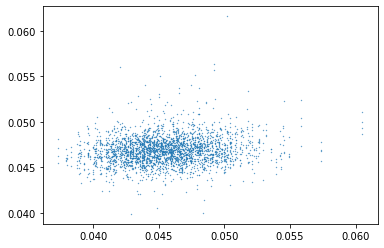

In [174]:
labb = '_other' #S8 h100 [0.6,.0.78]  ns [0.89,.0.935]  ob [0.04,.0.055] 
compr_dv = np.load(output_folder+'/{0}.npy'.format(type_+labb),allow_pickle=True).item()
plt.scatter(compr_dv['ST_S2']['sim_params_v'][:,3],compr_dv['ST_S2']['compressed_data_v'][:,3],s=0.1)
plt.show()
#plt.scatter(compr_dv['ST_S2']['sim_params_v'][:,1],compr_dv['ST_S2']['compressed_data_v'][:,1],s=0.1)

#plt.scatter(compr_dv['ST_S2']['compressed_data_v'][:,0],compr_dv['ST_S2']['compressed_data_v'][:,1],s=0.1,color='red')

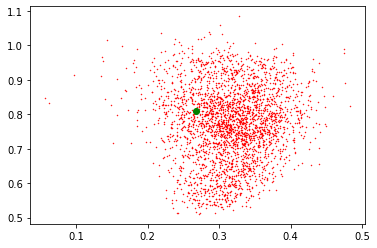

In [25]:
#plt.scatter(compr_dv['ST_S2']['sim_params_v'][:,0],compr_dv['ST_S2']['sim_params_v'][:,1],s=0.1)
plt.scatter(compr_dv['ST_S2']['compressed_data_v'][:,0],compr_dv['ST_S2']['compressed_data_v'][:,1],s=0.1,color='red')

plt.scatter(compr_dv['ST_S2']['compressed_data_v'][:,0],compr_dv['ST_S2']['compressed_data_v'][:,1],s=0.1,color='red')
plt.scatter([compr_dv['ST_S2']['compressed_data0d'][0]],[compr_dv['ST_S2']['compressed_data0d'][1]],color='green')

In [17]:
#.keys()
np

<module 'numpy' from '/global/homes/m/mgatti/.conda/envs/bfd_env3/lib/python3.6/site-packages/numpy/__init__.py'>

# Compute posterior

In [ ]:
import numpy as np
import os, sys
import sys
sys.path.insert(0, "/global/cfs/cdirs/des/mgatti/tensorflow_115/")
import tensorflow as tf
import pydelfi.priors as priors
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
    
from scipy.optimize import minimize,differential_evolution
import copy
import emcee
def initial_parameters(theta, relative_sigma):
    """
    This is not randomise the initial position of the
    :param theta: list/a
    rray of parameter values
    :param relative_sigma: controls variance of random draws
    :return: the theta array but with random shifts
    """
    theta = np.array(theta)
    return np.random.normal(theta, np.abs(theta * relative_sigma))



In [ ]:
def run_chains(key,i,iii,it,compr_dv,target_compr_dv,chain_folder,output_folder,iter_gof=500):
    
    import os
    
    output_folder
    if not os.path.exists(chain_folder+'_'+key+'.pkl'):
        print ('doing ',chain_folder+'_'+key+'.pkl')
        
        
        results = compr_dv[key]
        target_results = target_compr_dv[key]
        base = 1000*it+80*iii+4*i+10

        nn = len(label_runs)
        prior = priors.Uniform(lower, upper)
        #compressed_data1 = results['compressed_data0']
        if use_only_validation:
            compressed_data1 = results['compressed_data_v']
        else:
             compressed_data1 = results['compressed_data_a']

        
        NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=nn, n_data=compressed_data1.shape[1], n_hiddens=[50,50], n_mades=2, act_fun=tf.tanh, index=base + 0),
                ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=nn, n_data=compressed_data1.shape[1], n_hiddens=[50,50], n_mades=3, act_fun=tf.tanh, index=base + 1),
                ndes.MixtureDensityNetwork(n_parameters=nn, n_data=compressed_data1.shape[1], n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=base + 2),
                ndes.MixtureDensityNetwork(n_parameters=nn, n_data=compressed_data1.shape[1], n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=base + 3)]

        base += compressed_data1.shape[1]
        
        pn = ['p{0}'.format(i) for i in range(nn)]
        

        import os
        try:
            os.mkdir(result_dir+'/'+str(base))
        except:
            pass
        try:
            os.system('rm '+result_dir+'/'+str(base)+'/*')
        except:
            pass

        if use_only_validation:
            DelfiEnsemble = delfi.Delfi(np.array(np.median(results['compressed_data_v'],axis=0), dtype = 'float'), prior, NDEs,
                                    param_limits = [lower, upper],
                                    param_names = pn, 
                                    results_dir = result_dir+'/'+str(base)+'/')
        else:
            DelfiEnsemble = delfi.Delfi(np.array(np.median(results['compressed_data_a'],axis=0), dtype = 'float'), prior, NDEs,
                                    param_limits = [lower, upper],
                                    param_names = pn, 
                                    results_dir = result_dir+'/'+str(base)+'/')
            
        def log_like_temp(theta2d, data):
             return -(DelfiEnsemble.log_posterior_stacked([theta2d.T],data=data)[0][0])


        if use_only_validation:
            DelfiEnsemble.load_simulations(np.array(results['compressed_data_v'][:5000,:], dtype = 'float'), results['sim_params_v'][:5000,:][:,sm_p])
        else:
            DelfiEnsemble.load_simulations(np.array(results['compressed_data_a'][:5000,:], dtype = 'float'), results['sim_params_a'][:5000,:][:,sm_p])
    
        #print (np.array(results['compressed_data1'][:5000,:]).shape,results['sim_params1'][:5000,:][:,sm_p].shape)
        
        DelfiEnsemble.train_ndes()

        
        n_dim2d=nn
        n_burn2d=100
        n_steps2d = 10000
        n_walkers2d = nn * n_dim2d


        theta0_2d = np.array([list(initial_parameters(theta2d_expected_mean, 0.01)) for i in range(n_walkers2d)])




        def prior_term2d(theta2d):
            p_ = theta2d.T
            for i in range(len(p_)):
                if ((p_[i]<lower[i])|(p_[i]>upper[i])):
                    return  - np.inf
            return  0.



        def log_posterior2d_temp(theta2d, data):
            
            return DelfiEnsemble.log_posterior_stacked([theta2d.T],data=target_results['compressed_data0d'])[0][0] + prior_term2d(theta2d)


        sampler2d_ = mc.EnsembleSampler(n_walkers2d, n_dim2d, log_posterior2d_temp,args=(compressed_data1,))

        _ = sampler2d_.run_mcmc(theta0_2d, n_burn2d+n_steps2d)

        #results_mcmc[key] = sampler2d_

        sampler2d_ = sampler2d_.get_chain()

        
        ###### GOF ################
        store = []
        for i__ in range(iter_gof):
            if use_only_validation:
                i__i = np.random.randint(0,len(results['compressed_data_v']),1)[0]
                target_dv1  = copy.deepcopy(results['compressed_data_v'][i__i])
            else:
                i__i = np.random.randint(0,len(results['compressed_data_a']),1)[0]
                target_dv1  = copy.deepcopy(results['compressed_data_a'][i__i])
            
            # Define the bounds for each parameter (if needed)
            bounds = [(lower[0], upper[0]), (lower[1], upper[1]),  (lower[2], upper[2]),  (lower[3], upper[3])]
            # Perform the optimization
            rslt = differential_evolution(log_like_temp, bounds=bounds, args=(target_dv1,))
            # Retrieve the optimized parameters
            optimized_params = rslt.x
            store.append(log_like_temp(optimized_params, target_dv1)) 
        rslt = differential_evolution(log_like_temp, bounds=bounds, args=(target_results['compressed_data0d'],))
        
        optimized_params = rslt.x
        data_loglike = (log_like_temp(optimized_params, target_dv1)) 
        
        save_obj(chain_folder+'_'+key,{'chain':sampler2d_,'logdata':data_loglike,'logsims':store})
    else:
        print ('done ',(chain_folder+'_'+key+'.pkl'))
   

folder = '/global/cfs/cdirs/des/mgatti/LFI_runs_august_2023/'   
use_only_validation = True
      
ff = ['everything']
type_ = 'data'#,'cosmogrid']
#type_ = 'cosmogrid_B'

types_ = ['cosmogrid']#,'cosmogrid_B','cosmogrid']
#types_ = ['cosmogrid','cosmogrid_B']

if __name__ == '__main__':
    for it, type_ in enumerate(types_):
        for iii, f in enumerate(ff):     

            output_folder  = folder +f+'_data/' 



            # default prior -----------------
            lower = np.array([0.15, 0.55,0.2,0])
            upper = np.array([0.49, 0.99,0.85,1])
            theta2d_expected_mean = [0.3, 0.75,0.5,0.5]


            label_runs = ['Om','S8','w','A']
            sm_p = [True,True,True,True] #,False,False]

            if use_only_validation:
                chain_folder = folder +f+'_data/chain_val_{0}_4p/'.format(type_)
            else:
                chain_folder = folder +f+'_data/chain_all_{0}_4p/'.format(type_)
                
            if not os.path.exists(chain_folder):
                try:
                    os.mkdir(chain_folder)
                except:
                    pass

            result_dir = '../../../../../cscratch1/sd/mgatti/temp_/'
            result_dir = '../../../../../../../pscratch/sd/m/mgatti/temp2/'
            run_count=0

            compr_dv = np.load(output_folder+'/{0}.npy'.format(type_),allow_pickle=True).item()
            target_compr_dv = np.load(output_folder+'/{0}.npy'.format(type_),allow_pickle=True).item()
            keys = list(compr_dv.keys())
            runstodo = len(keys)

            for i,key in enumerate(keys):
                if type_ =='data':
                    iter_gof = 1 #00
                else:
                    iter_gof = 1
                run_chains(key,i,iii,it,compr_dv,target_compr_dv,chain_folder,output_folder,iter_gof)




In [1]:
1

1

# scale cuts

In [33]:
import getdist
import random
import glob
import emcee as mc
from getdist import plots, MCSamples
import pickle
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        mute =  pickle.load(f)
        f.close()
    return mute
import numpy as np

def read_in_chains(f,lab,recap=False):
    results1 = dict()
    for f_ in f:
        k = f_.split(lab)[1].split('.pkl')[0]
        try:
            results1[k]
        except:
            results1[k] = dict()



        m = load_obj(f_.split('.pkl')[0])
        logs = np.array(m['logsims'])
        logd = m['logdata']
        pv = 1.*len(logs[logd<logs])/len(logs)
        results1[k]['pv'] = pv
        results1[k]['logs'] = logs
        results1[k]['logd'] = logd
        results1[k]['S8'] = m['chain'][:,:,1].std()
        results1[k]['om'] = m['chain'][:,:,0].std()
        results1[k]['sigma_8'] = ((m['chain'][:,:,1]/np.sqrt(m['chain'][:,:,0]/0.3)).std())


        results1[k]['S8_m'] = m['chain'][:,:,1].mean()

        results1[k]['om_m'] = m['chain'][:,:,0].mean()

        results1[k]['S8_c'] = m['chain'][:,:,1]
        results1[k]['sigma8_c'] = m['chain'][:,:,1]/np.sqrt(m['chain'][:,:,0]/0.3)

        results1[k]['om_c'] = m['chain'][:,:,0]

        try:
            results1[k]['S8_c1'] = m['sampler2d_i'][0][:,:,1]
            results1[k]['om_c1'] = m['sampler2d_i'][0][:,:,0]
            results1[k]['S8_c2'] = m['sampler2d_i'][1][:,:,1]
            results1[k]['om_c2'] = m['sampler2d_i'][1][:,:,0]
            results1[k]['S8_c3'] = m['sampler2d_i'][2][:,:,1]
            results1[k]['om_c3'] = m['sampler2d_i'][2][:,:,0]
            results1[k]['S8_c4'] = m['sampler2d_i'][3][:,:,1]
            results1[k]['om_c4'] = m['sampler2d_i'][3][:,:,0]


        except:
            pass
        try:
            results1[k]['w'] = m['chain'][:,:,2].std()
            results1[k]['w_c'] = m['chain'][:,:,2]
            results1[k]['w_m'] = m['chain'][:,:,2].mean()

        except:
            pass

        try:
            results1[k]['A_c'] = m['chain'][:,:,3]
            results1[k]['A'] = m['chain'][:,:,3].std()   
            results1[k]['A_m'] = m['chain'][:,:,3].mean()
        except:
            pass


        samples2 = MCSamples(samples=[results1[k]['om_c'].flatten(),results1[k]['S8_c'].flatten()],
                                names = ['$\Omega_m$','$S_8$'],
                       label=[k+' 1 rel'],
                       # ranges={'$\Omega_m$':[0.1,0.55],
                      #          '$S_8$':[0.5,1.]},
                       settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.2})
        results1[k]['FOM'] = 1/np.sqrt(np.linalg.det(samples2.cov()))
        
        if recap:
            print (k,' {0:2.3f} {1:2.0f} '.format(results1[k]['S8'],results1[k]['FOM']))
    return results1

In [34]:
lab = 'chain_val_cosmogrid_4p/_'.format(0)
f = glob.glob('/global/cfs/cdirs/des/mgatti/LFI_runs_august_2023/everything_data/chain_val_cosmogrid_4p/*'.format(0))

results_val_4p_cosmo = read_in_chains(f,lab,recap=True)


lab = 'chain_val_cosmogrid_B_4p/_'
f = glob.glob('/global/cfs/cdirs/des/mgatti/LFI_runs_august_2023/everything_data/chain_val_cosmogrid_B_4p/*')

results_val_4p_cosmo_B = read_in_chains(f,lab,recap=True)



Removed no burn in
all_2nd_moments_ST_PWHM_3rd_moments  0.006 54725 
Removed no burn in
PWH_Gauss  0.041 471 
Removed no burn in
ST_S2  0.048 370 
Removed no burn in
cl_peaks  0.034 699 
Removed no burn in
3rd_moments  0.069 196 
Removed no burn in
PWH_S00_S01  0.032 554 
Removed no burn in
2nd_PWHG  0.031 815 
Removed no burn in
2nd_3rd_moments  0.031 718 
Removed no burn in
PWH_S00  0.044 345 
Removed no burn in
2nd_moments_PWH_S01_PWH_S00  0.026 990 
Removed no burn in
all_2nd_moments_ST_PWHM_ng  0.024 1137 
Removed no burn in
PWH_Gauss_PWH_S01_PWH_S00  0.028 833 
Removed no burn in
2nd_moments_ST_S2_ST_S0_ST_S1  0.030 814 
Removed no burn in
cl  0.048 378 
Removed no burn in
ST_S1_ST_S2_ST_S0  0.036 592 
Removed no burn in
ST_S1  0.052 328 
Removed no burn in
peaks  0.047 364 
Removed no burn in
2nd_moments  0.039 575 
Removed no burn in
PWH_Gauss_ST_S2_ST_S0_ST_S1  0.032 704 
Removed no burn in
ST_S0  0.108 105 
Removed no burn in
2nd_moments_peaks  0.032 832 
Removed no burn in
P

In [85]:
results_val_4p_cosmo.keys()

dict_keys(['all_2nd_moments_ST_PWHM_3rd_moments', 'PWH_Gauss', 'ST_S2', 'cl_peaks', '3rd_moments', '2nd_PWHG', '2nd_3rd_moments', 'PWH_S00', '2nd_moments_PWH_S01_PWH_S00', 'all_2nd_moments_ST_PWHM_ng', 'PWH_Gauss_PWH_S01_PWH_S00', '2nd_moments_ST_S2_ST_S0_ST_S1', 'cl', 'ST_S1_ST_S2_ST_S0', 'ST_S1', 'peaks', '2nd_moments', 'PWH_Gauss_ST_S2_ST_S0_ST_S1', 'ST_S0', '2nd_moments_peaks', 'PWH_S01', 'all_ST_PWHM', 'all_2nd_moments_ST_PWHM_ng_3rd_moments'])

2nd_moments
Removed no burn in
Removed no burn in


<Figure size 864x864 with 0 Axes>

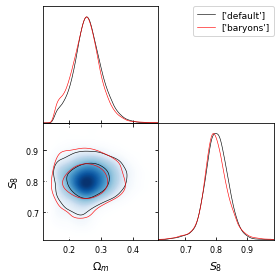

Optimization terminated successfully.
         Current function value: 0.000101
         Iterations: 21
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000431
         Iterations: 7
         Function evaluations: 14
[0.003375]
Optimization terminated successfully.
         Current function value: 0.000332
         Iterations: 7
         Function evaluations: 14
[0.0033125]
Optimization terminated successfully.
         Current function value: 0.000563
         Iterations: 21
         Function evaluations: 43
PWH_Gauss
Removed no burn in
Removed no burn in


<Figure size 360x600 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 864x864 with 0 Axes>

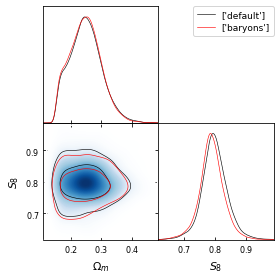

Optimization terminated successfully.
         Current function value: 0.000524
         Iterations: 21
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000674
         Iterations: 16
         Function evaluations: 32
[0.04575]
Optimization terminated successfully.
         Current function value: 0.000386
         Iterations: 15
         Function evaluations: 31
[0.040625]
Optimization terminated successfully.
         Current function value: 0.000119
         Iterations: 21
         Function evaluations: 42
3rd_moments
Removed no burn in
Removed no burn in


<Figure size 360x600 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 864x864 with 0 Axes>

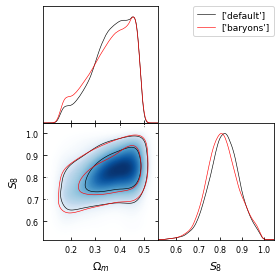

Optimization terminated successfully.
         Current function value: 0.001066
         Iterations: 25
         Function evaluations: 52
Optimization terminated successfully.
         Current function value: 0.000743
         Iterations: 18
         Function evaluations: 36
[0.0926875]
Optimization terminated successfully.
         Current function value: 0.000743
         Iterations: 17
         Function evaluations: 34
[0.070625]
Optimization terminated successfully.
         Current function value: 0.000188
         Iterations: 25
         Function evaluations: 50
PWH_S00
Removed no burn in
Removed no burn in


<Figure size 360x600 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 864x864 with 0 Axes>

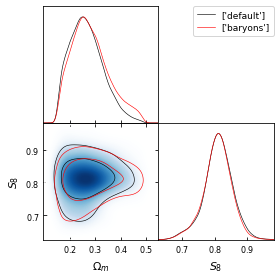

Optimization terminated successfully.
         Current function value: 0.000097
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000437
         Iterations: 6
         Function evaluations: 12
[0.00425]
Optimization terminated successfully.
         Current function value: 0.000177
         Iterations: 4
         Function evaluations: 8
[0.0046875]
Optimization terminated successfully.
         Current function value: 0.000774
         Iterations: 22
         Function evaluations: 47
PWH_S01
Removed no burn in
Removed no burn in


<Figure size 360x600 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 864x864 with 0 Axes>

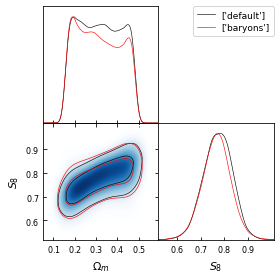

Optimization terminated successfully.
         Current function value: 0.000899
         Iterations: 22
         Function evaluations: 45
PWH_Gauss_PWH_S01_PWH_S00
Removed no burn in
Removed no burn in


<Figure size 360x600 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 864x864 with 0 Axes>

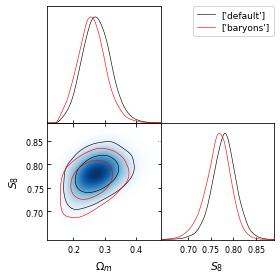

Optimization terminated successfully.
         Current function value: 0.000162
         Iterations: 22
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000136
         Iterations: 18
         Function evaluations: 36
[0.1118125]
Optimization terminated successfully.
         Current function value: 0.000097
         Iterations: 19
         Function evaluations: 38
[0.1375625]
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 18
         Function evaluations: 36
ST_S1
Removed no burn in
Removed no burn in


<Figure size 360x600 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 864x864 with 0 Axes>

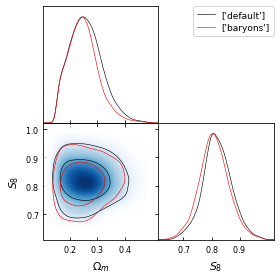

Optimization terminated successfully.
         Current function value: 0.000832
         Iterations: 22
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000567
         Iterations: 14
         Function evaluations: 29
[0.0291875]
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 14
         Function evaluations: 28
[0.0255625]
Optimization terminated successfully.
         Current function value: 0.000504
         Iterations: 21
         Function evaluations: 42
ST_S2
Removed no burn in
Removed no burn in


<Figure size 360x600 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 864x864 with 0 Axes>

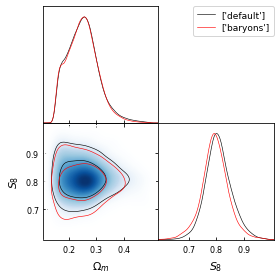

Optimization terminated successfully.
         Current function value: 0.000398
         Iterations: 19
         Function evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000119
         Iterations: 11
         Function evaluations: 22
[0.011125]
Optimization terminated successfully.
         Current function value: 0.000614
         Iterations: 9
         Function evaluations: 18
[0.00925]
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 19
         Function evaluations: 38
ST_S1_ST_S2_ST_S0
Removed no burn in
Removed no burn in


<Figure size 360x600 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 864x864 with 0 Axes>

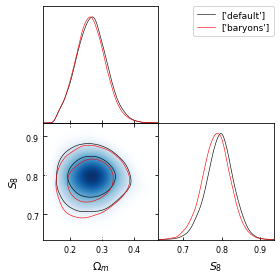

Optimization terminated successfully.
         Current function value: 0.000558
         Iterations: 18
         Function evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000451
         Iterations: 18
         Function evaluations: 38
[0.0591875]
Optimization terminated successfully.
         Current function value: 0.000795
         Iterations: 16
         Function evaluations: 32
[0.0555625]
Optimization terminated successfully.
         Current function value: 0.000351
         Iterations: 17
         Function evaluations: 34
2nd_3rd_moments
Removed no burn in
Removed no burn in


<Figure size 360x600 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 864x864 with 0 Axes>

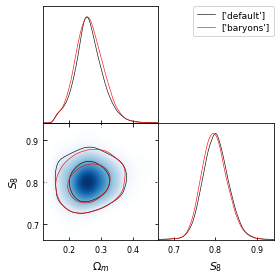

Optimization terminated successfully.
         Current function value: 0.000457
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000302
         Iterations: 12
         Function evaluations: 24
[0.016875]
Optimization terminated successfully.
         Current function value: 0.000317
         Iterations: 13
         Function evaluations: 26
[0.0201875]
Optimization terminated successfully.
         Current function value: 0.000196
         Iterations: 21
         Function evaluations: 42
2nd_moments_PWH_S01_PWH_S00
Removed no burn in
Removed no burn in


<Figure size 360x600 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 864x864 with 0 Axes>

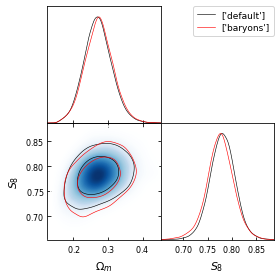

Optimization terminated successfully.
         Current function value: 0.000733
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000364
         Iterations: 13
         Function evaluations: 26
[0.0234375]
Optimization terminated successfully.
         Current function value: 0.000357
         Iterations: 13
         Function evaluations: 26
[0.02225]
Optimization terminated successfully.
         Current function value: 0.000161
         Iterations: 19
         Function evaluations: 38
all_2nd_moments_ST_PWHM_ng
Removed no burn in
Removed no burn in


<Figure size 360x600 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 864x864 with 0 Axes>

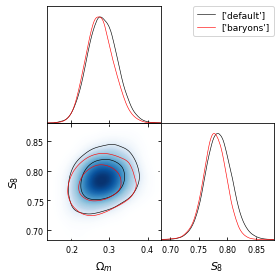

Optimization terminated successfully.
         Current function value: 0.000252
         Iterations: 20
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000167
         Iterations: 17
         Function evaluations: 34
[0.045375]
Optimization terminated successfully.
         Current function value: 0.000220
         Iterations: 17
         Function evaluations: 34
[0.047875]
Optimization terminated successfully.
         Current function value: 0.000467
         Iterations: 16
         Function evaluations: 32
all_2nd_moments_ST_PWHM_ng_3rd_moments
Removed no burn in
Removed no burn in


<Figure size 360x600 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 864x864 with 0 Axes>

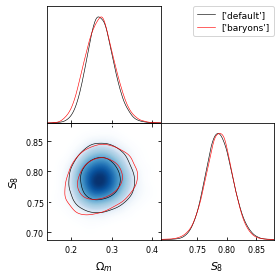

Optimization terminated successfully.
         Current function value: 0.000317
         Iterations: 14
         Function evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000217
         Iterations: 13
         Function evaluations: 27
[0.021375]
Optimization terminated successfully.
         Current function value: 0.000485
         Iterations: 12
         Function evaluations: 24
[0.01775]
Optimization terminated successfully.
         Current function value: 0.000294
         Iterations: 19
         Function evaluations: 38


<Figure size 360x600 with 0 Axes>

<Figure size 432x324 with 0 Axes>

In [35]:
import getdist
import random
import emcee as mc
from getdist import plots, MCSamples

keys = ['2nd_moments','PWH_Gauss','3rd_moments','PWH_S00','PWH_S01','PWH_Gauss_PWH_S01_PWH_S00',
'ST_S1','ST_S2','ST_S1_ST_S2_ST_S0','2nd_3rd_moments','2nd_moments_PWH_S01_PWH_S00','all_2nd_moments_ST_PWHM_ng','all_2nd_moments_ST_PWHM_ng_3rd_moments'] #all_2nd_moments_ST_PWHM_3rd_moments
#keys = ['ST_S1_ST_S2_ST_S0'] #all_2nd_moments_ST_PWHM_3rd_moments
#keys = ['3rd_moments']
cont = []
#keys = ['all_2nd_moments_ST_PWHM_3rd_moments']#
#keys = ['SR_2nd_3rd_moments'] #all_2nd_moments_ST_PWHM_3rd_moments
#cont = []
kk_ = []
for k in keys:
    #try:
        print (k)
        kk_.append(k)
        samples2 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten()],
                            names = ['$\Omega_m$','$S_8$'],
                           label=['default'],
                           # ranges={'$\Omega_m$':[0.1,0.55],
                          #          '$S_8$':[0.5,1.]},
                           settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.2})

        samples1 = MCSamples(samples=[results_val_4p_cosmo_B[k]['om_c'].flatten(),results_val_4p_cosmo_B[k]['S8_c'].flatten()],
                            names = ['$\Omega_m$','$S_8$',],
                           label=['baryons'],
                           # ranges={'$\Omega_m$':[0.1,0.55],
                          #          '$S_8$':[0.5,1.]},
                           settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.2})




#
        plt.figure(figsize=(12,12))
        g = plots.get_subplot_plotter()
    ##
        g.triangle_plot([samples2,samples1],title = k,label = ['default','baryons'] ,shaded=True)
#
        plt.show()
        try:
            xx,xxu = do_scale_cut(samples1,samples2)
            cont.append (xx[0])
        except:
            cont.append(-1)
    #except:
    #    pass

In [ ]:
keys = ['2nd_moments','PWH_Gauss','3rd_moments','PWH_S00','PWH_S01','PWH_Gauss_PWH_S01_PWH_S00',
'ST_S1','ST_S2','ST_S1_ST_S2_ST_S0','2nd_3rd_moments','2nd_moments_PWH_S01_PWH_S00','all_2nd_moments_ST_PWHM_ng','all_2nd_moments_ST_PWHM_ng_3rd_moments'] #all_2nd_moments_ST_PWHM_3rd_moments
keys

In [38]:
for i,key in enumerate(keys):
    print(key,'{0:2.2f}'.format(cont[i]))

2nd_moments 0.00
PWH_Gauss 0.05
3rd_moments 0.09
PWH_S00 0.00
PWH_S01 -1.00
PWH_Gauss_PWH_S01_PWH_S00 0.11
ST_S1 0.03
ST_S2 0.01
ST_S1_ST_S2_ST_S0 0.06
2nd_3rd_moments 0.02
2nd_moments_PWH_S01_PWH_S00 0.02
all_2nd_moments_ST_PWHM_ng 0.05
all_2nd_moments_ST_PWHM_ng_3rd_moments 0.02


# Plot chains

In [4]:
lab = 'chain_val_cosmogrid_4p/_'.format(0)
f = glob.glob('/global/cfs/cdirs/des/mgatti/LFI_runs_august_2023/everything_data/chain_val_cosmogrid_4p/*'.format(0))
i=0
results_val_4p_cosmo = read_in_chains(f,lab,recap=True)

Removed no burn in
all_2nd_moments_ST_PWHM_3rd_moments  0.006 54725 
Removed no burn in
PWH_Gauss  0.041 471 
Removed no burn in
ST_S2  0.048 370 
Removed no burn in
cl_peaks  0.034 699 
Removed no burn in
3rd_moments  0.069 196 
Removed no burn in
PWH_S00_S01  0.032 554 
Removed no burn in
2nd_PWHG  0.031 815 
Removed no burn in
2nd_3rd_moments  0.031 718 
Removed no burn in
PWH_S00  0.044 345 
Removed no burn in
2nd_moments_PWH_S01_PWH_S00  0.026 990 
Removed no burn in
all_2nd_moments_ST_PWHM_ng  0.024 1137 
Removed no burn in
PWH_Gauss_PWH_S01_PWH_S00  0.028 833 
Removed no burn in
2nd_moments_ST_S2_ST_S0_ST_S1  0.030 814 
Removed no burn in
cl  0.048 378 
Removed no burn in
ST_S1_ST_S2_ST_S0  0.036 592 
Removed no burn in
ST_S1  0.052 328 
Removed no burn in
peaks  0.047 364 
Removed no burn in
2nd_moments  0.039 575 
Removed no burn in
PWH_Gauss_ST_S2_ST_S0_ST_S1  0.032 704 
Removed no burn in
ST_S0  0.108 105 
Removed no burn in
2nd_moments_peaks  0.032 832 
Removed no burn in
P

In [120]:
results_val_4p_cosmo.keys()
keys = ['2nd_moments','PWH_Gauss','3rd_moments','PWH_S00','PWH_S01','PWH_S00_S01','ST_S1','ST_S2','ST_S1_ST_S2_ST_S0',
       '2nd_3rd_moments','2nd_moments_ST_S2_ST_S0_ST_S1','2nd_moments_PWH_S01_PWH_S00','all_2nd_moments_ST_PWHM_ng','all_2nd_moments_ST_PWHM_ng_3rd_moments']

label = ['2nd moments', 'WPHG','3rd moments','WPH S00','WPH S01+C01','WPH S00+S01+C01','ST1','ST2','ST1 + ST2',
        '2nd moments + 3rd moments',  '2nd moments + ST1 + ST2' ,  '2nd moments + WPH S00+S01+C01' ,  '2nd moments + ST1 + ST2 + WPH S00+S01+C01' ,  '2nd moments + 3rd moments + ST1 + ST2 + WPH S00+S01+C01' ]
#2nd moments & 4.1  & 4.5 & 557\\
for i,k in enumerate(keys):
    uu = copy.deepcopy(results_val_4p_cosmo[k])
    if k == '2nd_moments':
        ref = np.array([uu['S8']*100,uu['sigma_8']*100,uu['om']*100,uu['w']*10,uu['A']*10,uu['FOM']])
        print (label[i],'& {0:2.1f} &  {1:2.1f}  &  {2:2.1f}   &  {3:2.1f}  &  {4:2.1f}  &  {5:2.0f} '.format(uu['S8']*100,uu['sigma_8']*100,uu['om']*100,uu['w']*10,uu['A']*10,uu['FOM'])+"\\" + '\\')
    
    else:
        new =  np.array([uu['S8']*100,uu['sigma_8']*100,uu['om']*100,uu['w']*10,uu['A']*10,uu['FOM']])
        impr = (new-ref)/ref*100.
        impr[:-1] *= -1.
        
        impr_l = []
        for ii in impr:
            if ii >0:
                impr_l.append('({\color{OliveGreen} +'+'{0:2.0f}'.format(ii)+'\%})')
            else:
                impr_l.append('({\color{red} '+'{0:2.0f}'.format(ii)+'\%})')
        #impr_l

        #print (impr_l[0])
        print (label[i],'& {0:2.1f}'.format(uu['S8']*100) + impr_l[0] + '& {0:2.1f}'.format(uu['sigma_8']*100) + impr_l[1]+ '& {0:2.1f}'.format(uu['om']*100) + impr_l[2] + '& {0:2.1f}'.format(uu['w']*10) + impr_l[3]+ '& {0:2.1f}'.format(uu['A']*10) + impr_l[4]+ '& {0:2.0f}'.format(uu['FOM']) + impr_l[5]+"\\" + '\\')
               
               
              # {6}&  {1:2.1f}{7}&  {2:2.1f}{8}   &  {3:2.1f}{9}  &  {4:2.1f}{10}  &  {5:2.0f}{11}  \\'
             #  .format(uu['S8']*100,uu['sigma_8']*100,uu['om']*100,uu['w']*10,uu['A']*10,uu['FOM'], impr_l[0],impr_l[1],impr_l[2],impr_l[3],impr_l[4],impr_l[5]))
                                                                                                                               
    
    
   # ({\color{OliveGreen} +5\%}) & 4.8  ({\color{red} -4\%})
    
    #else:
    #    print (k,' {0:2.3f} {1:2.0f} '.format(results_val_4p_cosmo[k]['S8'],results_val_4p_cosmo[k]['FOM']))

2nd moments & 3.9 &  8.6  &  4.5   &  1.7  &  1.0  &  575 \\
WPHG & 4.1({\color{red} -6\%})& 10.5({\color{red} -22\%})& 5.1({\color{red} -15\%})& 1.8({\color{red} -5\%})& 1.0({\color{red} -3\%})& 471({\color{red} -18\%})\\
3rd moments & 6.9({\color{red} -75\%})& 9.4({\color{red} -9\%})& 8.0({\color{red} -79\%})& 1.9({\color{red} -10\%})& 1.8({\color{red} -89\%})& 196({\color{red} -66\%})\\
WPH S00 & 4.4({\color{red} -14\%})& 11.8({\color{red} -37\%})& 6.5({\color{red} -46\%})& 1.7({\color{red} -1\%})& 1.7({\color{red} -79\%})& 345({\color{red} -40\%})\\
WPH S01+C01 & 6.1({\color{red} -55\%})& 10.1({\color{red} -18\%})& 9.8({\color{red} -120\%})& 1.9({\color{red} -7\%})& 2.1({\color{red} -117\%})& 220({\color{red} -62\%})\\
WPH S00+S01+C01 & 3.2({\color{OliveGreen} +18\%})& 9.0({\color{red} -5\%})& 5.7({\color{red} -26\%})& 1.3({\color{OliveGreen} +25\%})& 1.2({\color{red} -24\%})& 554({\color{red} -4\%})\\
ST1 & 5.2({\color{red} -32\%})& 12.0({\color{red} -40\%})& 5.9({\color{red} -32\

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


/global/homes/m/mgatti/.conda/envs/bfd_env3/lib/python3.6/site-packages/ipykernel_launcher.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


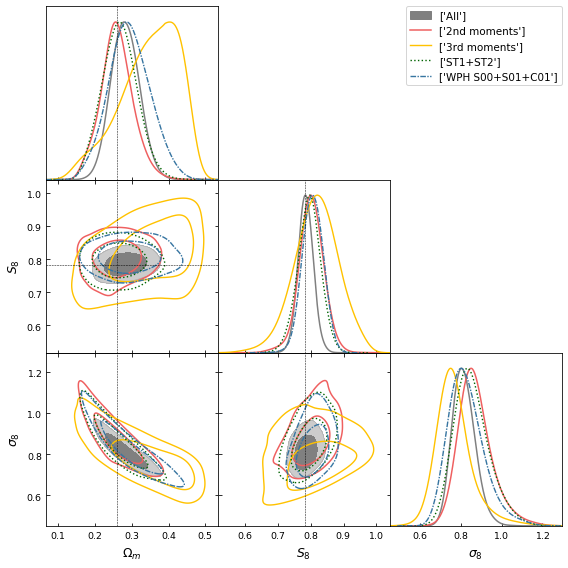

In [125]:
#SR_2nd_moments

import matplotlib.pyplot as plt
k = '2nd_moments'
#k = 'SR_2nd_moments'
target = 'cosmo DV'


samples2 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['sigma8_c'].flatten()],
                            names = ['$\Omega_m$','$S_8$','$\sigma_8$'],
                   label=['2nd moments'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})
#
k = '3rd_moments' #_ST_S2_ST_S0_ST_S1'
samples3 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten()-0.02,results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['sigma8_c'].flatten()+0.02],
                            names = ['$\Omega_m$','$S_8$','$\sigma_8$'],
                   label=['3rd moments'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})


k = 'ST_S1_ST_S2_ST_S0'
samples4 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['sigma8_c'].flatten()],
                            names = ['$\Omega_m$','$S_8$','$\sigma_8$'],
                   label=['ST1+ST2'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})

k = 'PWH_S00_S01'
samples5 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['sigma8_c'].flatten()],
                            names = ['$\Omega_m$','$S_8$','$\sigma_8$'],
                   label=['WPH S00+S01+C01'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})



'all_cl_2nd_moments_ST_PWHM_3rd_moments'
k = 'all_2nd_moments_ST_PWHM_ng'
samples6 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['sigma8_c'].flatten()],
                            names = ['$\Omega_m$','$S_8$','$\sigma_8$'],
                   label=['All'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})
#

g = plots.getSubplotPlotter(width_inch=8)

g.settings.axis_marker_color  = 'black'
#g = plots.get_subplot_plotter()
#g.triangle_plot([samples1,samples2],label = ['all','cl'],markers = [0.40,0.77,-0.7] ,shaded=True)
# [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0]
#g.triangle_plot([samples1,samples2,samples3,samples4],label = ['all','cl'],markers = [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0] ,shaded=True)
g.triangle_plot([samples6,samples2,samples3,samples4,samples5], filled=[True,False,False,False,False,False,False], colors=['grey',c_2,c_3,'#006400','#3775A1'],  alphas=[1.0,1.0,1.0,1.], contour_lws=[1.5,1.5,1.4,1.4,1.4,1.4],
                contour_ls =['-','-','-',':','-.'], contour_colors=['grey',c_2,c_3,'#006400','#3775A1'],legend_loc='upper right', markers = [0.26,0.84*np.sqrt(0.26/0.3),-1,0] ) #,
          #     param_limits = {'$\Omega_m$':[0.1,0.5],'$S_8$':[0.6,1.0],'$\sigma_8$':[0.4,1.4]})
#
#ax = g.subplots 
#ax[0][0].set_yticks([])
#ax[0][0].set_xticks([])
#
#
#
#ax[1][0].set_yticks([])
#ax[1][0].set_xticks([])
#
#ax[1][1].set_yticks([])
#ax[1][1].set_xticks([])
#
#ax[2][2].set_yticks([])
#ax[2][2].set_xticks([])
#
#ax[2][0].set_yticks([])
#ax[2][0].set_xticks([])
#
#ax[2][1].set_yticks([])
#ax[2][1].set_xticks([])
#
plt.tight_layout()

plt.savefig('//global/homes/m/mgatti/Mass_Mapping/peaks/data_extra_measurements/figures/All_sims.pdf',bbox_inches='tight')




Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


/global/homes/m/mgatti/.conda/envs/bfd_env3/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


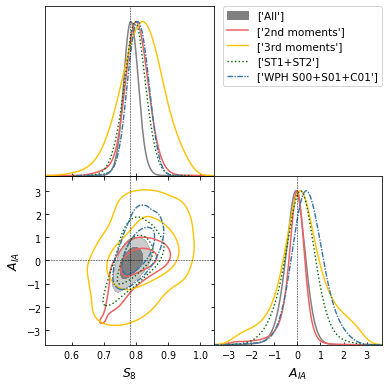

In [122]:
#SR_2nd_moments

import matplotlib.pyplot as plt
k = '2nd_moments'
#k = 'SR_2nd_moments'
target = 'cosmo DV'


samples2 = MCSamples(samples=[results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['A_c'].flatten()*6-3],
                            names = ['$S_8$','$A_{IA}$'],
                   label=['2nd moments'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})

#
k = '3rd_moments' #_ST_S2_ST_S0_ST_S1'
samples3 = MCSamples(samples=[results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['A_c'].flatten()*6-3],
                            names = ['$S_8$','$A_{IA}$'],
                   label=['3rd moments'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})



k = 'ST_S1_ST_S2_ST_S0'
samples4 = MCSamples(samples=[results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['A_c'].flatten()*6-3],
                            names = ['$S_8$','$A_{IA}$'],
                   label=['ST1+ST2'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})


k = 'PWH_S00_S01'
samples5 = MCSamples(samples=[results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['A_c'].flatten()*6-3],
                            names = ['$S_8$','$A_{IA}$'],
                   label=['WPH S00+S01+C01'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})




k = 'all_2nd_moments_ST_PWHM_ng'
samples6 = MCSamples(samples=[results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['A_c'].flatten()*6-3],
                            names = ['$S_8$','$A_{IA}$'],
                   label=['All'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})
#

g = plots.getSubplotPlotter(width_inch=5.5)
g.settings.axis_marker_color  = 'black'

#g = plots.get_subplot_plotter()
#g.triangle_plot([samples1,samples2],label = ['all','cl'],markers = [0.40,0.77,-0.7] ,shaded=True)
# [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0]
#g.triangle_plot([samples1,samples2,samples3,samples4],label = ['all','cl'],markers = [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0] ,shaded=True)
g.triangle_plot([samples6,samples2,samples3,samples4,samples5], filled=[True,False,False,False,False,False,False], colors=['grey',c_2,c_3,'#006400','#3775A1'],  alphas=[1.0,1.0,1.0,1.], contour_lws=[1.5,1.5,1.4,1.4,1.4,1.4],
                contour_ls =['-','-','-',':','-.'], contour_colors=['grey',c_2,c_3,'#006400','#3775A1'],legend_loc='upper right', markers = [0.84*np.sqrt(0.26/0.3),0] ) #
          #     param_limits = {'$\Omega_m$':[0.1,0.5],'$S_8$':[0.6,1.0],'$\sigma_8$':[0.4,1.4]})

ax = g.subplots 
#ax[0][0].set_yticks([])
#ax[0][0].set_xticks([])
#
#
#
#ax[1][0].set_yticks([])
#ax[1][0].set_xticks([])
#
#ax[1][1].set_yticks([])
#ax[1][1].set_xticks([])
#
#ax[2][2].set_yticks([])
#ax[2][2].set_xticks([])
#
#ax[2][0].set_yticks([])
#ax[2][0].set_xticks([])
#
#ax[2][1].set_yticks([])
#ax[2][1].set_xticks([])

plt.tight_layout()

plt.savefig('//global/homes/m/mgatti/Mass_Mapping/peaks/data_extra_measurements/figures/All_IA_2_sims.pdf',bbox_inches='tight')




Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no b

/global/homes/m/mgatti/.conda/envs/bfd_env3/lib/python3.6/site-packages/ipykernel_launcher.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


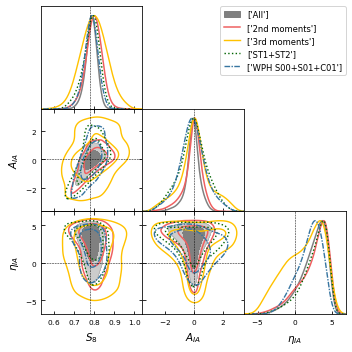

In [12]:
su = []

k = 'all_2nd_moments_ST_PWHM_ng'#,'2nd_3rd_moments']:#,'all_2nd_moments_ST_PWHM_ng']:

lab = 'chain_val_cosmogrid_4pIA/_'.format(0)
f = glob.glob('/global/cfs/cdirs/des/mgatti/LFI_runs_august_2023/everything_data/chain_val_cosmogrid_4pIA/*'.format(0))
i=0
results_val_4p_cosmo = read_in_chains(f,lab,recap=False)



lab = 'chain_val_cosmogrid_4p/_'.format(0)
f = glob.glob('/global/cfs/cdirs/des/mgatti/LFI_runs_august_2023/everything_data/chain_val_cosmogrid_4p/*'.format(0))

results_val_4p_cosmo_ref = read_in_chains(f,lab,recap=False)
#SR_2nd_moments

import matplotlib.pyplot as plt
k = '2nd_moments'
#k = 'SR_2nd_moments'
target = 'cosmo DV'


samples2 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten()*6-3,results_val_4p_cosmo[k]['w_c'].flatten()*10-5],
                            names = ['$S_8$','$A_{IA}$','$\eta_{IA}$'],
                   label=['2nd moments'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})


k = 'all_2nd_moments_ST_PWHM_ng'
samples3 = MCSamples(samples=[results_val_4p_cosmo_ref[k]['S8_c'].flatten(),results_val_4p_cosmo_ref[k]['A_c'].flatten()*6-3],
                            names = ['$S_8$','$A_{IA}$'],
                   label=['ref'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})
##
k = '3rd_moments' #_ST_S2_ST_S0_ST_S1'
samples3 =  MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten()*6-3,results_val_4p_cosmo[k]['w_c'].flatten()*10-5],
                            names = ['$S_8$','$A_{IA}$','$\eta_{IA}$'],
                   #label=['2nd moments'.format(target)],
                   label=['3rd moments'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})


k = 'ST_S1_ST_S2_ST_S0'
samples4 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten()*6-3,results_val_4p_cosmo[k]['w_c'].flatten()*10-5],
                            names = ['$S_8$','$A_{IA}$','$\eta_{IA}$'],
                  # label=['2nd moments'.format(target)],
                   label=['ST1+ST2'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})


'all_cl_2nd_moments_ST_PWHM_3rd_moments'
k = 'all_2nd_moments_ST_PWHM_ng'
samples6 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten()*6-3,results_val_4p_cosmo[k]['w_c'].flatten()*10-5],
                            names = ['$S_8$','$A_{IA}$','$\eta_{IA}$'],
                  # label=['2nd moments'.format(target)],
                   label=['All'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})
#


k = 'PWH_S00_S01'
samples5 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten()*6-3,results_val_4p_cosmo[k]['w_c'].flatten()*10-5],
                            names = ['$S_8$','$A_{IA}$','$\eta_{IA}$'],
                   
                   label=['WPH S00+S01+C01'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})

#

g = plots.getSubplotPlotter(width_inch=5)

g.settings.axis_marker_color = 'black'
#g = plots.get_subplot_plotter()
#g.triangle_plot([samples1,samples2],label = ['all','cl'],markers = [0.40,0.77,-0.7] ,shaded=True)
# [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0]
#g.triangle_plot([samples1,samples2,samples3,samples4],label = ['all','cl'],markers = [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0] ,shaded=True)
g.triangle_plot([samples6,samples2,samples3,samples4,samples5], filled=[True,False,False,False,False,False,False], colors=['grey',c_2,c_3,'#006400','#3775A1'],  alphas=[1.0,1.0,1.0,1.], contour_lws=[1.5,1.5,1.4,1.4,1.4,1.4],
                contour_ls =['-','-','-',':','-.'], contour_colors=['grey',c_2,c_3,'#006400','#3775A1'],legend_loc='upper right',markers = [0.84*np.sqrt(0.26/0.3),0.,0.,0.],axis_marker_color = 'black',axis_marker_ls=2)
          #     param_limits = {'$\Omega_m$':[0.1,0.5],'$S_8$':[0.6,1.0],'$\sigma_8$':[0.4,1.4]})

#g.triangle_plot([samples2,samples3], filled=[True,False,False,False,False,False,False], colors=['grey',c_2,c_3,'#006400','#3775A1'],  alphas=[1.0,1.0,1.0,1.], contour_lws=[1.5,1.5,1.4,1.4,1.4,1.4],
#                contour_ls =['-','-','-',':','-.'], contour_colors=['grey',c_2,c_3,'#006400','#3775A1'],legend_loc='upper right',markers = [0.84*np.sqrt(0.26/0.3),0.,0.,0.],axis_marker_color = 'black',axis_marker_ls=2)
          #     param_limits = {'$\Omega_m$':[0.1,0.5],'$S_8$':[0.6,1.0],'$\sigma_8$':[0.4,1.4]})

#ax = g.subplots 
#ax[0][0].set_yticks([])
#ax[0][0].set_xticks([])
#
#
#
#ax[1][0].set_yticks([])
#ax[1][0].set_xticks([])
#
#ax[1][1].set_yticks([])
#ax[1][1].set_xticks([])
#
#ax[2][2].set_yticks([])
#ax[2][2].set_xticks([])
#
#ax[2][0].set_yticks([])
#ax[2][0].set_xticks([])
#
#ax[2][1].set_yticks([])
#ax[2][1].set_xticks([])
#
plt.tight_layout()

#plt.savefig('//global/homes/m/mgatti/Mass_Mapping/peaks/data_extra_measurements/figures/All_sims.pdf',bbox_inches='tight')




In [ ]:
1

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


/global/homes/m/mgatti/.conda/envs/bfd_env3/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


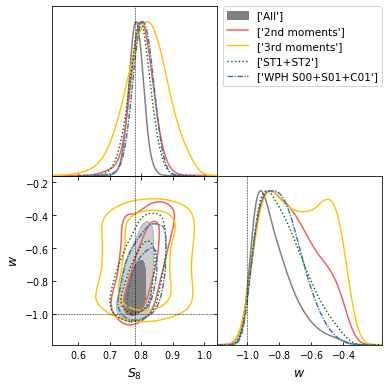

In [124]:
#SR_2nd_moments

import matplotlib.pyplot as plt
k = '2nd_moments'
#k = 'SR_2nd_moments'
target = 'cosmo DV'


samples2 = MCSamples(samples=[results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['w_c'].flatten()-1.2],
                            names = ['$S_8$','$w$'],
                   label=['2nd moments'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})

#
k = '3rd_moments' #_ST_S2_ST_S0_ST_S1'
samples3 = MCSamples(samples=[results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['w_c'].flatten()-1.2],
                            names = ['$S_8$','$w$'],
                   label=['3rd moments'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})



k = 'ST_S1_ST_S2_ST_S0'
samples4 = MCSamples(samples=[results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['w_c'].flatten()-1.2],
                            names = ['$S_8$','$w$'],
                   label=['ST1+ST2'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})


k = 'PWH_S00_S01'
samples5 = MCSamples(samples=[results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['w_c'].flatten()-1.2],
                            names = ['$S_8$','$w$'],
                   label=['WPH S00+S01+C01'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})




k = 'all_2nd_moments_ST_PWHM_ng'
samples6 = MCSamples(samples=[results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['w_c'].flatten()-1.2],
                            names = ['$S_8$','$w$'],
                   label=['All'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})
#

g = plots.getSubplotPlotter(width_inch=5.5)
g.settings.axis_marker_color  = 'black'

#g = plots.get_subplot_plotter()
#g.triangle_plot([samples1,samples2],label = ['all','cl'],markers = [0.40,0.77,-0.7] ,shaded=True)
# [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0]
#g.triangle_plot([samples1,samples2,samples3,samples4],label = ['all','cl'],markers = [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0] ,shaded=True)
g.triangle_plot([samples6,samples2,samples3,samples4,samples5], filled=[True,False,False,False,False,False,False], colors=['grey',c_2,c_3,'#006400','#3775A1'],  alphas=[1.0,1.0,1.0,1.], contour_lws=[1.5,1.5,1.4,1.4,1.4,1.4],
                contour_ls =['-','-','-',':','-.'], contour_colors=['grey',c_2,c_3,'#006400','#3775A1'],legend_loc='upper right', markers = [0.84*np.sqrt(0.26/0.3),-1] ) #
          #     param_limits = {'$\Omega_m$':[0.1,0.5],'$S_8$':[0.6,1.0],'$\sigma_8$':[0.4,1.4]})



plt.tight_layout()

plt.savefig('//global/homes/m/mgatti/Mass_Mapping/peaks/data_extra_measurements/figures/All_w_2_sims.pdf',bbox_inches='tight')




Removed no burn in
Removed no burn in
Removed no burn in


/global/homes/m/mgatti/.conda/envs/bfd_env3/lib/python3.6/site-packages/ipykernel_launcher.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


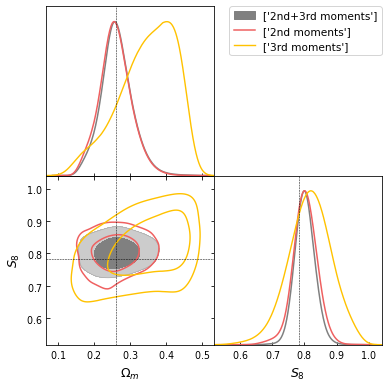

In [160]:
#SR_2nd_moments

import matplotlib.pyplot as plt
k = '2nd_3rd_moments'
#k = 'SR_2nd_moments'
target = 'cosmo DV'


samples2 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten()],
                           names = ['$\Omega_m$','$S_8$'],
                   label=['2nd+3rd moments'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})

#
k = '2nd_moments' #_ST_S2_ST_S0_ST_S1'
samples3 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten()],
                           names = ['$\Omega_m$','$S_8$'],
                   label=['2nd moments'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})

#


k = '3rd_moments'
samples4 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten()-0.02,results_val_4p_cosmo[k]['S8_c'].flatten()],
                           names = ['$\Omega_m$','$S_8$'],
                   label=['3rd moments'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})

#



g = plots.getSubplotPlotter(width_inch=5.5)
g.settings.axis_marker_color  = 'black'

#g = plots.get_subplot_plotter()
#g.triangle_plot([samples1,samples2],label = ['all','cl'],markers = [0.40,0.77,-0.7] ,shaded=True)
# [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0]
#g.triangle_plot([samples1,samples2,samples3,samples4],label = ['all','cl'],markers = [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0] ,shaded=True)
g.triangle_plot([samples2,samples3,samples4], filled=[True,False,False,False,False,False,False], colors=['grey',c_2,c_3,'#006400','#3775A1'],  alphas=[1.0,1.0,1.0,1.], contour_lws=[1.5,1.5,1.4,1.4,1.4,1.4],
                contour_ls =['-','-','-',':','-.'], contour_colors=['grey',c_2,c_3,'#006400','#3775A1'],legend_loc='upper right', markers = [0.26,0.84*np.sqrt(0.26/0.3),0] ) #
          #     param_limits = {'$\Omega_m$':[0.1,0.5],'$S_8$':[0.6,1.0],'$\sigma_8$':[0.4,1.4]})

ax = g.subplots 
#ax[0][0].set_yticks([])
#ax[0][0].set_xticks([])
#
#
#
#ax[1][0].set_yticks([])
#ax[1][0].set_xticks([])
#
#ax[1][1].set_yticks([])
#ax[1][1].set_xticks([])
#
#ax[2][2].set_yticks([])
#ax[2][2].set_xticks([])
#
#ax[2][0].set_yticks([])
#ax[2][0].set_xticks([])
#
#ax[2][1].set_yticks([])
#ax[2][1].set_xticks([])

plt.tight_layout()

plt.savefig('//global/homes/m/mgatti/Mass_Mapping/peaks/data_extra_measurements/figures/23_sims.pdf',bbox_inches='tight')




Removed no burn in
Removed no burn in
Removed no burn in


/global/homes/m/mgatti/.conda/envs/bfd_env3/lib/python3.6/site-packages/ipykernel_launcher.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


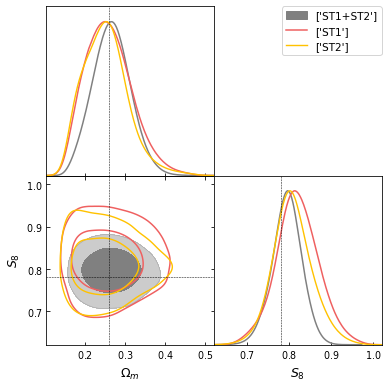

In [163]:
#SR_2nd_moments

import matplotlib.pyplot as plt
k = 'ST_S1_ST_S2_ST_S0'
#k = 'SR_2nd_moments'
target = 'cosmo DV'


samples2 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten()],
                           names = ['$\Omega_m$','$S_8$'],
                   label=['ST1+ST2'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})

#
k = 'ST_S1' #_ST_S2_ST_S0_ST_S1'
samples3 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten()],
                           names = ['$\Omega_m$','$S_8$'],
                   label=['ST1'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})

#


k = 'ST_S2'
samples4 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten()],
                           names = ['$\Omega_m$','$S_8$'],
                   label=['ST2'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})

#



g = plots.getSubplotPlotter(width_inch=5.5)
g.settings.axis_marker_color  = 'black'

#g = plots.get_subplot_plotter()
#g.triangle_plot([samples1,samples2],label = ['all','cl'],markers = [0.40,0.77,-0.7] ,shaded=True)
# [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0]
#g.triangle_plot([samples1,samples2,samples3,samples4],label = ['all','cl'],markers = [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0] ,shaded=True)
g.triangle_plot([samples2,samples3,samples4], filled=[True,False,False,False,False,False,False], colors=['grey',c_2,c_3,'#006400','#3775A1'],  alphas=[1.0,1.0,1.0,1.], contour_lws=[1.5,1.5,1.4,1.4,1.4,1.4],
                contour_ls =['-','-','-',':','-.'], contour_colors=['grey',c_2,c_3,'#006400','#3775A1'],legend_loc='upper right', markers = [0.26,0.84*np.sqrt(0.26/0.3),0] ) #
          #     param_limits = {'$\Omega_m$':[0.1,0.5],'$S_8$':[0.6,1.0],'$\sigma_8$':[0.4,1.4]})

ax = g.subplots 
#ax[0][0].set_yticks([])
#ax[0][0].set_xticks([])
#
#
#
#ax[1][0].set_yticks([])
#ax[1][0].set_xticks([])
#
#ax[1][1].set_yticks([])
#ax[1][1].set_xticks([])
#
#ax[2][2].set_yticks([])
#ax[2][2].set_xticks([])
#
#ax[2][0].set_yticks([])
#ax[2][0].set_xticks([])
#
#ax[2][1].set_yticks([])
#ax[2][1].set_xticks([])

plt.tight_layout()

plt.savefig('//global/homes/m/mgatti/Mass_Mapping/peaks/data_extra_measurements/figures/ST_sims.pdf',bbox_inches='tight')




In [57]:

%matplotlib inline
import matplotlib.pyplot as plt

su = []
for k in ['2nd_moments','all_2nd_moments_ST_PWHM_ng']:
    
  

    samples2 = MCSamples(samples=[results_val_4p[k]['om_c'.format(i)].flatten(),results_val_4p[k]['S8_c'.format(i)].flatten()],
                                     names = ['$\Omega_m$','$S_8$'],
                           label=[k],
                           # ranges={'$\Omega_m$':[0.1,0.55],
                          #          '$S_8$':[0.5,1.]},
                           settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})
    su.append(samples2)
    
    
    
g = plots.getSubplotPlotter(width_inch=5)#5.5)

g.triangle_plot(su,filled=[False,False,False,False,False,False,False],label = ['all','cl'],
                        contour_lws=[1.3,1.5,1.3,1,1,1],legend_loc='upper right', markers = [0.315,0.80*np.sqrt(0.315/0.3),-0.61,0] ) #,shaded=True)
plt.show()


NameError: name 'results_val_4p' is not defined

Removed no burn in
Removed no burn in


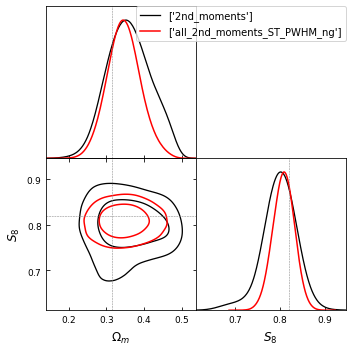

In [58]:

%matplotlib inline
import matplotlib.pyplot as plt

su = []
for k in ['2nd_moments','all_2nd_moments_ST_PWHM_ng']:
    
  

    samples2 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'.format(i)].flatten(),results_val_4p_cosmo[k]['S8_c'.format(i)].flatten()],
                                     names = ['$\Omega_m$','$S_8$'],
                           label=[k],
                           # ranges={'$\Omega_m$':[0.1,0.55],
                          #          '$S_8$':[0.5,1.]},
                           settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})
    su.append(samples2)
    
    
    
g = plots.getSubplotPlotter(width_inch=5)#5.5)

g.triangle_plot(su,filled=[False,False,False,False,False,False,False],label = ['all','cl'],
                        contour_lws=[1.3,1.5,1.3,1,1,1],legend_loc='upper right', markers = [0.315,0.80*np.sqrt(0.315/0.3),-0.61,0] ) #,shaded=True)
plt.show()


In [58]:
target = 0

In [ ]:

#chain_1x2pt_wcdm_022421_covupdate.v2.txt
#chain_3x2pt_wcdm_022421_covupdate.v2.txt



uu = np.genfromtxt('/global/cfs/cdirs/des/www/y3_chains/3x2pt/final_paper_chains/chain_3x2pt_wcdm_022421_covupdate.v2.txt', names = True)

mask = uu['COSMOLOGICAL_PARAMETERSSIGMA_8'] ==  uu['COSMOLOGICAL_PARAMETERSSIGMA_8']
mask = uu['cosmological_parametersw']>-1
sss = MCSamples(samples=np.c_[uu['cosmological_parametersomega_m'][mask],
                                      uu['COSMOLOGICAL_PARAMETERSSIGMA_8'][mask]*np.sqrt(uu['cosmological_parametersomega_m'][mask]/0.3)],
                                      weights=(uu['weight'][mask]), names = ['$\Omega_m$','$S_8$'],label=['3x2 wcdm'.format(target)])

uu = np.genfromtxt('/global/cfs/cdirs/des/www/y3_chains/3x2pt/final_paper_chains/chain_3x2pt_wcdm_022421_covupdate.v2.txt', names = True)
uu = np.genfromtxt('/global/cfs/cdirs/des/www/y3_chains/3x2pt/final_paper_chains/chain_1x2pt_wcdm_022421_covupdate.v2.txt', names = True)
uu = np.genfromtxt('/global/cfs/cdirs/des/mgatti/cosmic_shear_wcdm.txt', names = True)


  
mask =uu['cosmological_parametersw'] == uu['cosmological_parametersw'] #(uu['cosmological_parametersw']>-1) & (uu['intrinsic_alignment_parametersa2']**2<0.2)  & (uu['intrinsic_alignment_parametersalpha2']**2<1)
sss1 = MCSamples(samples=np.c_[uu['cosmological_parametersomega_m'][mask],
                                      uu['COSMOLOGICAL_PARAMETERSSIGMA_8'][mask]*np.sqrt(uu['cosmological_parametersomega_m'][mask]/0.3)],
                                      weights=(uu['weight'][mask]), names = ['$\Omega_m$','$S_8$'],
                 label=['cosmic shear wcdm'.format(target)])

    

import matplotlib.pyplot as plt
#k = 'all_2nd_moments_ST_PWHM_ng_3rd_moments'
##k = '2nd_moments'
#target = 'cosmo DV'
#
#
#samples2 = MCSamples(samples=[results1[k]['om_c'].flatten(),results1[k]['S8_c'].flatten()],
#                            names = ['$\Omega_m$','$S_8$'],
#                   label=['2nd moments'.format(target)],
#                   # ranges={'$\Omega_m$':[0.1,0.55],
#                  #          '$S_8$':[0.5,1.]},
#                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})


g = plots.getSubplotPlotter(width_inch=5)

#g.set_xticks([])
#g.set_yticks([])
#g = plots.get_subplot_plotter()
#g.triangle_plot([samples1,samples2],label = ['all','cl'],markers = [0.40,0.77,-0.7] ,shaded=True)
# [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0]
#g.triangle_plot([samples1,samples2,samples3,samples4],label = ['all','cl'],markers = [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0] ,shaded=True)

g.triangle_plot([samples2,sss,sss1],filled=[False,False,False,False,False,False,False],label = ['all','cl'],
                contour_lws=[1.3,1.5,1.3,1,1,1],contour_colors=['blue','red','black','#A4CD64','#3775A1'], colors=['blue','red','black','#A4CD64','#3775A1'],legend_loc='upper right')

#ax = g.subplots 
#ax[0][0].set_yticks([])
#ax[0][0].set_xticks([])
#
#ax[1][0].set_yticks([])
#ax[1][0].set_xticks([])
#
#ax[1][1].set_yticks([])
#ax[1][1].set_xticks([])

#ax[2][0].set_yticks([])
#ax[2][0].set_xticks([])

plt.tight_layout()
#plt.savefig('//global/homes/m/mgatti/Mass_Mapping/peaks/data_extra_measurements/figures/23.pdf',bbox_inches='tight')
#su = [samples2,sss,sss1]
#for kk in range(3):
#    
#    p = su[kk].getParams()
#    print (labels[kk])
#    print  ("Omega_m: {0:2.3f}+-{1:2.3f}".format( su[kk].mean(p.Om),0.5*(su[kk].twoTailLimits(p.Om, 0.68)[1]-su[kk].twoTailLimits(p.Om, 0.68)[0])))
#    print  ("S8 : {0:2.3f}+-{1:2.3f}".format( su[kk].mean(p.s8),0.5*(su[kk].twoTailLimits(p.s8, 0.68)[1]-su[kk].twoTailLimits(p.s8, 0.68)[0])))
#    
#    print ('')

/global/homes/m/mgatti/.conda/envs/bfd_env3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


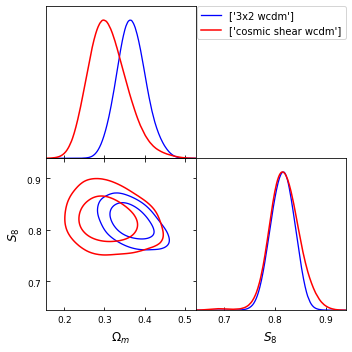

In [64]:
g = plots.getSubplotPlotter(width_inch=5)

#g.set_xticks([])
#g.set_yticks([])
#g = plots.get_subplot_plotter()
#g.triangle_plot([samples1,samples2],label = ['all','cl'],markers = [0.40,0.77,-0.7] ,shaded=True)
# [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0]
#g.triangle_plot([samples1,samples2,samples3,samples4],label = ['all','cl'],markers = [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0] ,shaded=True)

g.triangle_plot([sss,sss1],filled=[False,False,False,False,False,False,False],label = ['all','cl'],
                contour_lws=[1.3,1.5,1.3,1,1,1],contour_colors=['blue','red','black','#A4CD64','#3775A1'], colors=['blue','red','black','#A4CD64','#3775A1'],legend_loc='upper right')

#ax = g.subplots 
#ax[0][0].set_yticks([])
#ax[0][0].set_xticks([])
#
#ax[1][0].set_yticks([])
#ax[1][0].set_xticks([])
#
#ax[1][1].set_yticks([])
#ax[1][1].set_xticks([])

#ax[2][0].set_yticks([])
#ax[2][0].set_xticks([])

plt.tight_layout()
#plt.savefig('//global/homes/m/mgatti/Mass_Mapping/peaks/data_extra_measurements/figures/23.pdf',bbox_inches='tight')
#su = [samples2,sss,sss1]


In [1]:
import glob
f = glob.glob('/global/cfs/cdirs/des/mgatti/Dirac/LFI_dv_cosmogrid_fiducial/peaks//*')
len(f)#*6*4

798

# plot comparison

In [14]:
#samples4 = MCSamples(samples=[sampler2d_[:,:,0].flatten(),sampler2d_[:,:,1].flatten(),sampler2d_[:,:,2].flatten()-1.2,sampler2d_[:,:,3].flatten()*6-3],
#                            names = ['Om','s8','w','A'],
#                   label=['NLA LFI'],
#                   # ranges={'$\Omega_m$':[0.1,0.55],
#                  #          '$S_8$':[0.5,1.]},
#                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.2})
##
import numpy as np
sampler2d_NLA2 = np.load('../sampler2d_NLA2.npy')
sampler2d_NLA = np.load('../sampler2d_NLA.npy')


#
chains_dict = dict()
chains_dict['2nd moments1'] ='/global/cfs/cdirs/des/mgatti/chain_data_NLA.txt'

labels = []
su = []

for k in chains_dict.keys():
    
    
    uu = np.genfromtxt(chains_dict[k], names = True)
    mask = uu['cosmological_parametersomega_m'] > 0.15
    ss = MCSamples(samples=np.c_[uu['cosmological_parametersomega_m'][mask],
                                      -0.03+(uu['cosmological_parameterssigma8_input']*np.sqrt(uu['cosmological_parametersomega_m']/0.3))[mask],uu['cosmological_parametersw'][mask],uu['intrinsic_alignment_parametersa1'][mask]],
                                      label=['Halofit'],
                                      weights=(uu['weight'][mask]), names = ['Om','s8','w','A'], labels = ['om','s8','w','A'])


    
    
samples4_c = MCSamples(samples=[sampler2d_NLA2[:,:,0].flatten(),-0.03+sampler2d_NLA2[:,:,1].flatten(),sampler2d_NLA2[:,:,2].flatten()-1.2,sampler2d_NLA[:,:,3].flatten()*6-3],
                            names = ['Om','s8','w','A'],labels = [r'\Omega_{\rm m}',r'S_8','ns'],
                   label=['LFI'],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.2})
#



samples4_c2 = MCSamples(samples=[sampler2d_NLA[:,:,0].flatten(),-0.03+sampler2d_NLA[:,:,1].flatten(),sampler2d_NLA[:,:,2].flatten()-1.2,sampler2d_NLA[:,:,3].flatten()*6-3],
                            names = ['Om','s8','w','A'],labels = [r'$\Omega_{\rm m}$',r'$S_8$','ns'],
                   label=['halofit+Gaussian likelihood'],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.2})





Removed no burn in
Removed no burn in
Removed no burn in


Omega_m: 0.269+-0.068
S8 : 0.780+-0.022

Omega_m: 0.258+-0.064
S8 : 0.788+-0.022



<Figure size 288x288 with 0 Axes>

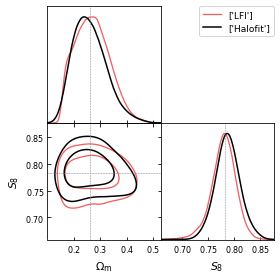

In [15]:
plt.figure(figsize=(4,4))
g = plots.get_subplot_plotter()
#g.triangle_plot([samples4_c,ss],['Om','s8'],label = ['all','cl'] ,shaded=True)

g.triangle_plot([samples4_c,ss],['Om','s8'],filled=[False,False,False,False,False,False,False],label = ['all','cl'],
                contour_lws=[1.3,1.5,1.3,1,1,1],contour_colors=[c_2,'black','#A4CD64','#3775A1'], 
                colors=[c_2,'black','#A4CD64','#3775A1'],legend_loc='upper right'  ,markers =[0.26,0.84*np.sqrt(0.26/0.3),-1,0] ) 



su = [samples4_c,ss]
for kk in range(2):
    p = su[kk].getParams()
    #print (labels[kk])
    print  ("Omega_m: {0:2.3f}+-{1:2.3f}".format( su[kk].mean(p.Om),0.5*(su[kk].twoTailLimits(p.Om, 0.68)[1]-su[kk].twoTailLimits(p.Om, 0.68)[0])))
    print  ("S8 : {0:2.3f}+-{1:2.3f}".format( su[kk].mean(p.s8),0.5*(su[kk].twoTailLimits(p.s8, 0.68)[1]-su[kk].twoTailLimits(p.s8, 0.68)[0])))
    
    print ('')
    
#plt.suptitle('test on cosmogrid DV',y=1.05)
#plt.tight_layout()
plt.savefig('/global/homes/m/mgatti/Mass_Mapping/peaks/figures/cosmosis_LFI_comparison.pdf',bbox_inches='tight')


In [11]:
0.810- 0.84*np.sqrt(0.26/0.3)

0.028002557548939322